# This notebook generates pi0 plots for specific set of pickles

In [1]:
%matplotlib inline
import platform
print(platform.python_version())
from ROOT import TFile,vector
import ROOT

import matplotlib.pyplot as plt
import pickle
import pandas as pd
import numpy as np
from numpy import mean
from math import sqrt,acos,cos,sin,pi,exp,log,isnan,atan2
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from numpy import asarray
from root_pandas import read_root
from matplotlib import gridspec
from scipy import stats
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import math


import pickle
import pandas as pd
import numpy as np
from numpy import mean
from math import sqrt,acos,cos,sin,pi,exp,log,isnan,atan2
from numpy import asarray
from root_pandas import read_root
from matplotlib import gridspec
from scipy import stats
from scipy.interpolate import interp1d
from scipy.integrate import quad
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from textwrap import wrap
import copy

import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages

3.5.2
Welcome to JupyROOT 6.14/08


In [2]:
# davios functions for plotting...

def Tune1(df):
    return df['xsec_tune1_weight'].values

def CV(df):
    wgt = []
    if 'xsec_corr_weight' in df.columns:
        wgt = df['xsec_corr_weight'].values
    else:
        for i in range(len(df)):
            wgt.append(1.0)
#     if False:
    if 'new_weight' in df.columns:
        tmpweights1 = df['new_weight'].values

    else:
        tmpweights1 = []
        for i in range(len(wgt)):
            tmpweights1.append(1.0)
    
    if 'pot_weight' in df.columns:
#     if False:
        tmpweights2 = df['pot_weight'].values
    else:
        tmpweights2 = []
        for i in range(len(wgt)):
            tmpweights2.append(1.0)
            
    for i in range(len(wgt)):
        wgt[i] = wgt[i]*tmpweights1[i]*tmpweights2[i]
#         
    wgt[wgt == np.inf] = 1
    wgt = np.nan_to_num(wgt)
    wgt[wgt <= 0] = 1
    
    return wgt

def Spline(df):
    wgt = df['spline_weight'].values
    wgt[wgt == np.inf] = 1
    wgt = np.nan_to_num(wgt)
    wgt[wgt <= 0] = 1
    return wgt


class sampHist:

    def __init__(self,samp_df,samp_l,samp_c,samp_wind,samp_s):
        self._df = samp_df.copy()
        self._label = samp_l
        self._color = samp_c
        self._scale = samp_s
        self._wi = samp_wind
        if samp_wind == 0:
            self._wgt = np.ones(len(samp_df))
        if samp_wind == 1:
            self._wgt = CV(samp_df)

    def setweight(self,windex):
        if windex == 0:
            self._wgt = np.ones(len(self._df))
        if windex == 1:
            self._wgt = CV(self._df)

    def dist(self,s_var):
        return self._df[s_var].values

    def cosdist(self,s_var):
        return np.cos(self._df[s_var].values)

    def applycut(self,s_cut):
        newhist = copy.deepcopy(self)
        newhist._df = self._df.query(s_cut)
        newhist.setweight(self._wi)
        return newhist

class SimpleHisto:

    def __init__ (self,df_df,f_scale,i_wgt,s_color,s_label):
        temp_df = df_df.copy()
        temp_df['myscale'] = f_scale
        self.mydf = temp_df
        self.mycolor = s_color
        self.mylabel = s_label
        self.iwgt = i_wgt

        self.mycut = 'Enu_1m1p > 0'

    def AddCut(self,s_cut):
        self.mycut  = s_cut

    def ClearCut(self):
        self.mycut = 'Enu_1m1p > 0'

    def GetHist(self,s_varname):
        temp_df = self.mydf.query(self.mycut)
        if self.iwgt == 1:
            myweight = CV(temp_df)
        elif self.iwgt == 0:
            myweight = np.ones(len(temp_df))
        return temp_df[s_varname].values,myweight,temp_df['myscale'].values,self.mycolor,self.mylabel

def GetErrorsData(xobs,CL=0.6827):
    step    = 0.01
    upperBoundary = int(max(10,xobs+5*np.sqrt(xobs)))
    r = np.arange(0.01,upperBoundary,step)
    s    = PmuGivenX(r,xobs)*step
    PDF1 = interp1d(r,s,bounds_error=False,fill_value=0)
    PPF1 = interp1d(np.cumsum(s),r)
    xobs_low  = float(PPF1((1-CL)/2))
    xobs_high = float(PPF1(1-(1-CL)/2))
    return xobs_low,xobs_high

class StackedHisto:

    def  __init__ (self,a_df_mc,a_df_scale):
        self.mystrata = []
        self.stratalabel = []
        self.stratacolor = []
        self.mylayer = []
        self.layerlabel = []
        self.layercolor = []
        self.layeriwgt = []
        self.stratxweight = []

        temp_a_df = []
        for i in range(len(a_df_mc)):
            temp_df = a_df_mc[i].copy()
            temp_df['myscale'] = a_df_scale[i]
            temp_a_df.append(temp_df)
        self.mymc = pd.concat(temp_a_df)
        self.mycut ='(shower1_E_Y>0 or shower1_E_Y<=0)'


    def ClearCut(self):
        self.mycut = 'Enu_1m1p > 0'

    def AddCut(self,s_cut):
        self.mycut  = s_cut

    def AddLayer(self,df_layer,df_scale,i_wgt,s_label,s_color):
        temp_df = df_layer.copy()
        temp_df['myscale'] = df_scale
        self.mylayer.append(temp_df)
        self.layerlabel.append(s_label)
        self.layercolor.append(s_color)
        self.layeriwgt.append(i_wgt)

    def AddStrata(self,s_strata,s_label,s_color,f_wgt=1.0):
        self.mystrata.append(s_strata)
        self.stratalabel.append(s_label)
        self.stratacolor.append(s_color)
        self.stratxweight.append(f_wgt)

    def GetHists(self,s_varname):
        a_vals = []        # (nxN)
        a_wgts = []
        a_scale = []
        a_cols = []        # (nx1)
        a_labels = []

        # first, run  through strata
        for i in range(len(self.mystrata)):
            # isolate this stratum with current cut
            temp_df = self.mymc.query(self.mystrata[i]+' and '+self.mycut)
            print(len(temp_df))
            a_vals.append(temp_df[s_varname].values)
            a_wgts.append(CV(temp_df) * self.stratxweight[i])   # ah, this is if we want to scale an individual stratum
            a_scale.append(temp_df['myscale'].values)

            a_cols.append(self.stratacolor[i])
            a_labels.append(self.stratalabel[i])

        for i in range(len(self.mylayer)):
            temp_df = self.mylayer[i].query(self.mycut)

            a_vals.append(temp_df[s_varname].values)
            if self.layeriwgt[i] == 1:
                a_wgts.append(CV(temp_df))
            elif self.layeriwgt[i] == 0:
                a_wgts.append(np.ones(len(temp_df)))
            a_scale.append(temp_df['myscale'].values)

            a_cols.append(self.layercolor[i])
            a_labels.append(self.layerlabel[i])

        return  np.asarray(a_vals),np.asarray(a_wgts),np.asarray(a_scale),a_cols,a_labels

    def ClearLayers(self):
        self.mylayer = []
        self.layerlabel = []
        self.layercolor = []
        self.layerwgt = []

    def ClearStrata(self):
        self.mystrata = []
        self.stratalabel = []
        self.stratacolor = []


class distVar:

    def __init__(self,s_name,n_range,s_label='',s_cov=''):
        self.myname = s_name
        self.myrange = n_range
        self.myscov = s_cov
        if s_label == '':
            self.mylabel = s_name
        else:
            self.mylabel = s_label
            
def PmuGivenX(mu,x):

    # Returns the probability density value that the true mean is mu given that you
    # have observed x events. Actually employs a series approximation because the real formula
    # involves a very very large numerator and denominator and overflows even high precision
    # variables if your bins contain more than a few hundred events
    # Approximation is good to O(0.1%) or better at all values

    pi  = np.pi
    c   = [1.,-1./12,1./288,139./51840,-571./2488320,-163879./209018880]

    if x == 0:
        return np.exp(-mu)
    else:
        poly = sum(c[i]/x**(i+0.5) for i in range(len(c)))
        return 1/np.sqrt(2*pi)*np.exp(x+x*np.log(mu/x)-mu)*poly


def distplot_wratio_davio(myvar,nbins,myrange,stackedhists,datahist,stxcoord,m_cov,legpos=0,ymax=-1,normshift=1,fs=(16,11),consFac=0.0):

    #consFac is new and consolidates all MC strata whose contribution is less than a given percent threshold.
    # (my legend was too full of useless stuff)

    vals_mc = np.zeros(nbins)
    vals_mc_raw = np.zeros(nbins)
    yerrsq_mc = np.zeros(nbins)
    yrr_mc_sys = np.zeros(nbins)
    ndof = 0

    a_labels_evts_draw = []
    a_labels_evts_failThresh = []
    a_cols_draw = []
    a_vals_draw = []
    a_wgts_draw = []
    a_vals_failThresh = []
    a_wgts_failThresh = []
    evts_failThresh = 0.0

    gh_vals,gh_wgts,gh_scale,gh_cols,gh_labels = stackedhists.GetHists(myvar)
    data_vals,data_wgt,data_scale,_,data_label = datahist.GetHist(myvar)
    print("hstack gh_weights",np.hstack(gh_wgts))
    print("hstack gh_scale",np.hstack(gh_scale))
    vals_mc_total,binedges = np.histogram(np.hstack(gh_vals),nbins,range=myrange,weights=np.hstack(gh_wgts)*np.hstack(gh_scale))
    mctot = vals_mc_total.sum()
    mcthresh = consFac * mctot


    for i in range(len(gh_vals)):
        h1_raw,_ = np.histogram(gh_vals[i],nbins,range=myrange,weights=gh_wgts[i])     # hist of raw event weights
        h1,_ = np.histogram(gh_vals[i],nbins,range=myrange,weights=gh_wgts[i]*gh_scale[i])
        print("SUM", h1.sum())

        vals_mc_raw += h1_raw
        vals_mc += h1

        scalesort = gh_scale[i].argsort()
        sorted_vals = gh_vals[i][scalesort[::-1]]
        sorted_scale = gh_scale[i][scalesort[::-1]]
        sorted_wgt = gh_wgts[i][scalesort[::-1]]
        for sc in np.unique(sorted_scale):
            subvals = sorted_vals[sorted_scale==sc]
            subwgts = sorted_wgt[sorted_scale==sc]
            subh1,_ = np.histogram(subvals,nbins,range=myrange,weights=subwgts)
            yerrsq_mc += np.power(np.sqrt(subh1)*sc,2)
       
        a_vals_draw.append(gh_vals[i].copy())
        a_wgts_draw.append((gh_wgts[i]*gh_scale[i]).copy())
        a_labels_evts_draw.append(gh_labels[i]+' (%.2f)'%h1.sum())
        a_cols_draw.append(gh_cols[i])


    vals_data_raw,_ = np.histogram(data_vals,nbins,range=myrange,weights=data_wgt)
    vals_data,_ = np.histogram(data_vals,nbins,range=myrange,weights=np.multiply(data_wgt,data_scale))
    bincenters = np.diff(binedges)/2 + binedges[:-1]

    #jarretbars
    a_obslo = []
    a_obshi = []
    for i in range(nbins):
        obslo,obshi = GetErrorsData(vals_data[i])
        a_obshi.append(obshi-vals_data[i])
        a_obslo.append(vals_data[i]-obslo)

    #m_cov is fractional, so we multiply it by MC
    for i in range(nbins):
        for j in range(nbins):
            if(vals_mc[i] > 0 and vals_mc[j] > 0):
                m_cov[i][j] *= vals_mc[i]*vals_mc[j]
#             else if math.isnan(vals_mc[i]) or math.isnan(vals_mc[j]):
#                 m_cov[i][j] = 0
            else:
                m_cov[i][j] = 0
#             else:
#                 print("uh oh!",vals_mc[i],vals_mc[j] )

    # Normalization uncertainty:
    for i in range(len(m_cov)):
        for j in range(len(m_cov[i])):
            if math.isnan(m_cov[i][j]):
                m_cov[i][j]=0.0000000001
                
    fNorm_squared = m_cov.sum() / np.power(vals_mc.sum(),2)
#     print("first", m_cov)
    print('Normalization Uncertainty:',np.sqrt(fNorm_squared))

    yerr_mc_sys = np.sqrt(np.diag(m_cov))
    yerr_mc_total = np.sqrt(np.diag(m_cov) + yerrsq_mc)
    print("yerr_mc_total", yerr_mc_total)

    yerrsq_data = np.zeros(nbins)
    for i in range(nbins):
        if vals_mc_raw[i] > 0:
            ndof += 1
            if vals_data[i] > 0:
                yerrsq_data[i] += (3.0*vals_data[i]*vals_mc[i]*normshift)/(vals_mc[i]*normshift+2.0*vals_data[i])
            else:
                yerrsq_data[i] += vals_mc[i]*normshift/2.0
            m_cov[i][i] += yerrsq_data[i] + yerrsq_mc[i]
        else:
            m_cov[i][i] += 999

        
    yerr_data = np.sqrt(yerrsq_data)
    print("yerr_data", sum(yerr_data))
    er_rat_line = np.zeros(nbins)
    er_rat_line_sys = np.zeros(nbins)
    er_rat_dotshi = np.zeros(nbins)
    er_rat_dotslo = np.zeros(nbins)

    for i in range(nbins):
        if vals_mc[i] > 0:
            er_rat_line[i] = yerr_mc_total[i]/float(vals_mc[i])
            er_rat_line_sys[i] = yerr_mc_sys[i]/float(vals_mc[i])
            er_rat_dotshi[i] = a_obshi[i]/float(vals_mc[i])
            er_rat_dotslo[i] = a_obslo[i]/float(vals_mc[i])

    chisq = 0.0
    invcov = np.linalg.inv(m_cov)
    print('ERROR HERE')
    print(er_rat_dotslo)
    print(er_rat_dotshi)

    # calc chi2
    print ("chi2 in bins")
    for i in range(nbins):
        for j in range(nbins):
            if vals_mc_raw[i] > 0 and vals_mc_raw[j] > 0:
                chisq += (vals_mc[i] - vals_data[i]) * (vals_mc[j] - vals_data[j]) * invcov[i][j]
                if (i==j):
                    print ((vals_mc[i] - vals_data[i]) * (vals_mc[j] - vals_data[j]) * invcov[i][j])
    pval = 1 - stats.chi2.cdf(chisq, ndof)
    print(chisq/float(ndof),pval)

    fig,ax = plt.subplots(figsize=fs)
    fig.patch.set_alpha(1)
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, .75])
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ymax = max((vals_data+np.asarray(a_obshi)).max(),(vals_mc+yerr_mc_sys).max())*1.4

    ax0.set_ylim(0,ymax)
    ax0.set_xlim(myrange)
    ax1.set_ylim(0,2)
    ax1.set_xlim(myrange)
    ax1.set_xlabel(stxcoord,fontsize=20)
    ax0.set_ylabel('Event Count',fontsize=25)
    ax1.set_ylabel('Data/MC',fontsize=25)
    ax0.set_title('MCC9 Data/MC',fontsize=30)

    ax0.hist(a_vals_draw,nbins,range=myrange,weights=a_wgts_draw,color=a_cols_draw,stacked=True,linewidth=0,label=a_labels_evts_draw,edgecolor=None)
    ax0.hist(np.hstack(a_vals_draw),nbins,range=myrange,weights=np.hstack(a_wgts_draw),histtype='step',zorder=20,color='black',linewidth=2)

    ax0.errorbar(bincenters,vals_data,fmt='o',yerr=(a_obslo,a_obshi),color='black',capsize=5,label=data_label+' (%i)'%vals_data.sum(),markersize=8,zorder=20,elinewidth=2)
    ax0.errorbar(bincenters,vals_data,fmt='o',color='white',zorder=19,markersize=18)

    errboxes_tot = []
    errboxes_sys = []

    for i in range(len(bincenters)):
        rect0 = Rectangle((binedges[i],(vals_mc[i]-yerr_mc_sys[i])),binedges[i+1]-binedges[i],yerr_mc_sys[i]*2)
        errboxes_sys.append(rect0)
        rect1 = Rectangle((binedges[i],(vals_mc[i]-yerr_mc_total[i])),binedges[i+1]-binedges[i],yerr_mc_total[i]*2)
        errboxes_tot.append(rect1)
    pc_sys = PatchCollection(errboxes_tot,facecolor='red', alpha=.3,hatch='X',edgecolor='white')
    pc_sys_outline = PatchCollection(errboxes_tot,facecolor='none', alpha=.9,hatch='X',edgecolor='white',zorder=11)
    pc_tot = PatchCollection(errboxes_sys,facecolor=None,alpha=.1,hatch='/',zorder=12)
    ax0.add_collection(pc_sys)
    ax0.add_collection(pc_sys_outline)
    ax0.add_collection(pc_tot)
    ax0.hist(np.zeros(1),(1,2),facecolor=None,alpha=.1,hatch='//',zorder=0,label='MC Systematic Error')
    ax0.hist(np.zeros(1),(1,2),facecolor='red', alpha=.3,hatch='X',edgecolor='white',label='MC Sys+Stat Error')
    ax0.legend(loc='upper right',fontsize=20,frameon=False,ncol=1)

    errboxes_rat_tot = []
    errboxes_rat_sys = []
    for i in range(len(er_rat_dotshi)):
        rect0 = Rectangle((binedges[i],1-er_rat_line[i]),binedges[i+1]-binedges[i],er_rat_line[i]*2)
        errboxes_rat_tot.append(rect0)
        rect1 = Rectangle((binedges[i],1-er_rat_line_sys[i]),binedges[i+1]-binedges[i],er_rat_line_sys[i]*2)
        errboxes_rat_sys.append(rect1)

    pc_rat_tot = PatchCollection(errboxes_rat_tot, facecolor='red', alpha=.3)
    pc_rat_sys = PatchCollection(errboxes_rat_sys, facecolor=None, alpha=.1,hatch='/',zorder=12)
    ax1.add_collection(pc_rat_tot)
    ax1.add_collection(pc_rat_sys)
    ax1.hist(np.zeros(1),(1,2),facecolor=None,alpha=.1,hatch='//',zorder=0)

    ax1.hist(np.zeros(1),(1,2),facecolor='red',alpha=.3,zorder=0)
    ax1.errorbar(bincenters,np.true_divide(vals_data,vals_mc),yerr=(er_rat_dotshi,er_rat_dotslo),fmt='o',color='maroon',capsize=0,markersize=8,elinewidth=2)

    #ax1.legend(loc='lower right',fontsize=15,frameon=False)

    ax1.axhline(1,color='black',linestyle=':')
    ax0.annotate(r'$\sum$data/$\sum$MC = %.2f $\pm$ %.2f'%(vals_data.sum()/float(vals_mc.sum()),np.sqrt(fNorm_squared)),xy=(.01,.92),xycoords='axes fraction',fontsize=20,bbox=dict(boxstyle="square", fc="ghostwhite",alpha=.8))

    ax1.annotate('p-value: %.3f\n'%pval+r'$\chi^2_{CNP}/%i  (dof)$: %.3f'%(ndof,chisq/float(ndof)),xy=(.85,.7), xycoords='axes fraction',fontsize=17,bbox=dict(boxstyle="round4", fc="w",alpha=.9),zorder=30)

    plt.tight_layout()

    return fig,ax0,ax1,pval

def distplot_mc(myvar,nbins,myrange,stackedhists,stxcoord,legpos=0,ymax=-1,normshift=1,fs=(16,11),consFac=0.0):

    #for plotting truth variables

    vals_mc = np.zeros(nbins)
    vals_mc_raw = np.zeros(nbins)
    yerrsq_mc = np.zeros(nbins)
    yrr_mc_sys = np.zeros(nbins)
    ndof = 0

    a_labels_evts_draw = []
    a_labels_evts_failThresh = []
    a_cols_draw = []
    a_vals_draw = []
    a_wgts_draw = []
    a_vals_failThresh = []
    a_wgts_failThresh = []
    evts_failThresh = 0.0

    gh_vals,gh_wgts,gh_scale,gh_cols,gh_labels = stackedhists.GetHists(myvar)
    print("hstack gh_weights",np.hstack(gh_wgts))
    print("hstack gh_scale",np.hstack(gh_scale))
    vals_mc_total,binedges = np.histogram(np.hstack(gh_vals),nbins,range=myrange,weights=np.hstack(gh_wgts)*np.hstack(gh_scale))
    mctot = vals_mc_total.sum()
    mcthresh = consFac * mctot


    for i in range(len(gh_vals)):
        h1_raw,_ = np.histogram(gh_vals[i],nbins,range=myrange,weights=gh_wgts[i])     # hist of raw event weights
        h1,_ = np.histogram(gh_vals[i],nbins,range=myrange,weights=gh_wgts[i]*gh_scale[i])

        vals_mc_raw += h1_raw
        vals_mc += h1

        scalesort = gh_scale[i].argsort()
        sorted_vals = gh_vals[i][scalesort[::-1]]
        sorted_scale = gh_scale[i][scalesort[::-1]]
        sorted_wgt = gh_wgts[i][scalesort[::-1]]
        for sc in np.unique(sorted_scale):
            subvals = sorted_vals[sorted_scale==sc]
            subwgts = sorted_wgt[sorted_scale==sc]
            subh1,_ = np.histogram(subvals,nbins,range=myrange,weights=subwgts)
            yerrsq_mc += np.power(np.sqrt(subh1)*sc,2)
       
        a_vals_draw.append(gh_vals[i].copy())
        a_wgts_draw.append((gh_wgts[i]*gh_scale[i]).copy())
        a_labels_evts_draw.append(gh_labels[i]+' (%.2f)'%h1.sum())
        a_cols_draw.append(gh_cols[i])
   
  

   

    fig,ax = plt.subplots(figsize=fs)

    ymax = (vals_mc).max()*1.4

    ax.set_ylim(0,ymax)
    ax.set_xlim(myrange)
    ax.set_xlabel(stxcoord,fontsize=20)
    ax.set_ylabel('Event Count',fontsize=25)
    ax.set_title('MCC9 MC',fontsize=30)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16) 
    
    x_res=[]
    y_res=[]
    for i in range(10):
        x_res.append(0.0)
        y_res.append(i*(ymax)/10.0)
    
    plt.plot(x_res,y_res,'--',color='black',label="resolution = 0.0")

    ax.hist(a_vals_draw,nbins,range=myrange,weights=a_wgts_draw,color=a_cols_draw,stacked=True,linewidth=0,label=a_labels_evts_draw,edgecolor=None)
    ax.hist(np.hstack(a_vals_draw),nbins,range=myrange,weights=np.hstack(a_wgts_draw),histtype='step',zorder=20,color='black',linewidth=2)

    ax.legend(loc='upper right',fontsize=20,frameon=False,ncol=1)

    
    plt.tight_layout()

    return fig,ax

In [3]:
NUMU_R1_POT = 9.083e19
NUMU_R1_1MIL_POT = 1.33678E+21
NUE_R1_POT  = 9.80259e+22

DETVAR_CV_POT =  9.65858292241e+19

NUMU_R3_POT = 8.98773223801e+20
NUE_R3_POT = 4.707047e+22

NUMU_R2_POT = 4.08963968669e+20
NUMU_R2_1MIL_POT = 1.2992E+21
NUE_R2_POT = 9.2085012316e+22

CCPI0_R1_POT = 6.95344e+20
CCPI0_R3_POT = 5.92213e+20
NCPI0_R1_POT = 2.90401e+21
NCPI0_R3a_POT = 2.62745e+20
NCPI0_R3b_POT = 2.22482e+21

DATA_R1_OPEN_POT = 4.403e+19
DATA_R3_OPEN_POT = 8.786e+18

DATA_R1_PI0FILTER_POT =1.631e+20
DATA_R2D_PI0FILTER_POT = 2.626e+20
DATA_R2E_PI0FILTER_POT = 1.23e19
DATA_R3F_PI0FILTER_POT = 1
DATA_R3G_PI0FILTER_POT =2.291e+20

DATA_R3_PI0FILTER_POT=DATA_R3G_PI0FILTER_POT

FAKE_DATA_1_RUN1_POT = 1.925e20
FAKE_DATA_1_RUN3_POT = 2.83e20

EXT_R1_PI0FILTER_POT = 22474918.0/41898673.0 * DATA_R1_PI0FILTER_POT 
EXT_R1_OPEN_POT = 22474918.0 / 9776965.0* DATA_R1_OPEN_POT
EXT_R1_FAKE1_POT = 22474918.0 /41898673.0* FAKE_DATA_1_RUN1_POT

EXT_R2D_PI0FILTER_POT =  39566274.0/49422124.0 * DATA_R2D_PI0FILTER_POT
EXT_R2E_PI0FILTER_POT =  39566274.0/19914275.0 * DATA_R2E_PI0FILTER_POT
EXT_R3F_PI0FILTER_POT =  39566274.0/11229268.0 * DATA_R3F_PI0FILTER_POT
EXT_R3G_PI0FILTER_POT =  39566274.0/51705212.0 * DATA_R3G_PI0FILTER_POT
EXT_R3_OPEN_POT = 39566274.0/2263559.0 * DATA_R3_OPEN_POT
EXT_R3_FAKE1_POT = 39566274.0/11229268.0 * FAKE_DATA_1_RUN3_POT

POT_SCALE_FACTOR = 1.0 #if I feel like playing with scaling
# CURRENT TOTAL
DATA_POT_TOTAL = DATA_R1_PI0FILTER_POT+DATA_R2D_PI0FILTER_POT+DATA_R2E_PI0FILTER_POT+DATA_R3F_PI0FILTER_POT+DATA_R3G_PI0FILTER_POT
print("total POT: ",DATA_POT_TOTAL)
print("1", EXT_R1_PI0FILTER_POT)
print("2", EXT_R2E_PI0FILTER_POT+EXT_R2D_PI0FILTER_POT)
print("3", EXT_R3G_PI0FILTER_POT+EXT_R3F_PI0FILTER_POT)

total POT:  6.671e+20
1 8.748866881297172e+19
2 2.3466983553635425e+20
3 1.7531372607852377e+20


In [4]:
NUMU_R1_OPEN_SCALE = (POT_SCALE_FACTOR*DATA_R1_OPEN_POT)/ float(NUMU_R1_POT)
NUE_R1_OPEN_SCALE =  (POT_SCALE_FACTOR*DATA_R1_OPEN_POT)/ float(NUE_R1_POT)
EXT_R1_OPEN_SCALE =  (POT_SCALE_FACTOR*DATA_R1_OPEN_POT)/ float(EXT_R1_OPEN_POT)
CCPI0_R1_OPEN_SCALE = (POT_SCALE_FACTOR*DATA_R1_OPEN_POT)/ float(CCPI0_R1_POT)
NCPI0_R1_OPEN_SCALE = (POT_SCALE_FACTOR*DATA_R1_OPEN_POT)/ float(NCPI0_R1_POT)


NUMU_R1_PI0FILTER_SCALE = (POT_SCALE_FACTOR*DATA_R1_PI0FILTER_POT)/ float(NUMU_R1_POT)
NUMU_R1_1MIL_PI0FILTER_SCALE = (POT_SCALE_FACTOR*DATA_R1_PI0FILTER_POT)/ float(NUMU_R1_1MIL_POT)
NUE_R1_PI0FILTER_SCALE =  (POT_SCALE_FACTOR*DATA_R1_PI0FILTER_POT)/ float(NUE_R1_POT)
EXT_R1_PI0FILTER_SCALE =  (POT_SCALE_FACTOR*DATA_R1_PI0FILTER_POT)/ float(EXT_R1_PI0FILTER_POT)
CCPI0_R1_PI0FILTER_SCALE = (POT_SCALE_FACTOR*DATA_R1_PI0FILTER_POT)/ float(CCPI0_R1_POT)
NCPI0_R1_PI0FILTER_SCALE = (POT_SCALE_FACTOR*DATA_R1_PI0FILTER_POT)/ float(NCPI0_R1_POT)

NUMU_R1_FAKE1_SCALE = (POT_SCALE_FACTOR*FAKE_DATA_1_RUN1_POT)/ float(NUMU_R1_POT)
NUE_R1_FAKE1_SCALE =  (POT_SCALE_FACTOR*FAKE_DATA_1_RUN1_POT)/ float(NUE_R1_POT)
EXT_R1_FAKE1_SCALE =  (POT_SCALE_FACTOR*FAKE_DATA_1_RUN1_POT)/ float(EXT_R1_FAKE1_POT)

NUMU_R2D_PI0FILTER_SCALE = (POT_SCALE_FACTOR*DATA_R2D_PI0FILTER_POT)/ float(NUMU_R2_POT)
NUE_R2D_PI0FILTER_SCALE =  (POT_SCALE_FACTOR*DATA_R2D_PI0FILTER_POT)/ float(NUE_R2_POT)
NUMU_R2D_1MIL_PI0FILTER_SCALE = (POT_SCALE_FACTOR*DATA_R2D_PI0FILTER_POT)/ float(NUMU_R2_1MIL_POT)
EXT_R2D_PI0FILTER_SCALE =  (POT_SCALE_FACTOR*DATA_R2D_PI0FILTER_POT)/ float(EXT_R2D_PI0FILTER_POT)
NUMU_R2E_PI0FILTER_SCALE = (POT_SCALE_FACTOR*DATA_R2E_PI0FILTER_POT)/ float(NUMU_R2_POT)
NUMU_R2E_1MIL_PI0FILTER_SCALE = (POT_SCALE_FACTOR*DATA_R2E_PI0FILTER_POT)/ float(NUMU_R2_1MIL_POT)
NUE_R2E_PI0FILTER_SCALE =  (POT_SCALE_FACTOR*DATA_R2E_PI0FILTER_POT)/ float(NUE_R2_POT)
EXT_R2E_PI0FILTER_SCALE =  (POT_SCALE_FACTOR*DATA_R2E_PI0FILTER_POT)/ float(EXT_R2E_PI0FILTER_POT)

NUMU_R3_OPEN_SCALE = (POT_SCALE_FACTOR*DATA_R3_OPEN_POT)/ float(NUMU_R3_POT)
NUE_R3_OPEN_SCALE =  (POT_SCALE_FACTOR*DATA_R3_OPEN_POT)/ float(NUE_R3_POT)
EXT_R3_OPEN_SCALE =  (POT_SCALE_FACTOR*DATA_R3_OPEN_POT)/ float(EXT_R3_OPEN_POT)
NUMU_R3F_PI0FILTER_SCALE = (POT_SCALE_FACTOR*DATA_R3F_PI0FILTER_POT)/ float(NUMU_R3_POT)
NUE_R3F_PI0FILTER_SCALE =  (POT_SCALE_FACTOR*DATA_R3F_PI0FILTER_POT)/ float(NUE_R3_POT)
EXT_R3F_PI0FILTER_SCALE =  (POT_SCALE_FACTOR*DATA_R3F_PI0FILTER_POT)/ float(EXT_R3F_PI0FILTER_POT)
NUMU_R3_FAKE1_SCALE = (POT_SCALE_FACTOR*FAKE_DATA_1_RUN3_POT)/ float(NUMU_R3_POT)
NUE_R3_FAKE1_SCALE =  (POT_SCALE_FACTOR*FAKE_DATA_1_RUN3_POT)/ float(NUE_R3_POT)
EXT_R3_FAKE1_SCALE =  (POT_SCALE_FACTOR*FAKE_DATA_1_RUN3_POT)/ float(EXT_R3_FAKE1_POT)
NUMU_R3G_PI0FILTER_SCALE = (POT_SCALE_FACTOR*DATA_R3G_PI0FILTER_POT)/ float(NUMU_R3_POT)
NUE_R3G_PI0FILTER_SCALE =  (POT_SCALE_FACTOR*DATA_R3G_PI0FILTER_POT)/ float(NUE_R3_POT)
EXT_R3G_PI0FILTER_SCALE =  (POT_SCALE_FACTOR*DATA_R3G_PI0FILTER_POT)/ float(EXT_R3G_PI0FILTER_POT)

CCPI0_R3F_PI0FILTER_SCALE = (POT_SCALE_FACTOR*(DATA_R3F_PI0FILTER_POT))/ float(CCPI0_R3_POT)
NCPI0_R3F_PI0FILTER_SCALE = (POT_SCALE_FACTOR*(DATA_R3F_PI0FILTER_POT))/ float(NCPI0_R3a_POT+NCPI0_R3b_POT)
CCPI0_R3G_PI0FILTER_SCALE = (POT_SCALE_FACTOR*(DATA_R3G_PI0FILTER_POT))/ float(CCPI0_R3_POT)
NCPI0_R3G_PI0FILTER_SCALE = (POT_SCALE_FACTOR*(DATA_R3G_PI0FILTER_POT))/ float(NCPI0_R3a_POT+NCPI0_R3b_POT)


NUMU_R3_DETVAR_SCALE = (DETVAR_CV_POT)/ float(NUMU_R3_POT)

In [5]:
# Or, we can load from pickles if you, you know, want to.
# Pickle read for easy access later, eh?

tag = 'Nov_20_run1_numu'
df_numu_goodruns_pmtprecut = pd.read_pickle('../data/pickles/numu_goodruns_precuts_%s.pickle'%tag)
# df_numu_goodruns_pmtprecut = read_root('/media/disk1/kmason/mcc9_v29e_dl_run1_C1_part0_pi0_sideband_dlana_v1_1_4_fvv.root','dlana/FinalVertexVariables')
tag = 'Feb_4_run1_numu'
df_numu_1mil_goodruns_pmtprecut = pd.read_pickle('../data/pickles/numu_goodruns_precuts_%s.pickle'%tag)
tag = 'Feb_5_run1_numu_dlana'
df_numu_1mil_goodruns_pmtprecut_ana = pd.read_pickle('../data/pickles/numu_goodruns_precuts_%s.pickle'%tag)
tag = 'Nov_20_run1_nue'
df_nue_goodruns_pmtprecut = pd.read_pickle('../data/pickles/nue_goodruns_precuts_%s.pickle'%tag)
tag = 'Nov_20_run1_ext'
df_ext_goodruns_pmtprecut = pd.read_pickle('../data/pickles/ext_goodruns_precuts_%s.pickle'%tag)
tag ='Nov_20_open_run1'
df_data_goodruns_pmtprecut = pd.read_pickle('../data/pickles/data_goodruns_precuts_%s.pickle'%tag)

tag = 'Nov_20_run2_numu'
df_numu_r2_goodruns_pmtprecut = pd.read_pickle('../data/pickles/numu_goodruns_precuts_%s.pickle'%tag)
tag = 'Mar_19_run2_numu_1Mil'
df_numu_r2_1mil_goodruns_pmtprecut = pd.read_pickle('../data/pickles/numu_goodruns_precuts_%s.pickle'%tag)
tag = 'Nov_6_run2_nue'
df_nue_r2_goodruns_pmtprecut = pd.read_pickle('../data/pickles/nue_goodruns_precuts_%s.pickle'%tag)

tag = 'Nov_20_run3_numu'
df_numu_r3_goodruns_pmtprecut = pd.read_pickle('../data/pickles/numu_goodruns_precuts_%s.pickle'%tag)
tag = 'Nov_20_run3_nue'
df_nue_r3_goodruns_pmtprecut = pd.read_pickle('../data/pickles/nue_goodruns_precuts_%s.pickle'%tag)
tag = 'Nov_20_run3_ext'
df_ext_r3_goodruns_pmtprecut = pd.read_pickle('../data/pickles/ext_goodruns_precuts_%s.pickle'%tag)

tag = 'Jan_15_run1_CCPi0'
df_ccpi0_r1_goodruns_pmtprecut = pd.read_pickle('../data/pickles/%s.pickle'%tag)
print("all events: ", len(df_ccpi0_r1_goodruns_pmtprecut))
print(" haspi0 events: ", len(df_ccpi0_r1_goodruns_pmtprecut.query("haspi0==1")))
tag = 'Jan_15_run3_CCPi0'
df_ccpi0_r3_goodruns_pmtprecut = pd.read_pickle('../data/pickles/%s.pickle'%tag)
# tag = 'May_20_run1_NCPi0'
# df_ncpi0_r1_goodruns_pmtprecut = pd.read_pickle('../data/pickles/%s.pickle'%tag)
# tag = 'May_20_run3_NCPi0'
# df_ncpi0_r3_goodruns_pmtprecut = pd.read_pickle('../data/pickles/%s.pickle'%tag)

tag = 'Jan_15_run1_NCPi0'
df_ncpi0_r1_goodruns_pmtprecut = pd.read_pickle('../data/pickles/%s.pickle'%tag)
tag = 'Jan_15_run3a_NCPi0'
df_ncpi0_r3a_goodruns_pmtprecut = pd.read_pickle('../data/pickles/%s.pickle'%tag)
tag = 'Jan_15_run3b_NCPi0'
df_ncpi0_r3b_goodruns_pmtprecut = pd.read_pickle('../data/pickles/%s.pickle'%tag)
# combine r3a,r3b files
df_ncpi0_r3_goodruns_pmtprecut = df_ncpi0_r3a_goodruns_pmtprecut.append(df_ncpi0_r3b_goodruns_pmtprecut)

ccpi0r1pi0=np.ones(len(df_ccpi0_r1_goodruns_pmtprecut))
df_ccpi0_r1_goodruns_pmtprecut["newhaspi0"] = ccpi0r1pi0
ccpi0r3pi0=np.ones(len(df_ccpi0_r3_goodruns_pmtprecut))
df_ccpi0_r3_goodruns_pmtprecut["newhaspi0"] = ccpi0r3pi0

ncpi0r1pi0=np.ones(len(df_ncpi0_r1_goodruns_pmtprecut))
df_ncpi0_r1_goodruns_pmtprecut["newhaspi0"] = ncpi0r1pi0
ncpi0r3pi0=np.ones(len(df_ncpi0_r3_goodruns_pmtprecut))
df_ncpi0_r3_goodruns_pmtprecut["newhaspi0"] = ncpi0r3pi0

tag = 'far_C1'
df_data_r1_pi0filter_pmtprecut = pd.read_pickle('../data/pickles/data_goodruns_precuts_%s.pickle'%tag)
tag = 'far_2D'
df_data_r2D_pi0filter_pmtprecut = pd.read_pickle('../data/pickles/data_goodruns_precuts_%s.pickle'%tag)
tag = 'far_2E'
df_data_r2E_pi0filter_pmtprecut = pd.read_pickle('../data/pickles/data_goodruns_precuts_%s.pickle'%tag)
tag = 'far_3F'
df_data_r3F_pi0filter_pmtprecut = pd.read_pickle('../data/pickles/data_goodruns_precuts_%s.pickle'%tag)
tag = 'far_G1'
df_data_r3G_pi0filter_pmtprecut = pd.read_pickle('../data/pickles/data_goodruns_precuts_%s.pickle'%tag)

df_data_r3 = df_data_r3G_pi0filter_pmtprecut


all events:  3307
 haspi0 events:  3307


In [6]:
# nbins=20
# RSE = ['run','subrun','event']
# sort = 'shower1_E_Y'

# df_ncpi0_r1_goodruns_pmtprecut = df_ncpi0_r1_goodruns_pmtprecut.sort_values(sort,ascending=False).drop_duplicates(RSE).sort_index()
# df_ncpi0_r3_goodruns_pmtprecut = df_ncpi0_r3_goodruns_pmtprecut.sort_values(sort,ascending=False).drop_duplicates(RSE).sort_index()
# # df_ncpi0_r1_goodruns_pmtprecut = df_ncpi0_r1_goodruns_pmtprecut.query(" MC_scedr <=5 and MC_scedr >0")
# # df_ncpi0_r3_goodruns_pmtprecut = df_ncpi0_r3_goodruns_pmtprecut.query(" MC_scedr <=5 and MC_scedr >0")
# df_ncpi0_r1_goodruns_pmtprecut = df_ncpi0_r1_goodruns_pmtprecut.query(" MC_scedr <=5 and MC_scedr >0 and Proton_Edep >= 50 and InFiducial == 1 and gamma_1_true>0 and gamma_2_true>0")
# df_ncpi0_r3_goodruns_pmtprecut = df_ncpi0_r3_goodruns_pmtprecut.query(" MC_scedr <=5 and MC_scedr >0 and Proton_Edep >= 50 and InFiducial == 1 and gamma_1_true>0 and gamma_2_true>0")

# print("len:",len(df_ncpi0_r1_goodruns_pmtprecut)+len(df_ncpi0_r3_goodruns_pmtprecut))

# # scale CV weights:
# def potscale(df,scalefactor=1.0,ext=False,pi0weights=False,typefit=0):
#     pot_weight = []

# #     #poly , type 0
# #     a_NC=  2.093816660137859e-06
# #     b_NC=  -0.003246790877041392
# #     c_NC=  1.5648383057401296


#     # exp, type 1
# #     a_NC=  1.9626392307915423
# #     b_NC=  -0.003828134293419718
# #     c_NC=  -0.08572830500953435


#     #line, type 2

# #     a_NC=  -0.00144457389761155
# #     b_NC=  1.2327958121598968

# #     c_NC =0
    
#     #norm, type 3
#     a_NC = 0.7163444846478344
#     b_NC = 0
#     c_NC = 0
    
#     mom = df['pi0_momentum_true'].values
#     wgt = df['xsec_corr_weight'].values
#     for i in range(len(df)):
#         passcut = False
#         if (df['MC_scedr'].values[i] <=5 and df['MC_scedr'].values[i] >0 and df['Proton_Edep'].values[i] >=50 and df['InFiducial'].values[i] ==1 and df['gamma_1_true'].values[i] >0 and df['gamma_2_true'].values[i] >0 ):
#             passcut =True
#         ptot=mom[i]
#         if ext==False and pi0weights==True and typefit==0 and passcut:
#             pot_weight.append(scalefactor*wgt[i]*(a_NC*(ptot**2)+b_NC*ptot+c_NC))
            
#         elif ext==False and pi0weights==True and typefit==1 and passcut:
#             pot_weight.append(scalefactor*wgt[i]*(a_NC*np.exp(b_NC*ptot)+c_NC))
        
#         elif ext==False and pi0weights==True and typefit==2 and passcut:
#             if (ptot <700):
#                 pot_weight.append(scalefactor*wgt[i]*(a_NC * ptot + b_NC))
#             else:
#                 pot_weight.append(scalefactor*wgt[i]*(a_NC * 700 + b_NC))
#         elif ext==False and pi0weights==True and typefit==3 and passcut:
#             pot_weight.append(scalefactor*wgt[i]*(a_NC))
#         else:
#             pot_weight.append(scalefactor*wgt[i])
#     return pot_weight

# # general mc
# w_nc_1 =potscale(df_ncpi0_r1_goodruns_pmtprecut,DATA_R1_PI0FILTER_POT/NCPI0_R1_POT,False,False)
# w_nc_3 =potscale(df_ncpi0_r3_goodruns_pmtprecut,(DATA_R3G_PI0FILTER_POT+DATA_R3F_PI0FILTER_POT)/(NCPI0_R3a_POT+NCPI0_R3b_POT),False,False)
# df_ncpi0_r1_goodruns_pmtprecut['pot_weight'] = w_nc_1
# df_ncpi0_r3_goodruns_pmtprecut['pot_weight'] = w_nc_3

# pi0_nc_1 =potscale(df_ncpi0_r1_goodruns_pmtprecut,DATA_R1_PI0FILTER_POT/NCPI0_R1_POT,False,True,3)
# pi0_nc_3 =potscale(df_ncpi0_r3_goodruns_pmtprecut,(DATA_R3G_PI0FILTER_POT+DATA_R3F_PI0FILTER_POT)/(NCPI0_R3a_POT+NCPI0_R3b_POT),False,True,3)
# df_ncpi0_r1_goodruns_pmtprecut['pi0_weight'] = pi0_nc_1
# df_ncpi0_r3_goodruns_pmtprecut['pi0_weight'] = pi0_nc_3

# df_ncpi0_total = df_ncpi0_r1_goodruns_pmtprecut.append(df_ncpi0_r3_goodruns_pmtprecut)

# # Make data plots, normalized
# # checking to see if any bins look realyl off
# var_standard = df_ncpi0_total["pi0_momentum_true"].values
# var_pot = df_ncpi0_total["pot_weight"].values
# var_pi0 = df_ncpi0_total["pi0_weight"].values

# # turn into histograms
# standard_Hist,binedges = np.histogram( var_standard, bins = nbins, range = [0,1000],weights = var_pot)
# weight_Hist,binedges = np.histogram( var_standard, bins = nbins, range = [0,1000],weights = var_pi0)

# bincenters = np.ones(len(binedges)-1)
# for i in range(len(binedges)-1):
#     bincenters[i] = binedges[i]+(1000.0/(20.0*2))
    
# a_obslo = []
# a_obshi = []
# errscale = (DATA_R3G_PI0FILTER_POT+DATA_R3F_PI0FILTER_POT+DATA_R1_PI0FILTER_POT)/(NCPI0_R3a_POT+NCPI0_R3b_POT+NCPI0_R1_POT)
# for i in range(nbins):
#     obslo,obshi = GetErrorsData(standard_Hist[i])
#     a_obshi.append((obshi-standard_Hist[i])*errscale)
#     a_obslo.append((standard_Hist[i]-obslo)*errscale)
# m_cov=np.genfromtxt('covar_forXinQuestion_true_v3.txt',delimiter=',')
# m_cov2=np.genfromtxt('covar_forXinQuestion_true_v2.txt',delimiter=',')

# print("RATIO HERE")
# fig = plt.figure(figsize=(6, 3.2))
# ax = fig.add_subplot(111)
# plt.imshow(m_cov-m_cov2)
# plt.gca().invert_yaxis()
# ax.set_aspect('equal')
# cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
# cax.get_xaxis().set_visible(False)
# cax.get_yaxis().set_visible(False)
# cax.patch.set_alpha(0)
# cax.set_frame_on(False)
# plt.colorbar(orientation='vertical')
# plt.show()
# plt.close()


# # m_cov=np.genfromtxt('covar_forXinQuestion.txt',delimiter=',')
# # m_cov=np.zeros((nbins,nbins))

# #m_cov is fractional, so we multiply it by MC
# for i in range(nbins):
#     for j in range(nbins):
#         if(standard_Hist[i] > 0 and standard_Hist[j] > 0):
#             m_cov[i][j] *= standard_Hist[i]*standard_Hist[j]
# #             else if math.isnan(vals_mc[i]) or math.isnan(vals_mc[j]):
# #                 m_cov[i][j] = 0
#         else:
#             m_cov[i][j] = 0
# #             else:
# #                 print("uh oh!",vals_mc[i],vals_mc[j] )

# # Normalization uncertainty:
# for i in range(len(m_cov)):
#     for j in range(len(m_cov[i])):
#         if math.isnan(m_cov[i][j]):
#             m_cov[i][j]=0.0000000001

# yerr_mc_sys = np.sqrt(np.diag(m_cov))
# print(yerr_mc_sys)
# er_rat_dotshi = []
# er_rat_dotslo = []

# for i in range(nbins):
#     if standard_Hist[i] > 0:
#         er_rat_dotshi.append((yerr_mc_sys[i]))
#         er_rat_dotslo.append((yerr_mc_sys[i]))
#     else:
#         er_rat_dotshi.append(0)
#         er_rat_dotslo.append(0)

# yerrsq_data = np.zeros(nbins)
# for i in range(nbins):
#     if standard_Hist[i] > 0:
#         if weight_Hist[i] > 0:
#             yerrsq_data[i] += (3.0*weight_Hist[i]*standard_Hist[i])/(standard_Hist[i]+2.0*weight_Hist[i])
#         else:
#             yerrsq_data[i] += standard_Hist[i]/2.0
#         m_cov[i][i] += yerrsq_data[i]
#     else:
#         m_cov[i][i] += 999

#  # calc chi2
# ndof=20
# chisq = 0.0
# invcov = np.linalg.inv(m_cov)
# print(invcov)
# for i in range(0,nbins):
#     for j in range(0,nbins):
#         if standard_Hist[i] > 0 and standard_Hist[j] > 0:
#             chisq += (standard_Hist[i] - weight_Hist[i]) * (standard_Hist[j] - weight_Hist[j]) *invcov[i][j]
# pval = 1 - stats.chi2.cdf(chisq, ndof)
# print("Chi2: ",chisq,chisq/ndof,pval)

# plt.errorbar(bincenters,standard_Hist,yerr=(er_rat_dotslo,er_rat_dotshi), fmt='o', color = 'red', ecolor='red', capsize=5,label = 'MC CV weight')
# plt.errorbar(bincenters,weight_Hist,yerr=(a_obslo,a_obshi), fmt='o', color = 'black', ecolor='black', capsize=5,label = 'MC DL Pi0 weight')
# plt.title("true pi0 events, only simple selection weighted")
# plt.legend(loc='upper right',fontsize=15,frameon=False,ncol=1)
# plt.show()
# plt.close()
# print(bincenters)

# for i in range(nbins):
#     print("bin: ",i+1,"fractional error = ",er_rat_dotslo[i]/float(standard_Hist[i]))
    


In [7]:
# df = df_ncpi0_r1_goodruns_pmtprecut
# file1 = open("2021May25_pi0selection_NCPi0_run1.txt","w")
# file1.write("[run,subrun,event,pi0_momentum_true,weight,MC_scedr,Proton_Edep,InFiducial,shower_energy_true,secondshower_energy_true]\n")
# for event in range(len(df)):
#     teststr = "[" +str(df['run'].values[event])+","+str(df['subrun'].values[event])+","+str(df['event'].values[event])
#     teststr2 = ","+ str(df['pi0_momentum_true'].values[event])+","+ str(df['pi0_weight'].values[event])
#     teststr3 = ","+ str(df['MC_scedr'].values[event])+","+ str(df['Proton_Edep'].values[event])+","+ str(df['InFiducial'].values[event])+","+ str(df['gamma_1_true'].values[event])+","+ str(df['gamma_2_true'].values[event])+"]"+"\n"
#     file1.write(teststr+teststr2+teststr3)
# file1.close()


# df = df_ncpi0_r3_goodruns_pmtprecut
# file1 = open("2021May25_pi0selection_NCPi0_run3.txt","w")
# file1.write("[run,subrun,event,pi0_momentum_true,weight]\n")
# for event in range(len(df_ncpi0_r3_goodruns_pmtprecut)):
#     teststr = "[" +str(df['run'].values[event])+","+str(df['subrun'].values[event])+","+str(df['event'].values[event])
#     teststr2 = ","+ str(df['pi0_momentum_true'].values[event])+","+ str(df['pi0_weight'].values[event])
#     teststr3 = ","+ str(df['MC_scedr'].values[event])+","+ str(df['Proton_Edep'].values[event])+","+ str(df['InFiducial'].values[event])+","+ str(df['gamma_1_true'].values[event])+","+ str(df['gamma_2_true'].values[event])+"]"+"\n"
#     file1.write(teststr+teststr2+teststr3)
# file1.close()

In [8]:
# start with classic pi0 cuts on each df
precuts= ' PassPMTPrecut ==1 and PassShowerReco ==1 and InFiducial ==1 and NTracks ==2 and _pi0mass>0 and _pi0mass<400 and Proton_Edep>60.0  and Electron_Edep>35.0'
# cut on new shower variables separately
cuts_new = 'PassPMTPrecut ==1 and PassShowerReco ==1 and InFiducial ==1 and _pi0mass_new<400 and DeltaMass_new >0 and DeltaMass_new <1400 and NTracks ==2 and Proton_Edep>60.0  and Electron_Edep>35.0  and shower1_E_Y_new>80 and ChargeNearTrunk >250 and Electron_ThetaRecoB_e1ep <1.5 and _shower_alpha <2.5 and _pi0mass_new>0 and BDTscore_1e1p>0 '
# cuts_new=precuts
cuts_2 = 'PassPMTPrecut ==1 and PassShowerReco ==1 and InFiducial ==1 and _pi0mass_new<400 and DeltaMass_new >0 and DeltaMass_new <1400 and NTracks ==2 and Proton_Edep>60.0  and Electron_Edep>35.0  and shower1_E_Y_new>80 and ChargeNearTrunk >250 and Electron_ThetaRecoB_e1ep <1.5 and _shower_alpha <2.5 and _pi0mass_new>0 and BDTscore_1e1p>0'

RSE = ['run','subrun','event']
sort = 'shower1_E_Y_new'

# precuts for open run 1 test
df_numu_pre = df_numu_goodruns_pmtprecut.query(precuts+ 'and not (nu_interaction_ccnc==0 and abs(nu_pdg)==12)')
df_numu_pre = df_numu_pre.sort_values(sort,ascending=False).drop_duplicates(RSE).sort_index()
df_nue_pre = df_nue_goodruns_pmtprecut.query(precuts+ ' and not (nu_interaction_ccnc==0 and abs(nu_pdg)==14)')
df_nue_pre = df_nue_pre.sort_values(sort,ascending=False).drop_duplicates(RSE).sort_index()
df_ext_pre = df_ext_goodruns_pmtprecut.query(precuts)
df_ext_pre = df_ext_pre.sort_values(sort,ascending=False).drop_duplicates(RSE).sort_index()
df_data_r1_open_pre = df_data_goodruns_pmtprecut.query(precuts)
df_data_r1_open_pre = df_data_r1_open_pre.sort_values(sort,ascending=False).drop_duplicates(RSE).sort_index()
print(len(df_data_r1_open_pre)/len(df_numu_pre))


df_ccpi0_r1_pre = df_ccpi0_r1_goodruns_pmtprecut.query(precuts)
df_ccpi0_r1_pre = df_ccpi0_r1_pre.sort_values(sort,ascending=False).drop_duplicates(RSE).sort_index()
df_ncpi0_r1_pre = df_ncpi0_r1_goodruns_pmtprecut.query(precuts)
df_ncpi0_r1_pre = df_ncpi0_r1_pre.sort_values(sort,ascending=False).drop_duplicates(RSE).sort_index()

# now apply cuts
df_numu_pi0 = df_numu_goodruns_pmtprecut.query(cuts_new+ 'and not (nu_interaction_ccnc==0 and abs(nu_pdg)==12)')
df_numu_pi0 = df_numu_pi0.sort_values(sort,ascending=False).drop_duplicates(RSE).sort_index()
df_numu_1mil_pi0 = df_numu_1mil_goodruns_pmtprecut.query(cuts_new+ 'and not (nu_interaction_ccnc==0 and abs(nu_pdg)==12)')
df_numu_1mil_pi0 = df_numu_1mil_pi0.sort_values(sort,ascending=False).drop_duplicates(RSE).sort_index()
print(df_numu_goodruns_pmtprecut['xsec_corr_weight'].values)
df_nue_pi0 = df_nue_goodruns_pmtprecut.query(cuts_new + ' and not (nu_interaction_ccnc==0 and abs(nu_pdg)==14)')
df_nue_pi0 = df_nue_pi0.sort_values(sort,ascending=False).drop_duplicates(RSE).sort_index()
df_ext_pi0 = df_ext_goodruns_pmtprecut.query(cuts_new)
df_ext_pi0 = df_ext_pi0.sort_values(sort,ascending=False).drop_duplicates(RSE).sort_index()
df_data_r1_open_pi0 = df_data_goodruns_pmtprecut.query(cuts_new)
df_data_r1_open_pi0 = df_data_r1_open_pi0.sort_values(sort,ascending=False).drop_duplicates(RSE).sort_index()
print(len(df_data_r1_open_pi0)/len(df_numu_pi0))

df_numu_r2_pi0 = df_numu_r2_goodruns_pmtprecut.query(cuts_new + 'and not (nu_interaction_ccnc==0 and abs(nu_pdg)==12)')
df_numu_r2_pi0 = df_numu_r2_pi0.sort_values(sort,ascending=False).drop_duplicates('CVIndex').sort_index()
df_numu_r2_1mil_pi0 = df_numu_r2_1mil_goodruns_pmtprecut.query(cuts_new + 'and not (nu_interaction_ccnc==0 and abs(nu_pdg)==12)')
df_numu_r2_1mil_pi0 = df_numu_r2_1mil_pi0.sort_values(sort,ascending=False).drop_duplicates(RSE).sort_index()
df_nue_r2_pi0 = df_nue_r2_goodruns_pmtprecut.query(cuts_new)
df_nue_r2_pi0 = df_nue_r2_pi0.sort_values(sort,ascending=False).drop_duplicates(RSE).sort_index()
print(len(df_nue_r2_pi0))

df_numu_r3_pi0 = df_numu_r3_goodruns_pmtprecut.query(cuts_new+ 'and not (nu_interaction_ccnc==0 and abs(nu_pdg)==12)')
df_numu_r3_pi0 = df_numu_r3_pi0.sort_values(sort,ascending=False).drop_duplicates(RSE).sort_index()
df_nue_r3_pi0 = df_nue_r3_goodruns_pmtprecut.query(cuts_new+ 'and not (nu_interaction_ccnc==0 and abs(nu_pdg)==14)')
df_nue_r3_pi0 = df_nue_r3_pi0.sort_values(sort,ascending=False).drop_duplicates(RSE).sort_index()
df_ext_r3_pi0 = df_ext_r3_goodruns_pmtprecut.query(cuts_new)
df_ext_r3_pi0 = df_ext_r3_pi0.sort_values(sort,ascending=False).drop_duplicates(RSE).sort_index()

df_data_r1_pi0filter_pi0 = df_data_r1_pi0filter_pmtprecut.query(cuts_new)
df_data_r1_pi0filter_pi0 = df_data_r1_pi0filter_pi0.sort_values(sort,ascending=False).drop_duplicates(RSE).sort_index()
df_data_r2D_pi0filter_pi0 = df_data_r2D_pi0filter_pmtprecut.query(cuts_new)
df_data_r2D_pi0filter_pi0 = df_data_r2D_pi0filter_pi0.sort_values(sort,ascending=False).drop_duplicates(RSE).sort_index()
df_data_r2E_pi0filter_pi0 = df_data_r2E_pi0filter_pmtprecut.query(cuts_new)
df_data_r2E_pi0filter_pi0 = df_data_r2E_pi0filter_pi0.sort_values(sort,ascending=False).drop_duplicates(RSE).sort_index()
df_data_r3F_pi0filter_pi0 = df_data_r3F_pi0filter_pmtprecut.query(cuts_new)
df_data_r3F_pi0filter_pi0 = df_data_r3F_pi0filter_pi0.sort_values(sort,ascending=False).drop_duplicates(RSE).sort_index()
df_data_r3G_pi0filter_pi0 = df_data_r3G_pi0filter_pmtprecut.query(cuts_new)
df_data_r3G_pi0filter_pi0 = df_data_r3G_pi0filter_pi0.sort_values(sort,ascending=False).drop_duplicates(RSE).sort_index()


df_data_r2_pi0filter_pi0 = df_data_r2D_pi0filter_pi0.append(df_data_r2E_pi0filter_pi0)
df_data_r3_pi0filter_pi0 = df_data_r3F_pi0filter_pi0.append(df_data_r3G_pi0filter_pi0)

# mc pi0 samples
df_ccpi0_r1_pi0 = df_ccpi0_r1_goodruns_pmtprecut.query(cuts_new)
df_ccpi0_r1_pi0 = df_ccpi0_r1_pi0.sort_values(sort,ascending=False).drop_duplicates(RSE).sort_index()
df_ccpi0_r3_pi0 = df_ccpi0_r3_goodruns_pmtprecut.query(cuts_2)
df_ccpi0_r3_pi0 = df_ccpi0_r3_pi0.sort_values(sort,ascending=False).drop_duplicates(RSE).sort_index()
df_ncpi0_r1_pi0 = df_ncpi0_r1_goodruns_pmtprecut.query(cuts_2)
df_ncpi0_r1_pi0 = df_ncpi0_r1_pi0.sort_values(sort,ascending=False).drop_duplicates(RSE).sort_index()
df_ncpi0_r3_pi0 = df_ncpi0_r3_goodruns_pmtprecut.query(cuts_2)
df_ncpi0_r3_pi0 = df_ncpi0_r3_pi0.sort_values(sort,ascending=False).drop_duplicates(RSE).sort_index()
print("pi0 lengths: ", len(df_ccpi0_r1_pi0), len(df_ccpi0_r3_pi0), len(df_ncpi0_r1_pi0), len(df_ncpi0_r3_pi0))

0.1280952380952381
[1.         1.         1.         ... 1.17870595 1.14509094 1.53516845]
0.10103092783505155
2642
pi0 lengths:  1121 1011 1134 1174


In [9]:
# # print list of ncpi0 run 1 events
# print("run subrun event")
# for i in range(len(df_ncpi0_r1_pi0)):
#     print(df_ncpi0_r1_pi0['run'].values[i],df_ncpi0_r1_pi0['subrun'].values[i],df_ncpi0_r1_pi0['event'].values[i])

In [10]:
# # print some values
# print(len(df_numu_pi0.query("newhaspi0==1 and ccnc==0 and (MC_parentPDG ==14)")))
# print(len(df_numu_1mil_pi0.query("newhaspi0==1 and ccnc==0 and (MC_parentPDG ==14)")))
# print(len(df_numu_r2_pi0.query("newhaspi0==1 and ccnc==0 and (MC_parentPDG ==14)")))
# print(len(df_numu_r3_pi0.query("newhaspi0==1 and ccnc==0 and (MC_parentPDG ==14)")))
# print(len(df_ccpi0_r1_pi0))
# print(len(df_ccpi0_r3_pi0))
# print()

# print(len(df_numu_pi0.query("newhaspi0==1 and ccnc==1 and (MC_parentPDG ==14)")))
# print(len(df_numu_1mil_pi0.query("newhaspi0==1 and ccnc==1 and (MC_parentPDG ==14)")))
# print(len(df_numu_r2_pi0.query("newhaspi0==1 and ccnc==1 and (MC_parentPDG ==14)")))
# print(len(df_numu_r3_pi0.query("newhaspi0==1 and ccnc==1 and (MC_parentPDG ==14)")))
# print(len(df_ncpi0_r1_pi0))
# print(len(df_ncpi0_r3_pi0))
# print()
# print(len(df_numu_pi0.query("newhaspi0==0 and (MC_parentPDG ==14)")))
# print(len(df_numu_1mil_pi0.query("newhaspi0==0 and (MC_parentPDG ==14)")))
# print(len(df_numu_r2_pi0.query("newhaspi0==0 and (MC_parentPDG ==14)")))
# print(len(df_numu_r3_pi0.query("newhaspi0==0 and (MC_parentPDG ==14)")))

# tot=0
# # loop through original sample
# numu_orig = df_numu_pi0.query("newhaspi0==1 and ccnc==0 and (MC_parentPDG ==14)")
# numu_high = df_numu_1mil_pi0.query("newhaspi0==1 and ccnc==0 and (MC_parentPDG ==14)")
# numu_ana = df_numu_1mil_goodruns_pmtprecut_ana.query("haspi0==1 and ccnc==0 and (MC_parentPDG ==14)")
# print('run subrun event vtx_x vtx_y vtx_z _pi0mass shower1_E_Y shower2_E_Y Proton_Edep Electron_Edep Electron_ThetaRecoB_1e1p BDTscore_1e1p')

# for i in range(len(numu_orig)):
#     r_old = numu_orig['run'].values[i]
#     s_old = numu_orig['subrun'].values[i]
#     e_old = numu_orig['event'].values[i]
#     found =False
#     for ii in range(len(numu_high)):
#         r_high = numu_high['run'].values[ii]
#         s_high = numu_high['subrun'].values[ii]
#         e_high= numu_high['event'].values[ii]
#         if(r_old==r_high and s_old==s_high and e_old==e_high):
#             found=True
#     if True:
#         tot+=1
#         #now loop through the dlanafiles to get match
#         foundana=False
#         for ii in range(len(numu_ana)):
#             r_ana = numu_ana['run'].values[ii]
#             s_ana = numu_ana['subrun'].values[ii]
#             e_ana = numu_ana['event'].values[ii]
#             if(r_old==r_ana and s_old==s_ana and e_old==e_ana):
#                 foundana=True
#                 print("500k",r_old,s_old,e_old,numu_orig['vtx_x'].values[i],numu_orig['vtx_y'].values[i],numu_orig['vtx_z'].values[i],numu_orig['_pi0mass'].values[i],numu_orig['shower1_E_Y'].values[i],numu_orig['shower2_E_Y'].values[i],numu_orig['Proton_Edep'].values[i],numu_orig['Electron_Edep'].values[i],numu_orig['Electron_ThetaRecoB_e1ep'].values[i],numu_orig['BDTscore_1e1p'].values[i])
#                 print("1Mil",r_ana,s_ana,e_ana,numu_ana['vtx_x'].values[i],numu_ana['vtx_y'].values[i],numu_ana['vtx_z'].values[i],numu_ana['_pi0mass'].values[ii],numu_ana['shower1_E_Y'].values[ii],numu_ana['shower2_E_Y'].values[ii],numu_ana['Proton_Edep'].values[ii],numu_ana['Electron_Edep'].values[ii],numu_ana['Electron_ThetaRecoB_e1ep'].values[ii],numu_ana['BDTscore_1e1p'].values[ii])
#                 print()
# # import json
# # # print('number of events in 3 and not 4', tot)
# # f_bnb_run1_1mil_1= open("../data/truthvariables_numu1_1mil_1.json", "r")
# # truthdata_bnb_run1_1mil_1 = json.load(f_bnb_run1_1mil_1)
# # f_bnb_run1_1mil_2= open("../data/truthvariables_numu1_1mil_2.json", "r")
# # truthdata_bnb_run1_1mil_2 = json.load(f_bnb_run1_1mil_2)
# # for i in range(len(numu_orig)):
# #     r_old = numu_orig['run'].values[i]
# #     s_old = numu_orig['subrun'].values[i]
# #     e_old = numu_orig['event'].values[i]
# #     found =False
# #     for i in range(len(truthdata_bnb_run1_1mil_1["entries"])):
# #         if found ==False:
# #             truth_run = truthdata_bnb_run1_1mil_1["entries"][i]["run"]
# #             truth_subrun = truthdata_bnb_run1_1mil_1["entries"][i]["subrun"]
# #             truth_event = truthdata_bnb_run1_1mil_1["entries"][i]["event"]
# #             # check to see if json entry matches df entry
# #             if (truth_run ==r_old and truth_subrun ==s_old and truth_event ==e_old ):
# #                 found = True
# #     if found==False:
# #         for i in range(len(truthdata_bnb_run1_1mil_2["entries"])):
# #             if found ==False:
# #                 truth_run = truthdata_bnb_run1_1mil_2["entries"][i]["run"]
# #                 truth_subrun = truthdata_bnb_run1_1mil_2["entries"][i]["subrun"]
# #                 truth_event = truthdata_bnb_run1_1mil_2["entries"][i]["event"]
# #                 # check to see if json entry matches df entry
# #                 if (truth_run ==r_old and truth_subrun ==s_old and truth_event ==e_old ):
# #                     found = True
# #     if found==False:
# #         tot+=1
    
# print('number of events in 3 and not 4', tot)

In [11]:
# if I want simple variables

# file1 = open("Nov9_pi0selection_bnb_overlay_run1.txt","w")
# file1.write("run subrun event Enu_true haspi0 \n")
# for event in range(len(df_numu_pi0)):
#     teststr = str(df_numu_pi0['run'].values[event])+" "+str(df_numu_pi0['subrun'].values[event])+" "+str(df_numu_pi0['event'].values[event])+" "+str(df_numu_pi0['Enu_true'].values[event])+" "+str(df_numu_pi0['haspi0'].values[event])+"\n"
#     file1.write(teststr)
# file1.close()

# file2 = open("Nov9_pi0selection_bnb_overlay_run2.txt","w")
# file2.write("run subrun event Enu_true haspi0 \n")
# for event in range(len(df_numu_r2_pi0)):
#     teststr = str(df_numu_r2_pi0['run'].values[event])+" "+str(df_numu_r2_pi0['subrun'].values[event])+" "+str(df_numu_r2_pi0['event'].values[event])+" "+str(df_numu_r2_pi0['Enu_true'].values[event])+" "+str(df_numu_r2_pi0['haspi0'].values[event])+"\n"
#     file2.write(teststr)
# file2.close()

# file3 = open("Nov9_pi0selection_bnb_overlay_run3.txt","w")
# file3.write("run subrun event Enu_true haspi0 \n")
# for event in range(len(df_numu_r3_pi0)):
#     teststr = str(df_numu_r3_pi0['run'].values[event])+" "+str(df_numu_r3_pi0['subrun'].values[event])+" "+str(df_numu_r3_pi0['event'].values[event])+" "+str(df_numu_r3_pi0['Enu_true'].values[event])+" "+str(df_numu_r3_pi0['haspi0'].values[event])+"\n"
#     file3.write(teststr)
# file3.close()

In [12]:
#  print out counts ratios
# print("data Ratios (normalized to 1e20)")
# d1 = float(len(df_data_r1_pi0filter_pi0)*(1e20/DATA_R1_PI0FILTER_POT))
# d2 = float((len(df_data_r3F_pi0filter_pi0)+len(df_data_r3G_pi0filter_pi0))*(1e20/(DATA_R3F_PI0FILTER_POT+DATA_R3G_PI0FILTER_POT)))
# d3 = float((len(df_data_r2D_pi0filter_pi0)+len(df_data_r2E_pi0filter_pi0))*(1e20/(DATA_R2D_PI0FILTER_POT+DATA_R2E_PI0FILTER_POT))) 
# print("run1/run3: (",d1,")/(",d3,")")
# print("      = ", d1/d3 )
# print("run1/run2: (",d1,")/(",d2,")")
# print("      = ",d1/d2)
# print("run2/run3: (",d2,")/(",d3,")")
# print("      = ", d2/d3)
# print(" ")
# print("MC Ratios")
# print("run1/run3: (",len(df_numu_pi0)*(1e20/(NUMU_R1_POT)),"),(",len(df_numu_r3_pi0)*(1e20/(NUMU_R3_POT)),")")
# print("      = ", float(len(df_numu_pi0)*(1e20/(NUMU_R1_POT)))/float(len(df_numu_r3_pi0)*(1e20/(NUMU_R3_POT))))
# print("run1/run2: (",len(df_numu_pi0)*(1e20/(NUMU_R1_POT)),"),(",len(df_numu_r2_pi0)*(1e20/(NUMU_R2_POT)),")")
# print("      = ", float(len(df_numu_pi0)*(1e20/(NUMU_R1_POT)))/float(len(df_numu_r2_pi0)*(1e20/(NUMU_R2_POT))))
# print("run2/run3: (",len(df_numu_r2_pi0)*(1e20/(NUMU_R2_POT)),"),(",len(df_numu_r3_pi0)*(1e20/(NUMU_R3_POT)),")")
# print("      = ", float(len(df_numu_r2_pi0)*(1e20/(NUMU_R2_POT)))/float(len(df_numu_r3_pi0)*(1e20/(NUMU_R3_POT))))

# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
# cols = df_nue_pi0.columns.tolist()
# print("")
# print("Variables in DF:")
# print(cols)

In [13]:
#seperate out truth types

# first preselection:
# df_bnb_ncpi0_pre = df_numu_pre.query('haspi0==1 and ccnc==1 and MC_scedr<5 ')
# df_bnb_ccpi0_pre = df_numu_pre.query("haspi0==1 and ccnc!=1 and MC_scedr<5") 
# df_bnb_pi0_offvtx_pre = df_numu_pre.query("haspi0==1 and MC_scedr>=5 ") 
# df_bnb_other_offvtx_pre = df_numu_pre.query("haspi0==0 and MC_scedr>=5 ")
# df_bnb_other_good_pre = df_numu_pre.query("haspi0==0 and MC_scedr<5")

df_bnb_ncpi0_pre = df_ncpi0_r1_pre.query('MC_scedr<5 ')
df_bnb_ccpi0_pre = df_ccpi0_r1_pre.query("MC_scedr<5") 
df_bnb_ccpi0_offvtx_pre = df_ccpi0_r1_pre.query("MC_scedr>=5 ") 
df_bnb_ncpi0_offvtx_pre = df_ncpi0_r1_pre.query("MC_scedr>=5 ")
df_bnb_other_offvtx_pre = df_numu_pre.query("haspi0==0 and MC_scedr>=5 ")
df_bnb_other_good_pre = df_numu_pre.query("haspi0==0 and MC_scedr<5")


# now all cuts
df_bnb_ncpi0 = df_ncpi0_r1_pi0.query('MC_scedr<5 ')
df_bnb_ccpi0 = df_ccpi0_r1_pi0.query("MC_scedr<5") 
df_bnb_ccpi0_offvtx = df_ccpi0_r1_pi0.query("MC_scedr>=5 ") 
df_bnb_ncpi0_offvtx = df_ncpi0_r1_pi0.query("MC_scedr>=5 ") 
df_bnb_other_offvtx = df_numu_1mil_pi0.query("haspi0==0 and MC_scedr>=5 ")
df_bnb_other_good = df_numu_1mil_pi0.query("haspi0==0 and MC_scedr<5")


# df_bnb_ncpi0 = df_numu_pi0.query('haspi0==1 and ccnc==1 and MC_scedr<5 ')
# df_bnb_ccpi0 = df_numu_pi0.query("haspi0==1 and ccnc!=1 and MC_scedr<5") 
# df_bnb_pi0_offvtx = df_numu_pi0.query("haspi0==1 and MC_scedr>=5 ") 
# df_bnb_other_offvtx = df_numu_pi0.query("haspi0==0 and MC_scedr>=5 ")
# df_bnb_other_good = df_numu_pi0.query("haspi0==0 and MC_scedr<5")

df_bnb_ncpi0_r2 = df_numu_r2_1mil_pi0.query('haspi0==1 and ccnc==1 and MC_scedr<5 ')
df_bnb_ccpi0_r2 = df_numu_r2_1mil_pi0.query("haspi0==1 and ccnc!=1 and MC_scedr<5") 
df_bnb_pi0_offvtx_r2 = df_numu_r2_1mil_pi0.query("haspi0==1 and MC_scedr>=5 ") 
df_bnb_other_offvtx_r2 = df_numu_r2_1mil_pi0.query("haspi0==0 and MC_scedr>=5 ")
df_bnb_other_good_r2 = df_numu_r2_1mil_pi0.query("haspi0==0 and MC_scedr<5")

df_bnb_ncpi0_r3 = df_ncpi0_r3_pi0.query('MC_scedr<5 ')
df_bnb_ccpi0_r3 = df_ccpi0_r3_pi0.query("MC_scedr<5") 
df_bnb_ccpi0_offvtx_r3 = df_ccpi0_r3_pi0.query("MC_scedr>=5 ") 
df_bnb_ncpi0_offvtx_r3 = df_ncpi0_r3_pi0.query("MC_scedr>=5 ") 
df_bnb_other_offvtx_r3 = df_numu_r3_pi0.query("haspi0==0 and MC_scedr>=5 ")
df_bnb_other_good_r3 = df_numu_r3_pi0.query("haspi0==0 and MC_scedr<5")

In [14]:
# plot box cut variables at preselection.
vartest_list = []
varname_list = []
myrange_list = []
detvar_list  = []
sys_list = []
bins_list = []

vartest_list.append('_pi0mass')
varname_list.append('Pi0 mass (MeV)')
myrange_list.append((0.0,400.0))
bins_list.append(20)

vartest_list.append('shower1_E_Y')
varname_list.append('shower1 energy (MeV)')
myrange_list.append((0.0,800.0))
bins_list.append(20)

vartest_list.append('ChargeNearTrunk')
varname_list.append('Charge within 5 cm of vertex')
myrange_list.append((0.0,1000.0))
bins_list.append(20)

vartest_list.append('Electron_ThetaRecoB_e1ep')
varname_list.append('Leading Shower Theta (radians)')
myrange_list.append((0.0,3.2))
bins_list.append(20)

vartest_list.append('_shower_alpha')
varname_list.append('3D angle between showers (radians)')
myrange_list.append((0.0,3.2))
bins_list.append(20)

vartest_list.append('DeltaMass_new')
varname_list.append('DeltaMass (MeV)')
myrange_list.append((750.0,2000))
bins_list.append(20)

847


/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:132: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



2802
9908
6035
2816
12284
hstack gh_weights [1. 1. 1. ... 1. 1. 1.]
hstack gh_scale [0.01516179 0.01516179 0.01516179 ... 0.43501672 0.43501672 0.43501672]
SUM 12.842039111435573
SUM 479.669364149131
SUM 94.9293703754977
SUM 53.84510439039617
SUM 174.880565709803
SUM 6.308396934029263
SUM 156.60601742796126
Normalization Uncertainty: 0.0
yerr_mc_total [1.53508134 3.64835418 4.84938728 5.2914989  6.69985761 7.13261298
 7.66979264 7.63384593 6.73754962 4.67975673 3.58081877 2.8648629
 2.44759053 1.75475311 2.02337441 1.72271715 2.03828193 1.05036385
 1.4222211  1.25061251]
yerr_data 109.23133378341883
ERROR HERE
[0.24009671 0.10115765 0.08759402 0.0801769  0.06358677 0.05927127
 0.04910686 0.05016704 0.05511566 0.08002363 0.0991236  0.13852871
 0.17024274 0.17134046 0.15912339 0.24681087 0.16134938 0.34567259
 0.2076237  0.24314643]
[0.58552544 0.15786982 0.11952573 0.10623861 0.0808008  0.07531702
 0.06349264 0.0650042  0.07391165 0.11737392 0.16063961 0.23161603
 0.2898279  0.36379026 

/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:132: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



847
2802
9908
6035
2816
12284
hstack gh_weights [1. 1. 1. ... 1. 1. 1.]
hstack gh_scale [0.01516179 0.01516179 0.01516179 ... 0.43501672 0.43501672 0.43501672]
SUM 12.675259382715625
SUM 473.2012814687201
SUM 90.86159497894377
SUM 51.66322936610448
SUM 170.31801854164107
SUM 5.029731092086825
SUM 153.9959171374952
Normalization Uncertainty: 0.0
yerr_mc_total [3.20599262 7.01939701 8.4672813  8.00145041 7.25567733 6.02688045
 4.56312512 4.67148397 3.7073209  3.66124403 2.96585914 2.49477745
 2.49297472 1.83582528 1.46068167 1.28321694 1.24642815 0.79170857
 0.90125506 1.19447391]
yerr_data 99.99641965575299
ERROR HERE
[0.08815836 0.0736587  0.04716589 0.0545052  0.05560907 0.06583414
 0.08792325 0.07600429 0.07826734 0.06181101 0.09972782 0.13248306
 0.0622339  0.07300299 0.26913703 0.1978561  0.14279337 0.32224263
 0.26996158 0.18185515]
[0.16068926 0.08839988 0.05860426 0.06755166 0.07131536 0.08857223
 0.12570424 0.11410045 0.13595175 0.12499229 0.19368964 0.25730631
 0.19720411 0.30

/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:132: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



847
2802
9908
6035
2816
12284
hstack gh_weights [1. 1. 1. ... 1. 1. 1.]
hstack gh_scale [0.01516179 0.01516179 0.01516179 ... 0.43501672 0.43501672 0.43501672]
SUM 12.43267068639572
SUM 470.4321311826141
SUM 94.59307928248533
SUM 53.63772248481046
SUM 173.2916381301194
SUM 6.230462456437013
SUM 154.8659505676506
Normalization Uncertainty: 0.0
yerr_mc_total [2.59568803 0.91043002 1.9073348  2.7801535  3.20641681 6.54653321
 7.10991272 7.7494933  6.73024434 6.52267542 5.41136204 4.76661959
 4.40373373 3.62364466 3.4574816  2.41615178 2.21873745 2.10294218
 1.37787053 1.80392426]
yerr_data 105.41285063265806
ERROR HERE
[ 0.21782354  0.83119614  0.32565139  0.20391072  0.17372417  0.06527841
  0.056306    0.05501335  0.05536236  0.05336281  0.07085762  0.07911336
  0.04988507  0.05941536  0.05249528  0.13279046  0.12503683  0.09490235
  0.06533323 -0.0246589 ]
[0.33296926 1.47676629 0.51413625 0.29508855 0.23797125 0.08324541
 0.07142621 0.06844405 0.0725826  0.07228501 0.09919494 0.116888

/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:132: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



847
2802
9908
6035
2816
12284
hstack gh_weights [1. 1. 1. ... 1. 1. 1.]
hstack gh_scale [0.01516179 0.01516179 0.01516179 ... 0.43501672 0.43501672 0.43501672]
SUM 12.735906556795621
SUM 471.83673830976795
SUM 88.5573614262226
SUM 50.24002216439553
SUM 168.90483691126778
SUM 5.565042914728116
SUM 139.20534882485444
Normalization Uncertainty: 0.0
yerr_mc_total [3.47324841 5.41478254 6.96985835 7.35646888 6.65503892 5.96831496
 5.90012967 4.7459061  5.24722943 3.76681524 3.2998983  3.15496291
 2.15922078 2.11469527 2.2956011  2.79931501 2.49251471 2.01152523
 1.35974453 0.63447886]
yerr_data 108.88510071413012
ERROR HERE
[0.0504196  0.04645    0.04097526 0.04905809 0.05090092 0.06086964
 0.04526159 0.07221268 0.06031691 0.15316568 0.14538751 0.15119229
 0.29431234 0.25662072 0.22003277 0.17430682 0.1687383  0.18679765
 0.3229942  0.70187266]
[0.1229586  0.07527683 0.05892982 0.06500454 0.0702977  0.08481246
 0.06988256 0.10840834 0.09054998 0.20747748 0.22017771 0.22511901
 0.4207796  0.

/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:132: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



847
2802
9908
6035
2816
12284
hstack gh_weights [1. 1. 1. ... 1. 1. 1.]
hstack gh_scale [0.01516179 0.01516179 0.01516179 ... 0.43501672 0.43501672 0.43501672]
SUM 12.84203911143558
SUM 479.6693641491272
SUM 94.92937037549841
SUM 53.84510439039609
SUM 174.88056570980294
SUM 6.3083969340293296
SUM 156.6060174279613
Normalization Uncertainty: 0.0
yerr_mc_total [0.         0.         5.50576323 6.08189386 6.02987736 6.35549345
 6.08193635 5.98591125 5.50234824 5.26405009 4.69856385 4.50420031
 3.96196494 3.95949509 3.72509506 3.20970683 2.98704948 1.89455363
 2.47638305 1.38711466]
yerr_data 111.70879576485348
ERROR HERE
[0.         0.         0.07188951 0.06542533 0.06618958 0.05441933
 0.06211743 0.04739133 0.07358038 0.05892235 0.08073217 0.10655494
 0.10967771 0.10616488 0.10951535 0.13955692 0.14200009 0.33297825
 0.16876089 0.23413289]
[0.         0.         0.0970439  0.08694012 0.0884839  0.07425747
 0.08476185 0.07056372 0.10079205 0.08845641 0.11610743 0.1465478
 0.1597618  0.15

/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:422: RuntimeWarning: invalid value encountered in true_divide
/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:132: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



847
2802
9908
6035
2816
12284
hstack gh_weights [1. 1. 1. ... 1. 1. 1.]
hstack gh_scale [0.01516179 0.01516179 0.01516179 ... 0.43501672 0.43501672 0.43501672]
SUM 12.81171552439557
SUM 479.6374732917123
SUM 93.28684334147196
SUM 53.205230309133626
SUM 173.74984595512535
SUM 5.896961367314028
SUM 155.30096728272827
Normalization Uncertainty: 0.0
yerr_mc_total [0.         0.         0.         2.22652408 6.35536167 8.78074952
 9.46753273 7.70149116 6.48203327 5.33163236 4.42081445 3.26942146
 2.65842847 2.08498427 1.91556864 1.3308682  1.11437167 1.12284403
 0.19538165 0.83584115]
yerr_data 91.39736632648474
ERROR HERE
[0.         0.         0.         0.06882194 0.07453723 0.05386326
 0.03907361 0.05578499 0.06207412 0.06807203 0.07654879 0.12268938
 0.12885151 0.08962749 0.09248034 0.21089556 0.16577912 0.08039611
 1.51370769 0.12891756]
[0.         0.         0.         0.21808001 0.09261353 0.06449707
 0.04848734 0.06978424 0.08138203 0.09625766 0.11818908 0.19370117
 0.2289274  0.2

/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:422: RuntimeWarning: invalid value encountered in true_divide


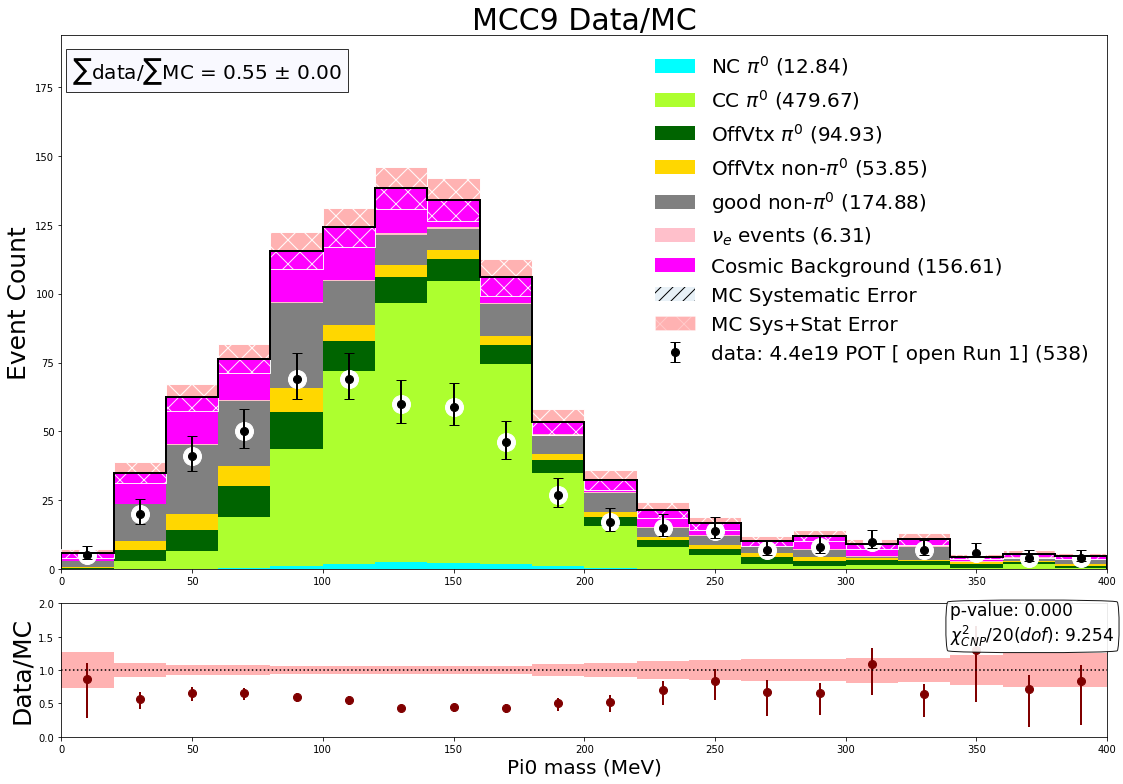

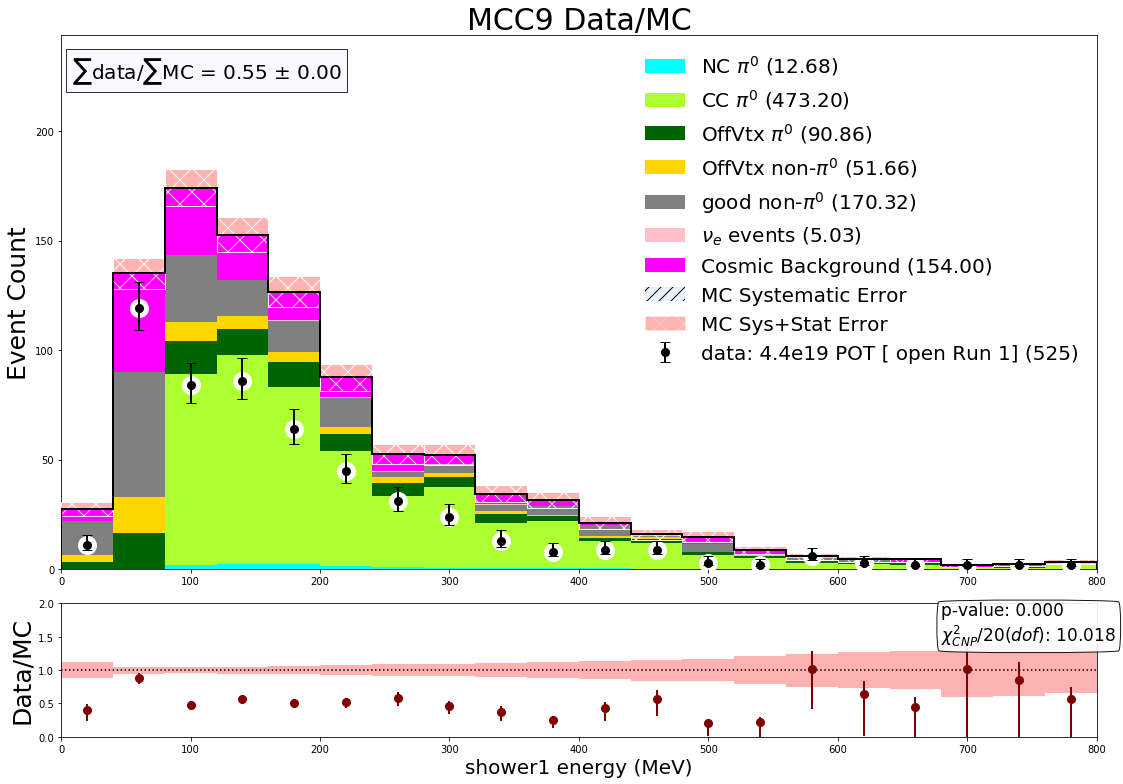

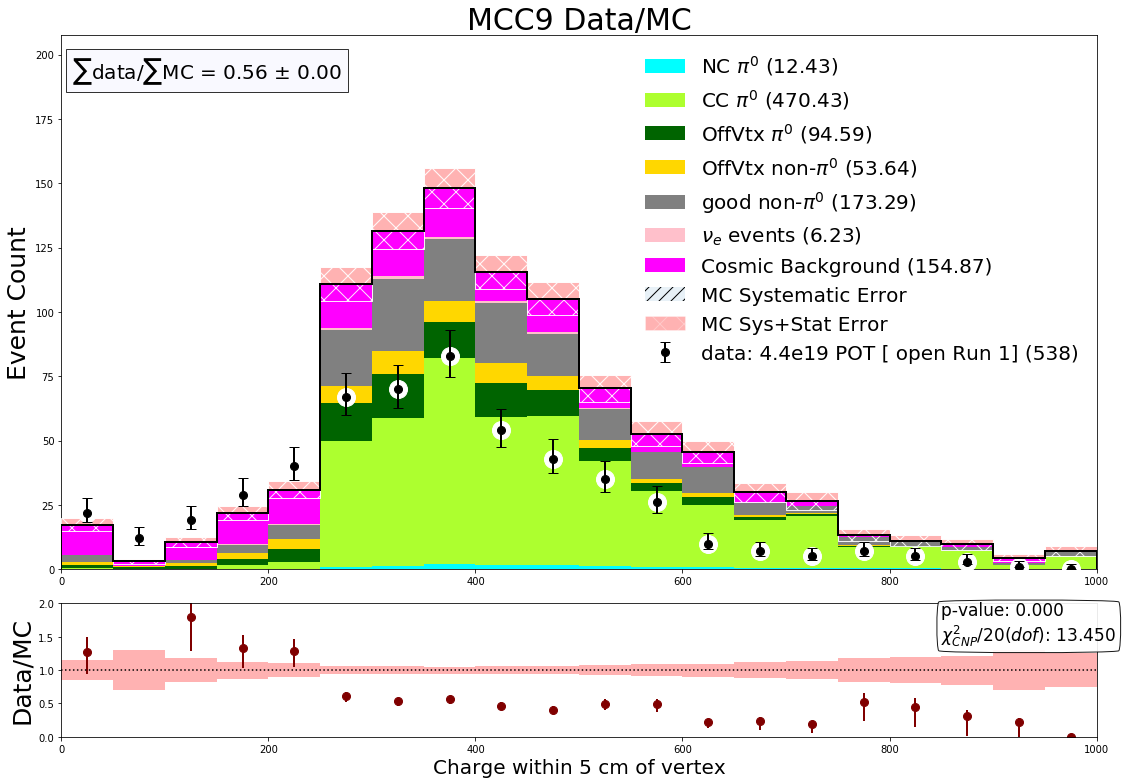

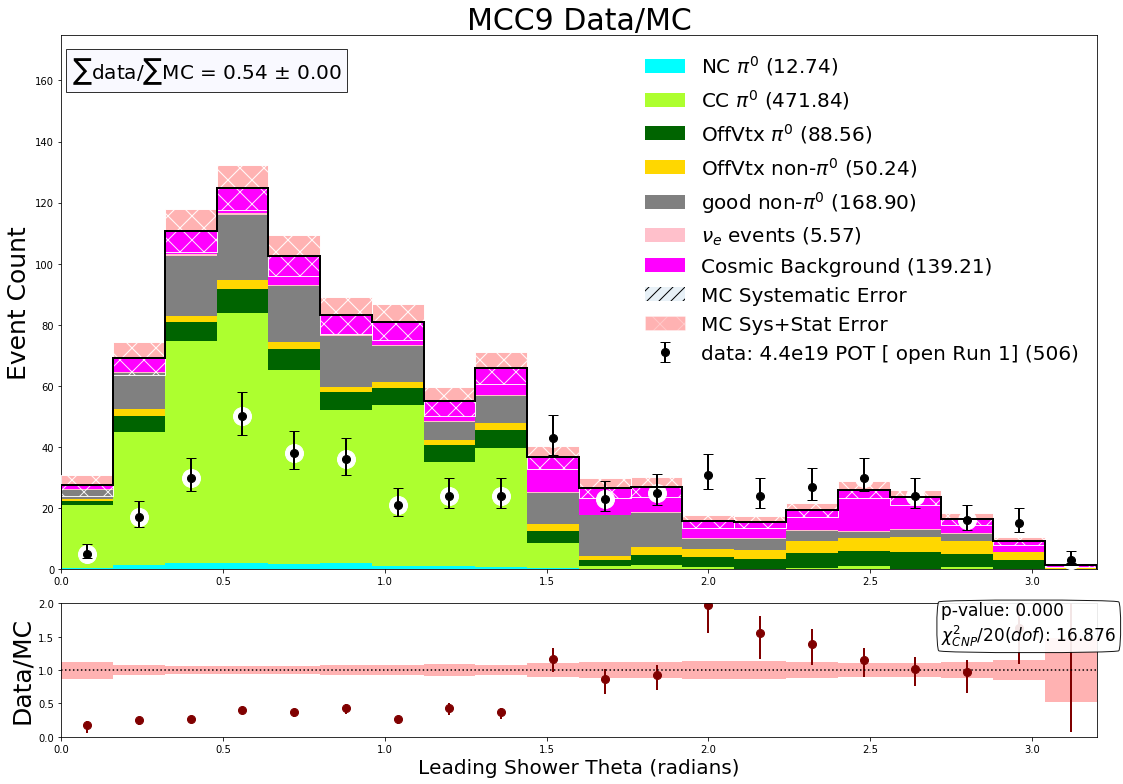

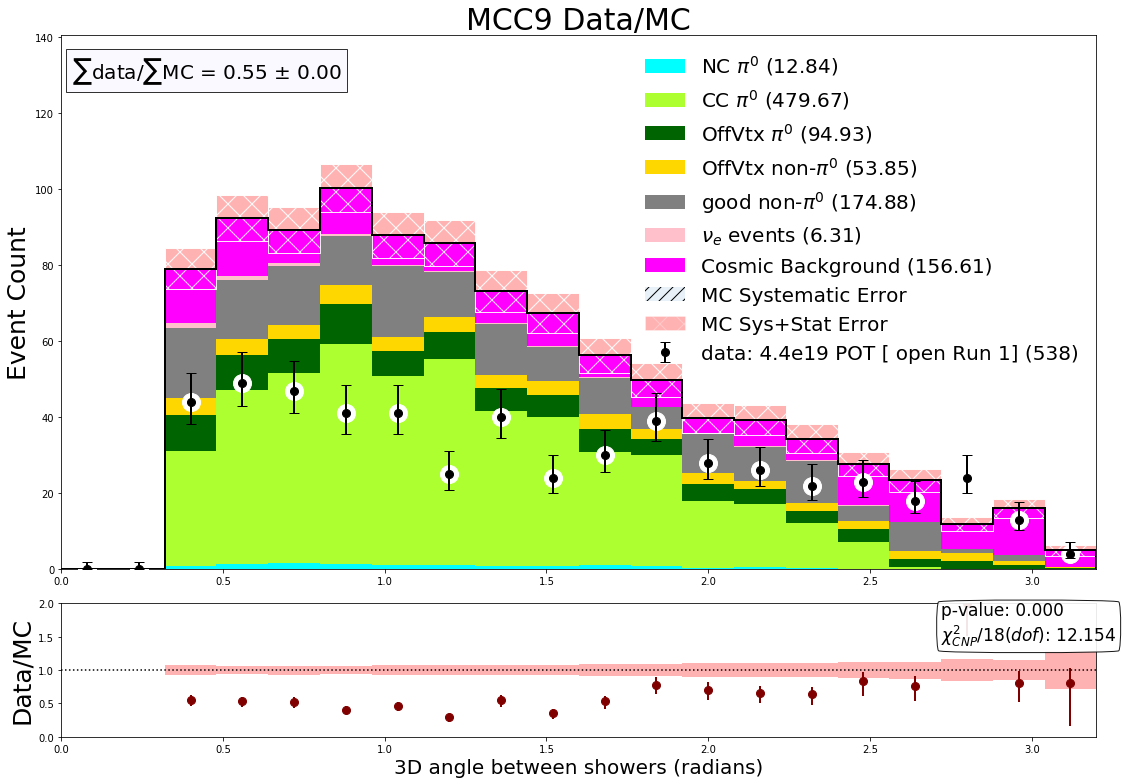

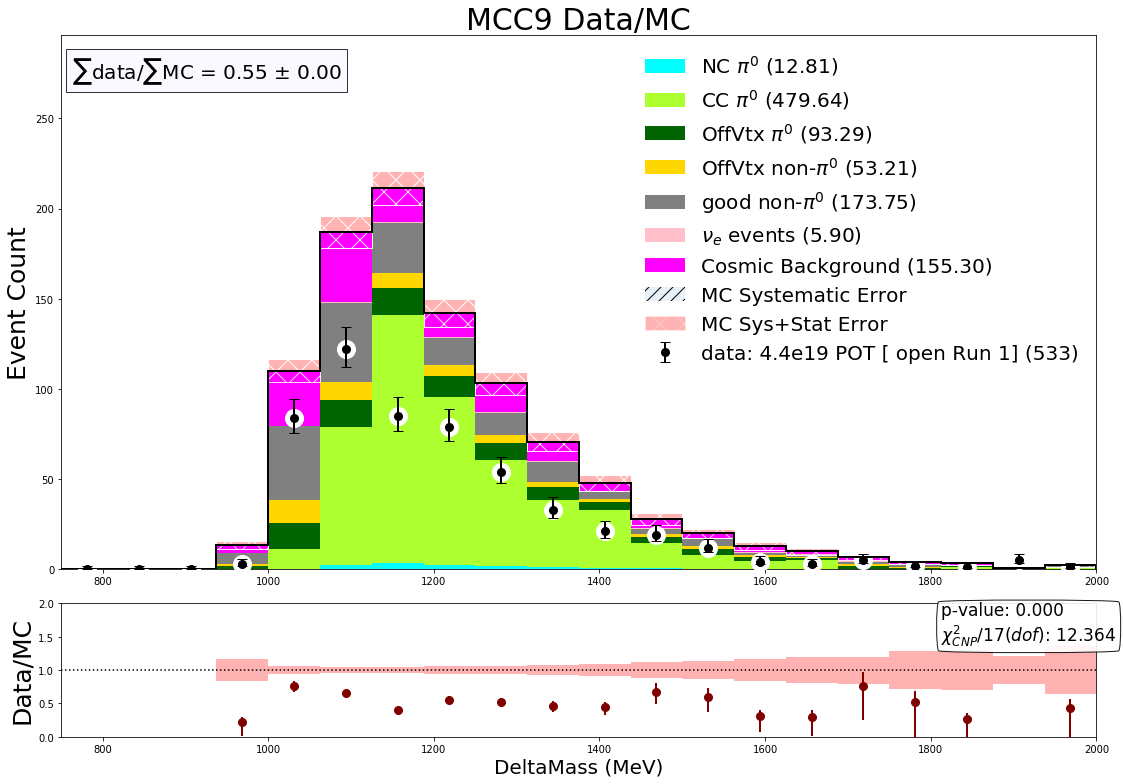

In [15]:
norm = 1.0
with PdfPages('output_preselection_210512.pdf') as pdf:

    for i in range(len(vartest_list)):
        vartest = vartest_list[i]
        varname = varname_list[i]
        myrange = myrange_list[i]
        nbins =bins_list[i]
        cov = np.zeros((nbins,nbins))
        
        run1_open_Hists = StackedHisto((df_bnb_ncpi0_pre,df_bnb_ccpi0_pre,df_bnb_ncpi0_offvtx_pre,df_bnb_ccpi0_offvtx_pre,df_bnb_other_offvtx_pre,df_bnb_other_good_pre,df_nue_pre),(NCPI0_R1_OPEN_SCALE*norm,NUMU_R1_OPEN_SCALE*norm,CCPI0_R1_OPEN_SCALE*norm,NCPI0_R1_OPEN_SCALE*norm,CCPI0_R1_OPEN_SCALE*norm,NUMU_R1_OPEN_SCALE*norm,NUE_R1_OPEN_SCALE*norm))
        run1_open_Hists.AddStrata('haspi0==1 and ccnc==1 and MC_scedr<5 ',r"NC $\pi^0$",'cyan')
        run1_open_Hists.AddStrata('haspi0==1 and ccnc!=1 and MC_scedr<5 ',r"CC $\pi^0$",'greenyellow')
        run1_open_Hists.AddStrata(' MC_scedr>=5 ',r"OffVtx $\pi^0$",'darkgreen')
        run1_open_Hists.AddStrata('haspi0==0 and MC_scedr>=5 ',r"OffVtx non-$\pi^0$",'gold')
        run1_open_Hists.AddStrata('haspi0==0 and MC_scedr<5',r"good non-$\pi^0$",'grey')
        run1_open_Hists.AddStrata('MC_parentPDG ==12',r"$\nu_e$ events",'pink')
        run1_open_Hists.AddLayer(df_ext_pre,EXT_R1_OPEN_SCALE*norm,0,'Cosmic Background','fuchsia')
        run1_open_DataHist = SimpleHisto(df_data_r1_open_pre,1.0,0,'','data: 4.4e19 POT [ open Run 1]')
        fig1,ax1,_,a = distplot_wratio_davio(vartest,nbins,myrange,run1_open_Hists,run1_open_DataHist,varname,m_cov=cov)

In [16]:
# plot all of the seperate pi0  distributions
vartest_list = []
varname_list = []
myrange_list = []
detvar_list  = []
sys_list = []
bins_list = []

vartest_list.append('_pi0mass')
varname_list.append('Pi0 mass (MeV)')
myrange_list.append((0.0,400.0))
# detvar_list.append('../systematics/detvar_pi0mass_cov.txt')
sys_list.append('none')
detvar_list.append('none')
bins_list.append(20)

vartest_list.append('DeltaMass_new')
varname_list.append('Delta mass (MeV)')
myrange_list.append((1000.0,1400.0))
detvar_list.append('none')
sys_list.append('none')
bins_list.append(10)

vartest_list.append('pi0_energy_reco_new')
varname_list.append('Pi0 Energy (MeV)')
myrange_list.append((100.0,800.0))
detvar_list.append('none')
sys_list.append('none')
bins_list.append(20)

vartest_list.append('pi0_momentum_reco_new')
varname_list.append('Pi0 Momentum (MeV)')
myrange_list.append((100.0,800.0))
detvar_list.append('none')
sys_list.append('none')
bins_list.append(20)

vartest_list.append('shower1_E_Y_new')
varname_list.append('shower1 energy (MeV)')
myrange_list.append((80.0,450.0))
detvar_list.append('none')
sys_list.append('none')
bins_list.append(20)

vartest_list.append('shower2_E_Y_new')
varname_list.append('shower2 energy (MeV)')
myrange_list.append((35.0,350.0))
detvar_list.append('none')
sys_list.append('none')
bins_list.append(20)


In [17]:
# norm = 1.0
# with PdfPages('output_201109.pdf') as pdf:

#     for i in range(len(vartest_list)):
#         vartest = vartest_list[i]
#         varname = varname_list[i]
#         myrange = myrange_list[i]
#         nbins =bins_list[i]
#         s_cov = np.zeros((nbins,nbins))
#         if detvar_list[i] == 'none':
#             d_cov = np.zeros((nbins,nbins))
#         else:
#             d_cov = np.genfromtxt(detvar_list[i],delimiter=',')


#         cov = np.zeros((nbins,nbins))
#         run1_pi0filter_Hists = StackedHisto((df_bnb_ncpi0,df_bnb_ccpi0,df_bnb_ncpi0_offvtx,df_bnb_ccpi0_offvtx,df_bnb_other_offvtx,df_bnb_other_good,df_nue_pi0),(NCPI0_R1_PI0FILTER_SCALE*norm,CCPI0_R1_PI0FILTER_SCALE*norm,NCPI0_R1_PI0FILTER_SCALE*norm,CCPI0_R1_PI0FILTER_SCALE*norm,NUMU_R1_PI0FILTER_SCALE*norm,NUMU_R1_PI0FILTER_SCALE*norm,NUE_R1_PI0FILTER_SCALE*norm))
#         run1_pi0filter_Hists.AddStrata('MC_parentPDG ==14 and haspi0==1 and ccnc==1 and MC_scedr<5 ',r"NC $\pi^0$",'cyan')
#         run1_pi0filter_Hists.AddStrata('MC_parentPDG ==14 and haspi0==1 and ccnc!=1 and MC_scedr<5 ',r"CC $\pi^0$",'greenyellow')
#         run1_pi0filter_Hists.AddStrata('haspi0==1 and ccnc==1 and MC_scedr>=5 ',r"OffVtx NC$\pi^0$",'darkblue')
#         run1_pi0filter_Hists.AddStrata('haspi0==1 and ccnc==0 and MC_scedr>=5 ',r"OffVtx CC$\pi^0$",'darkgreen')
#         run1_pi0filter_Hists.AddStrata('MC_parentPDG ==14 and haspi0==0 and MC_scedr>=5 ',r"OffVtx non-$\pi^0$",'gold')
#         run1_pi0filter_Hists.AddStrata('MC_parentPDG ==14 and haspi0==0 and MC_scedr<5',r"good non-$\pi^0$",'grey')
#         run1_pi0filter_Hists.AddStrata('MC_parentPDG ==12',r"$\nu_e$ events",'pink')
#         run1_pi0filter_Hists.AddLayer(df_ext_pi0,EXT_R1_PI0FILTER_SCALE*norm,0,'Cosmic Background','fuchsia')
#         run1_pi0filter_DataHist = SimpleHisto(df_data_r1_pi0filter_pi0,1.0,0,'','data: 1.7e20 POT [ pi0filter Run 1]')
#         fig3,ax3,_,a = distplot_wratio_davio(vartest,nbins,myrange,run1_pi0filter_Hists,run1_pi0filter_DataHist,varname,m_cov=cov)

# #         cov = np.zeros((nbins,nbins))
# #         run2D_pi0filter_Hists = StackedHisto((df_bnb_ncpi0_r2,df_bnb_ccpi0_r2,df_bnb_pi0_offvtx_r2,df_bnb_other_offvtx_r2,df_bnb_other_good_r2,df_nue_r2_pi0),(NUMU_R2D_1MIL_PI0FILTER_SCALE*norm,NUMU_R2D_1MIL_PI0FILTER_SCALE*norm,NUMU_R2D_1MIL_PI0FILTER_SCALE*norm,NUMU_R2D_1MIL_PI0FILTER_SCALE*norm,NUMU_R2D_1MIL_PI0FILTER_SCALE*norm,NUE_R2D_PI0FILTER_SCALE*norm))
# #         run2D_pi0filter_Hists.AddStrata('haspi0==1 and ccnc==1 and MC_scedr<5 ',r"NC $\pi^0$",'cyan')
# #         run2D_pi0filter_Hists.AddStrata('haspi0==1 and ccnc!=1 and MC_scedr<5 ',r"CC $\pi^0$",'greenyellow')
# #         run2D_pi0filter_Hists.AddStrata('haspi0==1 and MC_scedr>=5 ',r"OffVtx $\pi^0$",'darkgreen')
# #         run2D_pi0filter_Hists.AddStrata('haspi0==0 and MC_scedr>=5 ',r"OffVtx non-$\pi^0$",'gold')
# #         run2D_pi0filter_Hists.AddStrata('haspi0==0 and MC_scedr<5',r"good non-$\pi^0$",'grey')
# #         run2D_pi0filter_Hists.AddStrata('MC_parentPDG ==12',r"$\nu_e$ events",'pink')
# #         run2D_pi0filter_Hists.AddLayer(df_ext_r3_pi0,EXT_R2D_PI0FILTER_SCALE*norm,0,'Cosmic Background','fuchsia')
# #         run2D_pi0filter_DataHist = SimpleHisto(df_data_r2D_pi0filter_pi0,1.0,0,'','data: 2.05e20 POT [ pi0filter Run 2D]')
# #         fig4,ax4,_,a = distplot_wratio_davio(vartest,nbins,myrange,run2D_pi0filter_Hists,run2D_pi0filter_DataHist,varname,m_cov=cov)
        
# #         cov = np.zeros((nbins,nbins))
# #         run2E_pi0filter_Hists = StackedHisto((df_bnb_ncpi0_r2,df_bnb_ccpi0_r2,df_bnb_pi0_offvtx_r2,df_bnb_other_offvtx_r2,df_bnb_other_good_r2,df_nue_r2_pi0),(NUMU_R2E_1MIL_PI0FILTER_SCALE*norm,NUMU_R2E_1MIL_PI0FILTER_SCALE*norm,NUMU_R2E_1MIL_PI0FILTER_SCALE*norm,NUMU_R2E_1MIL_PI0FILTER_SCALE*norm,NUMU_R2E_1MIL_PI0FILTER_SCALE*norm,NUE_R2E_PI0FILTER_SCALE*norm))
# #         run2E_pi0filter_Hists.AddStrata('haspi0==1 and ccnc==1 and MC_scedr<5 ',r"NC $\pi^0$",'cyan')
# #         run2E_pi0filter_Hists.AddStrata('haspi0==1 and ccnc!=1 and MC_scedr<5 ',r"CC $\pi^0$",'greenyellow')
# #         run2E_pi0filter_Hists.AddStrata('haspi0==1 and MC_scedr>=5 ',r"OffVtx $\pi^0$",'darkgreen')
# #         run2E_pi0filter_Hists.AddStrata('haspi0==0 and MC_scedr>=5 ',r"OffVtx non-$\pi^0$",'gold')
# #         run2E_pi0filter_Hists.AddStrata('haspi0==0 and MC_scedr<5',r"good non-$\pi^0$",'grey')
# #         run2E_pi0filter_Hists.AddStrata('MC_parentPDG ==12',r"$\nu_e$ events",'pink')
# #         run2E_pi0filter_Hists.AddLayer(df_ext_r3_pi0,EXT_R2E_PI0FILTER_SCALE*norm,0,'Cosmic Background','fuchsia')
# #         run2E_pi0filter_DataHist = SimpleHisto(df_data_r2E_pi0filter_pi0,1.0,0,'','data: 6.51e19 POT [ pi0filter Run 2E]')
# #         fig5,ax5,_,a = distplot_wratio_davio(vartest,nbins,myrange,run2E_pi0filter_Hists,run2E_pi0filter_DataHist,varname,m_cov=cov)

# #         cov = np.zeros((nbins,nbins))
# #         run3F_pi0filter_Hists = StackedHisto((df_bnb_ncpi0_r3,df_bnb_ccpi0_r3,df_bnb_pi0_offvtx_r3,df_bnb_other_offvtx_r3,df_bnb_other_good_r3,df_nue_r3_pi0),(NUMU_R3F_PI0FILTER_SCALE*norm,NUMU_R3F_PI0FILTER_SCALE*norm,NUMU_R3F_PI0FILTER_SCALE*norm,NUMU_R3F_PI0FILTER_SCALE*norm,NUMU_R3F_PI0FILTER_SCALE*norm,NUE_R3F_PI0FILTER_SCALE*norm))
# #         run3F_pi0filter_Hists.AddStrata('haspi0==1 and ccnc==1 and MC_scedr<5 ',r"NC $\pi^0$",'cyan')
# #         run3F_pi0filter_Hists.AddStrata('haspi0==1 and ccnc!=1 and MC_scedr<5 ',r"CC $\pi^0$",'greenyellow')
# #         run3F_pi0filter_Hists.AddStrata('haspi0==1 and MC_scedr>=5 ',r"OffVtx $\pi^0$",'darkgreen')
# #         run3F_pi0filter_Hists.AddStrata('haspi0==0 and MC_scedr>=5 ',r"OffVtx non-$\pi^0$",'gold')
# #         run3F_pi0filter_Hists.AddStrata('haspi0==0 and MC_scedr<5',r"good non-$\pi^0$",'grey')
# #         run3F_pi0filter_Hists.AddStrata('MC_parentPDG ==12',r"$\nu_e$ events",'pink')
# #         run3F_pi0filter_Hists.AddLayer(df_ext_r3_pi0,EXT_R3F_PI0FILTER_SCALE*norm,0,'Cosmic Background','fuchsia')
# #         run3F_pi0filter_DataHist = SimpleHisto(df_data_r3F_pi0filter_pi0,1.0,0,'','data: 4.3e19 POT [ pi0filter Run 3F]')
# #         fig6,ax6,_,a = distplot_wratio_davio(vartest,nbins,myrange,run3F_pi0filter_Hists,run3F_pi0filter_DataHist,varname,m_cov=cov)

#         cov = np.zeros((nbins,nbins))
#         run3G_pi0filter_Hists = StackedHisto((df_bnb_ncpi0_r3,df_bnb_ccpi0_r3,df_bnb_ccpi0_offvtx_r3,df_bnb_ccpi0_offvtx_r3df_bnb_other_offvtx_r3,df_bnb_other_good_r3,df_nue_r3_pi0),(NUMU_R3G_PI0FILTER_SCALE*norm,NUMU_R3G_PI0FILTER_SCALE*norm,NUMU_R3G_PI0FILTER_SCALE*norm,NUMU_R3G_PI0FILTER_SCALE*norm,NUMU_R3G_PI0FILTER_SCALE*norm,NUE_R3G_PI0FILTER_SCALE*norm))
#         run3G_pi0filter_Hists.AddStrata('haspi0==1 and ccnc==1 and MC_scedr<5 ',r"NC $\pi^0$",'cyan')
#         run3G_pi0filter_Hists.AddStrata('haspi0==1 and ccnc!=1 and MC_scedr<5 ',r"CC $\pi^0$",'greenyellow')
#         run3G_pi0filter_Hists.AddStrata('haspi0==1 and MC_scedr>=5 ',r"OffVtx $\pi^0$",'darkgreen')
#         run3G_pi0filter_Hists.AddStrata('haspi0==0 and MC_scedr>=5 ',r"OffVtx non-$\pi^0$",'gold')
#         run3G_pi0filter_Hists.AddStrata('haspi0==0 and MC_scedr<5',r"good non-$\pi^0$",'grey')
#         run3G_pi0filter_Hists.AddStrata('MC_parentPDG ==12',r"$\nu_e$ events",'pink')
#         run3G_pi0filter_Hists.AddLayer(df_ext_r3_pi0,EXT_R3G_PI0FILTER_SCALE*norm,0,'Cosmic Background','fuchsia')
#         run3G_pi0filter_DataHist = SimpleHisto(df_data_r3G_pi0filter_pi0,1.0,0,'','data: 2e20 [ pi0filter Run 3G]')
#         fig7,ax7,_,a = distplot_wratio_davio(vartest,nbins,myrange,run3G_pi0filter_Hists,run3G_pi0filter_DataHist,varname,m_cov=cov)
        
#         #save to pdf file of plots
#         pdf.savefig(fig1)
#         pdf.savefig(fig3)
#         pdf.savefig(fig4)
#         pdf.savefig(fig5)
# #         pdf.savefig(fig6)
# #         pdf.savefig(fig7)

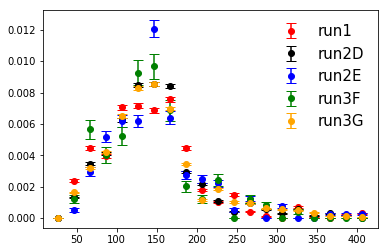

In [18]:
# Make data plots, normalized
# checking to see if any bins look realyl off
var_r1 = df_data_r1_pi0filter_pi0["_pi0mass_new"].values
var_r2D = df_data_r2D_pi0filter_pi0["_pi0mass_new"].values
var_r2E = df_data_r2E_pi0filter_pi0["_pi0mass_new"].values
var_r3F = df_data_r3F_pi0filter_pi0["_pi0mass_new"].values
var_r3G = df_data_r3G_pi0filter_pi0["_pi0mass_new"].values

# turn into histograms
r1_Hist,binedges = np.histogram( var_r1, bins = 20, range = [0,400],density = True)
bincenters = np.ones(len(binedges)-1)
for i in range(len(binedges)-1):
    bincenters[i] = binedges[i]+(400.0/15.0)
    
r2D_Hist,_ = np.histogram( var_r2D, bins = 20, range = [0,400],density = True)
r2E_Hist,_ = np.histogram( var_r2E, bins = 20, range = [0,400],density = True)
r3F_Hist,_ = np.histogram( var_r3F, bins = 20, range = [0,400],density = True)
r3G_Hist,_ = np.histogram( var_r3G, bins = 20, range = [0,400],density = True)

err_1 = [sqrt(float(i))/float(len(var_r1)) for i in r1_Hist]
err_2d = [sqrt(float(i))/float(len(var_r2D)) for i in r2D_Hist]
err_2e = [sqrt(float(i))/float(len(var_r2E)) for i in r2E_Hist]
err_3f = [sqrt(float(i))/float(len(var_r3F)) for i in r3F_Hist]
err_3g = [sqrt(float(i))/float(len(var_r3G)) for i in r3G_Hist]


plt.errorbar(bincenters,r1_Hist, yerr=err_1,  fmt='o', color = 'red', ecolor='red', capsize=5,label = 'run1')
plt.errorbar(bincenters,r2D_Hist, yerr=err_2d,  fmt='o', color = 'black', ecolor='black', capsize=5,label = 'run2D')
plt.errorbar(bincenters,r2E_Hist, yerr=err_2e,  fmt='o', color = 'blue', ecolor='blue', capsize=5,label = 'run2E')
plt.errorbar(bincenters,r3F_Hist, yerr=err_3f,  fmt='o', color = 'green', ecolor='green', capsize=5,label = 'run3F')
plt.errorbar(bincenters,r3G_Hist, yerr=err_3g,  fmt='o', color = 'orange', ecolor='orange', capsize=5,label = 'run3G')

plt.legend(loc='upper right',fontsize=15,frameon=False,ncol=1)
plt.show()
plt.close()

# Make "DPF plots"

In [19]:
# # list of variables to plot:
# vars = ['Xreco','Yreco','Zreco','OpenAng','Thetas','Phis','ChargeNearTrunk','Enu_1e1p','PhiT_1e1p','AlphaT_1e1p','PT_1e1p','PTRat_1e1p','BjXB_1e1p','BjYB_1e1p','Q2_1e1p','SphB_1e1p','Q0_1e1p','Q3_1e1p','Lepton_PhiReco','Lepton_ThetaReco','Lepton_TrackLength','Muon_Edep','Proton_PhiReco','Proton_ThetaReco','Proton_TrackLength','Proton_Edep','Proton_CosTheta','Lepton_CosTheta']
# # list of ranges
# ranges = [(15,241.25),(-101.5,101.),(15,1021.8),(.6,2.8),(0,6.3),(1.5,4),(0,600),(200,1200),(0,1),(0,np.pi),(0,320),(0,1),(0,1.8),(0.05,.75),(0,6e5),(0,1200),(70,600),(200,1000),(-np.pi,np.pi),(.2,2.8),(20,200),(50,600),(-np.pi,np.pi),(0,2),(5,100),(50,500),(-1,1),(-1,1),]
# print(vars)
# print(ranges)
# nbins =20

# for i in range(len(vars)):
#     vartest = vars[i]
#     varname = vars[i]
#     myrange = ranges[i]
#     norm = len(df_data_r1_pi0filter_pi0)/(len(df_numu_pi0)*NUMU_R1_PI0FILTER_SCALE+ len(df_nue_pi0)*NUE_R1_PI0FILTER_SCALE +len(df_ext_pi0)*EXT_R1_PI0FILTER_SCALE)
#     print("Norm", norm)
#     run1Hists = StackedHisto((df_bnb_ncpi0,df_bnb_ccpi0,df_bnb_pi0_offvtx,df_bnb_other_offvtx,df_bnb_other_good,df_nue_pi0),(NUMU_R1_PI0FILTER_SCALE*norm,NUMU_R1_PI0FILTER_SCALE*norm,NUMU_R1_PI0FILTER_SCALE*norm,NUMU_R1_PI0FILTER_SCALE*norm,NUMU_R1_PI0FILTER_SCALE*norm,NUE_R1_PI0FILTER_SCALE*norm))
#     run1Hists.AddStrata('haspi0==1 and ccnc==1 and MC_scedr<5 ',r"NC $\pi^0$",'cyan')
#     run1Hists.AddStrata('haspi0==1 and ccnc!=1 and MC_scedr<5 ',r"CC $\pi^0$",'greenyellow')
#     run1Hists.AddStrata('haspi0==1 and MC_scedr>=5 ',r"OffVtx $\pi^0$",'darkgreen')
#     run1Hists.AddStrata('haspi0==0 and MC_scedr>=5 ',r"OffVtx non-$\pi^0$",'gold')
#     run1Hists.AddStrata('haspi0==0 and MC_scedr<5',r"good non-$\pi^0$",'grey')
#     run1Hists.AddStrata('MC_parentPDG ==12',r"$\nu_e$ events",'pink')
#     run1Hists.AddLayer(df_ext_pi0,EXT_R1_PI0FILTER_SCALE*norm,0,'Cosmic Background','fuchsia')
#     run1DataHist = SimpleHisto(df_data_r1_pi0filter_pi0,1.0,0,'','data: 1.7e20 POT [Run 1]')
#     cov = np.zeros((nbins,nbins))
#     fig,ax0,_ ,a= distplot_wratio_davio(vartest,nbins,myrange,run1Hists,run1DataHist,varname,m_cov=cov)

# Start of combined plots...

In [20]:
# add all of the data frames
# df_data_total = df_fakedata1_run1_pi0.append(df_fakedata1_run3_pi0)
df_data_total_1 = df_data_r1_pi0filter_pi0.append(df_data_r2D_pi0filter_pi0)
df_data_total_2 = df_data_total_1.append(df_data_r2E_pi0filter_pi0)
df_data_total_3 = df_data_total_2.append(df_data_r3F_pi0filter_pi0)
df_data_total = df_data_total_3.append(df_data_r3G_pi0filter_pi0)

print("total number of data pi0: ",len(df_data_total['_pi0mass'].values))
# scale CV weights:
def potscale(df,scalefactor=1.0,ext=False):
    pot_weight = []
    for i in range(len(df)):
        if ext==False:
            pot_weight.append(scalefactor)
        else:
            pot_weight.append(scalefactor)
    return pot_weight

# general mc
w_mu_1 =potscale(df_numu_pi0,DATA_R1_PI0FILTER_POT/NUMU_R1_POT)
w_mu_1_1mil =potscale(df_numu_1mil_pi0,DATA_R1_PI0FILTER_POT/NUMU_R1_1MIL_POT)
w_mu_2 =potscale(df_numu_r2_pi0,(DATA_R2D_PI0FILTER_POT+DATA_R2E_PI0FILTER_POT)/NUMU_R2_POT)
w_mu_2_1mil =potscale(df_numu_r2_1mil_pi0,(DATA_R2D_PI0FILTER_POT+DATA_R2E_PI0FILTER_POT)/NUMU_R2_1MIL_POT)
w_mu_3 =potscale(df_numu_r3_pi0,(DATA_R3F_PI0FILTER_POT+DATA_R3G_PI0FILTER_POT)/NUMU_R3_POT)
df_numu_pi0['pot_weight'] = w_mu_1
df_numu_1mil_pi0['pot_weight'] = w_mu_1_1mil
df_numu_r2_pi0['pot_weight'] = w_mu_2
df_numu_r2_1mil_pi0['pot_weight'] = w_mu_2_1mil
df_numu_r3_pi0['pot_weight'] = w_mu_3

# df_numu_total_1 = df_numu_pi0.append(df_numu_r2_pi0)
df_numu_total_1 = df_numu_1mil_pi0.append(df_numu_r2_1mil_pi0)
df_numu_total = df_numu_total_1.append(df_numu_r3_pi0)

w_e_1 =potscale(df_nue_pi0,DATA_R1_PI0FILTER_POT/NUE_R1_POT)
w_e_2 =potscale(df_nue_r2_pi0,(DATA_R2D_PI0FILTER_POT+DATA_R2E_PI0FILTER_POT)/NUE_R2_POT)
w_e_3 =potscale(df_nue_r3_pi0,(DATA_R3F_PI0FILTER_POT+DATA_R3G_PI0FILTER_POT)/NUE_R3_POT)
df_nue_pi0['pot_weight'] = w_e_1
df_nue_r2_pi0['pot_weight'] = w_e_2
df_nue_r3_pi0['pot_weight'] = w_e_3
df_nue_total_1 = df_nue_pi0.append(df_nue_r2_pi0)
df_nue_total = df_nue_total_1.append(df_nue_r3_pi0)
print('xsec_corr_weight' in df_nue_total.keys())


df_ext_r3_2_pi0 = df_ext_r3_pi0
df_ext_r3_3_pi0 = df_ext_r3_pi0
w_ext_1 =potscale(df_ext_pi0,DATA_R1_PI0FILTER_POT/EXT_R1_PI0FILTER_POT,True)
w_ext_2 =potscale(df_ext_r3_2_pi0,(DATA_R2D_PI0FILTER_POT+DATA_R2E_PI0FILTER_POT)/(EXT_R2D_PI0FILTER_POT+EXT_R2E_PI0FILTER_POT),True)
w_ext_3 =potscale(df_ext_r3_3_pi0,(DATA_R3F_PI0FILTER_POT+DATA_R3G_PI0FILTER_POT)/(EXT_R3F_PI0FILTER_POT+EXT_R3G_PI0FILTER_POT),True)
df_ext_pi0['pot_weight'] = w_ext_1
df_ext_r3_2_pi0['pot_weight'] = w_ext_2
df_ext_r3_2_pi0['pot_weight'] = w_ext_3
df_ext_total_1 = df_ext_pi0.append(df_ext_r3_2_pi0)
df_ext_total = df_ext_total_1.append(df_ext_r3_3_pi0)

# df_bnb_ncpi0_r2 = df_numu_r2_pi0.query('haspi0==1 and ccnc==1 and MC_scedr<5 and MC_parentPDG ==14')
# df_bnb_ccpi0_r2 = df_numu_r2_pi0.query("haspi0==1 and ccnc!=1 and MC_scedr<5 and MC_parentPDG ==14")

# df_bnb_offvtx_pi0_r2 = df_numu_r2_pi0.query("haspi0==1 and  MC_scedr>=5 and MC_parentPDG ==14")
# w_off_2 =potscale(df_bnb_offvtx_pi0_r2,(DATA_R2D_PI0FILTER_POT+DATA_R2E_PI0FILTER_POT)/NUMU_R2_POT)
# df_bnb_offvtx_pi0_r2['pot_weight'] = w_off_2

w_cc_1 =potscale(df_ccpi0_r1_pi0,DATA_R1_PI0FILTER_POT/CCPI0_R1_POT)
w_cc_3 =potscale(df_ccpi0_r3_pi0,(DATA_R3G_PI0FILTER_POT+DATA_R3F_PI0FILTER_POT)/(CCPI0_R3_POT))
w_cc_2 =potscale(df_ccpi0_r3_pi0,(DATA_R2D_PI0FILTER_POT+DATA_R2E_PI0FILTER_POT)/(CCPI0_R3_POT))
df_ccpi0_r1_pi0['pot_weight'] = w_cc_1
df_ccpi0_r3_pi0['pot_weight'] = w_cc_3
df_ccpi0_r2_pi0 = df_ccpi0_r3_pi0
df_ccpi0_r2_pi0['pot_weight'] = w_cc_2
df_ccpi0_total1 = df_ccpi0_r1_pi0.append(df_ccpi0_r2_pi0)
df_ccpi0_total = df_ccpi0_total1.append(df_ccpi0_r3_pi0)

w_nc_1 =potscale(df_ncpi0_r1_pi0,DATA_R1_PI0FILTER_POT/NCPI0_R1_POT)
w_nc_3 =potscale(df_ncpi0_r3_pi0,(DATA_R3G_PI0FILTER_POT+DATA_R3F_PI0FILTER_POT)/(NCPI0_R3a_POT+NCPI0_R3b_POT))
w_nc_2 =potscale(df_ncpi0_r3_pi0,(DATA_R2D_PI0FILTER_POT+DATA_R2E_PI0FILTER_POT)/(NCPI0_R3a_POT+NCPI0_R3b_POT))
df_ncpi0_r1_pi0['pot_weight'] = w_nc_1
df_ncpi0_r3_pi0['pot_weight'] = w_nc_3
df_ncpi0_r2_pi0 = df_ncpi0_r3_pi0
df_ncpi0_r2_pi0['pot_weight'] = w_nc_2
df_ncpi0_total1 = df_ncpi0_r1_pi0.append(df_ncpi0_r2_pi0)
df_ncpi0_total = df_ncpi0_total1.append(df_ncpi0_r3_pi0)

n=float(len(df_numu_total.query('newhaspi0==1') ))
print(sqrt(n)/n)
a = float(len(df_ncpi0_total)+len(df_ccpi0_total))
print(sqrt(a))
print(abs((234+1028+462)-(242+1039+472))/(234+1028+462))
                 
# tot1 = 0
# for i in range(len(df_numu_total)):
#     tot1+=df_numu_total['pot_weight'].values[i]*df_numu_total['xsec_corr_weight'].values[i]
# tot2 = 0
# for i in range(len(df_nue_total)):
#     tot2+=df_nue_total['pot_weight'].values[i]*df_nue_total['xsec_corr_weight'].values[i]
# print(tot1+tot2)
# tot3 = 0
# for i in range(len(df_ext_total)):
#     tot3+=df_ext_total['pot_weight'].values[i]
# print(tot3)


# # #specific categories
# df_bnb_ncpi0_total = df_numu_total.query('MC_parentPDG ==14 and haspi0==1 and ccnc==1 and MC_scedr<5 ')
# tot4 = 0
# for i in range(len(df_bnb_ncpi0_total)):
#     tot4+=df_bnb_ncpi0_total['pot_weight'].values[i]*df_bnb_ncpi0_total['xsec_corr_weight'].values[i]
# print(tot4)
                 
# df_bnb_ccpi0_total = df_ccpi0_total.query(" MC_scedr<5 ") 
# df_bnb_ncpi0_total = df_ncpi0_total.query(" MC_scedr<5 ") 
# df_bnb_ccpi0_offvtx_total = df_ccpi0_total.query("MC_scedr>=5 ") 
# df_bnb_ncpi0_offvtx_total = df_ncpi0_total.query("MC_scedr>=5 ") 
# df_bnb_other_offvtx_total = df_numu_total.query("haspi0==0 and MC_scedr>=5 ")
# df_bnb_other_good_total = df_numu_total.query("haspi0==0 and MC_scedr<5")



# print(df_numu_pi0['xsec_corr_weight'].values)

total number of data pi0:  2217
True


/home/kmason/.local/lib/python3.5/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


0.011174056247636599
81.39410298049853
0.016821345707656612


In [21]:
NUMU_POT_TOTAL = NUMU_R1_1MIL_POT+NUMU_R2_1MIL_POT+NUMU_R3_POT
NUE_POT_TOTAL = NUE_R1_POT+NUE_R2_POT+NUE_R3_POT
EXT_POT_TOTAL = EXT_R1_PI0FILTER_POT+EXT_R2D_PI0FILTER_POT+EXT_R2E_PI0FILTER_POT+EXT_R3F_PI0FILTER_POT+EXT_R3G_PI0FILTER_POT
CCPI0_POT_TOTAL = CCPI0_R1_POT+CCPI0_R3_POT
NCPI0_POT_TOTAL = NCPI0_R1_POT+NCPI0_R3a_POT+NCPI0_R3b_POT

# DATA_POT_TOTAL = FAKE_DATA_1_RUN1_POT + FAKE_DATA_1_RUN3_POT
DATA_POT_TOTAL = DATA_R1_PI0FILTER_POT+ DATA_R2D_PI0FILTER_POT+ DATA_R2E_PI0FILTER_POT+ DATA_R3F_PI0FILTER_POT+ DATA_R3G_PI0FILTER_POT
DATA_R2_POT_TOTAL = DATA_R2D_PI0FILTER_POT+ DATA_R2E_PI0FILTER_POT
print("pot total:",DATA_POT_TOTAL)
POT_SCALE_FACTOR = DATA_POT_TOTAL
NUMU_SCALE_TOTAL = POT_SCALE_FACTOR / float(NUMU_POT_TOTAL)
NUE_SCALE_TOTAL = POT_SCALE_FACTOR / float(NUE_POT_TOTAL)
CCPI0_SCALE_TOTAL =POT_SCALE_FACTOR / float(CCPI0_POT_TOTAL)
NCPI0_SCALE_TOTAL = POT_SCALE_FACTOR / float(NCPI0_POT_TOTAL)
EXT_SCALE_TOTAL = POT_SCALE_FACTOR / float(EXT_POT_TOTAL)
DATA_SCALE_TOTAL = POT_SCALE_FACTOR / float(DATA_POT_TOTAL)
print(CCPI0_SCALE_TOTAL)

# make some lists of bin values:
numu_test=df_numu_total.query('(newhaspi0==0 and MC_parentPDG ==14) or MC_parentPDG ==-14')
var_numu=numu_test['_pi0mass_new'].values
weights_numu =[numu_test['pot_weight'].values[i]*numu_test['xsec_corr_weight'].values[i] for i in range(len(var_numu))]
numu_Hist,_ = np.histogram( var_numu, bins = 20, range = [30,300],weights=weights_numu)

nue_test=df_nue_total.query('MC_parentPDG ==12')
var_nue=nue_test['_pi0mass_new'].values
weights_nue =[nue_test['pot_weight'].values[i]*nue_test['xsec_corr_weight'].values[i] for i in range(len(var_nue))]
nue_Hist,_ = np.histogram( var_nue, bins = 20, range = [30,300],weights=weights_nue)

ccpi0_test=df_ccpi0_total
var_ccpi0=ccpi0_test['_pi0mass_new'].values
weights_ccpi0 =[ccpi0_test['pot_weight'].values[i]*ccpi0_test['xsec_corr_weight'].values[i] for i in range(len(var_ccpi0))]
ccpi0_Hist,_ = np.histogram( var_ccpi0, bins = 20, range = [30,300],weights=weights_ccpi0)

ncpi0_test=df_ncpi0_total
var_ncpi0=ncpi0_test['_pi0mass_new'].values
weights_ncpi0 =[ncpi0_test['pot_weight'].values[i]*ncpi0_test['xsec_corr_weight'].values[i] for i in range(len(var_ncpi0))]
ncpi0_Hist,_ = np.histogram( var_ncpi0, bins = 20, range = [30,300],weights=weights_ncpi0)

ext_test=df_ext_total
var_ext=ext_test['_pi0mass_new'].values
weights_ext =[ext_test['pot_weight'].values[i] for i in range(len(var_ext))]
ext_Hist,_ = np.histogram( var_ext, bins = 20, range = [30,300],weights=weights_ext)

data_test=df_data_total
var_data=data_test['_pi0mass_new'].values
data_Hist,_ = np.histogram( var_data, bins = 20, range = [30,300])

def GetErrorsData(xobs,CL=0.6827):
    step    = 0.01
    upperBoundary = int(max(10,xobs+5*np.sqrt(xobs)))
    r = np.arange(0.01,upperBoundary,step)
    s    = PmuGivenX(r,xobs)*step
    PDF1 = interp1d(r,s,bounds_error=False,fill_value=0)
    PPF1 = interp1d(np.cumsum(s),r)
    xobs_low  = float(PPF1((1-CL)/2))
    xobs_high = float(PPF1(1-(1-CL)/2))
    return xobs_low,xobs_high

errdatalow=[]
errdatahigh=[]

for i in range(20):
    elow,ehigh=GetErrorsData(data_Hist[i])
    errdatalow.append(data_Hist[i] -elow)
    errdatahigh.append(ehigh-data_Hist[i])

numu = []
ext = []
total = []

for i in range(20):
    numu.append(numu_Hist[i]+nue_Hist[i]+ccpi0_Hist[i]+ncpi0_Hist[i])
    ext.append(ext_Hist[i])
    total.append(numu_Hist[i]+nue_Hist[i]+ccpi0_Hist[i]+ncpi0_Hist[i]+ext_Hist[i])
    
print(numu,sum(numu))
print(ext,sum(ext))
print(total,sum(total))
print(data_Hist,sum(data_Hist))
print(errdatalow)
print(errdatahigh)

pot total: 6.671e+20
0.5181129845125303
[46.92026435259562, 69.4839810394536, 96.43651681240496, 139.66851827660946, 168.85360626477967, 235.19872913253727, 244.90576452813178, 259.0314799199309, 255.76929665870392, 181.17266876868865, 94.62163596586491, 55.193247986490185, 46.406741444991646, 32.74252345448448, 23.99233225142288, 18.798908293660883, 11.45365302048255, 13.089072214627649, 10.400486548780457, 18.58514205096421] 2022.7245689856054
[19.775608128231784, 21.639849546153755, 20.5249669699653, 36.955927369631716, 28.365767748931752, 40.68441020547566, 19.02624928649827, 20.159443235510356, 15.681601557932902, 14.548407608920817, 13.068001298277418, 4.4778416775774526, 6.342083095499422, 7.091441937232935, 8.206324513421391, 2.6136002596554833, 9.705042196888419, 2.6136002596554833, 2.6136002596554833, 2.6136002596554833] 296.7073674147713
[66.6958724808274, 91.12383058560735, 116.96148378237027, 176.62444564624118, 197.21937401371142, 275.88313933801294, 263.93201381463007, 2

In [22]:
# plot all of the seperate pi0  distributions
vartest_list = []
varname_list = []
myrange_list = []
detvar1_list  = []
detvar3_list  = []
sys_list = []
bins_list = []

vartest_list.append('_pi0mass_new')
varname_list.append('Pi0 mass (MeV)')
myrange_list.append((30.0,350.0))
sys_list.append('../systematics/covar_cv_weighted__pi0_mass_reco.txt')
detvar1_list.append('HighstatsDetVar/outputs/covMatrix2021-02-10/detsys__pi0mass_new_run1_cov.csv')
detvar3_list.append('HighstatsDetVar/outputs/covMatrix2021-02-10/detsys__pi0mass_new_run3_cov.csv')
bins_list.append(20)

vartest_list.append('DeltaMass_new')
varname_list.append('Delta mass (MeV)')
myrange_list.append((1000,1400))
detvar1_list.append('HighstatsDetVar/outputs/covMatrix2021-02-10/detsys_DeltaMass_new_run1_cov.csv')
detvar3_list.append('HighstatsDetVar/outputs/covMatrix2021-02-10/detsys_DeltaMass_new_run3_cov.csv')
sys_list.append('../systematics/covar_cv_weighted__Delta_mass_reco.txt')
bins_list.append(20)

vartest_list.append('pi0_energy_reco_new')
varname_list.append('Pi0 Energy (MeV)')
myrange_list.append((100.0,750.0))
detvar1_list.append('HighstatsDetVar/outputs/covMatrix2021-02-10/detsys_pi0_energy_reco_new_run1_cov.csv')
detvar3_list.append('HighstatsDetVar/outputs/covMatrix2021-02-10/detsys_pi0_energy_reco_new_run3_cov.csv')
sys_list.append('../systematics/covar_cv_weighted__pi0_energy_reco.txt')
bins_list.append(20)

vartest_list.append('pi0_momentum_reco_new')
varname_list.append('Pi0 Momentum (MeV)')
myrange_list.append((100.0,700.0))
detvar1_list.append('HighstatsDetVar/outputs/covMatrix2021-02-10/detsys_pi0_momentum_reco_new_run1_cov.csv')
detvar3_list.append('HighstatsDetVar/outputs/covMatrix2021-02-10/detsys_pi0_momentum_reco_new_run3_cov.csv')
sys_list.append('../systematics/covar_cv_weighted__pi0_momentum_reco.txt')
bins_list.append(20)

vartest_list.append('shower1_E_Y_new')
varname_list.append('shower1 energy (MeV)')
myrange_list.append((80.0,450.0))
detvar1_list.append('HighstatsDetVar/outputs/covMatrix2021-02-10/detsys_shower1_E_Y_new_run1_cov.csv')
detvar3_list.append('HighstatsDetVar/outputs/covMatrix2021-02-10/detsys_shower1_E_Y_new_run3_cov.csv')
sys_list.append('../systematics/covar_cv_weighted__shower1_energy_reco.txt')
bins_list.append(20)

vartest_list.append('shower2_E_Y_new')
varname_list.append('shower2 energy (MeV)')
myrange_list.append((35.0,300.0))
detvar1_list.append('HighstatsDetVar/outputs/covMatrix2021-02-10/detsys_shower2_E_Y_new_run1_cov.csv')
detvar3_list.append('HighstatsDetVar/outputs/covMatrix2021-02-10/detsys_shower2_E_Y_new_run3_cov.csv')
sys_list.append('../systematics/covar_cv_weighted__shower2_energy_reco.txt')
bins_list.append(20)


vartest_list.append('MPID_muon')
varname_list.append('MPID muon score')
myrange_list.append((0,1))
detvar1_list.append('HighstatsDetVar/outputs/covMatrix2021-02-10/detsys_MPID_muon_run1_cov.csv')
detvar3_list.append('HighstatsDetVar/outputs/covMatrix2021-02-10/detsys_MPID_muon_run3_cov.csv')
sys_list.append('../systematics/covar_cv_weighted__mpid_muon_score.txt')
bins_list.append(20)

vartest_list.append('Enu_1e1p')
varname_list.append('Reco Neutrino Energy (MeV)')
myrange_list.append((0,1200))
detvar1_list.append('none')
detvar3_list.append('none')
sys_list.append('none')
bins_list.append(20)


vartest_list.append('Proton_Edep')
varname_list.append('Reco Proton Energy (MeV)')
myrange_list.append((0,450))
detvar1_list.append('none')
detvar3_list.append('none')
sys_list.append('none')
bins_list.append(20)

# 

782
1070
1214
271
339
2429
hstack gh_weights [0.12200961 0.12200961 0.12200961 ... 1.         1.         1.        ]
hstack gh_scale [1.         1.         1.         ... 1.86424142 1.86424142 1.86424142]
SUM 46.41441864215257
SUM 227.189923357951
SUM 99.83543844157975
SUM 32.92676343126556
SUM 42.3100318352231


/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:132: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



SUM 6.742540530916938
SUM 87.61934664233257
Normalization Uncertainty: 0.0
yerr_mc_total [5.69083064 6.46537952 6.58962516 8.21587333 8.65135295 9.0968115
 8.18907701 7.66009051 7.31371517 4.44105169 5.34458257 2.92499379
 4.26402089 2.2229109  2.491378   1.82834105 1.93589625 1.09780859
 1.37987249 0.67305679]
yerr_data 87.39200389709788
ERROR HERE
[ 0.19995366  0.15488519  0.13231429  0.1106402   0.09781038  0.09383409
  0.09879398  0.11019736  0.12519761  0.18554986  0.12213264  0.22774724
  0.15835221  0.23571123  0.20004448  0.08874083 -0.04635     1.47150566
  0.15579733 -0.3834515 ]
[0.28756944 0.21682674 0.18614158 0.1450544  0.12760954 0.12106632
 0.12920345 0.14411686 0.16900469 0.28648351 0.21214655 0.46054332
 0.30754891 0.63906187 0.63389238 0.68717827 0.49844715 3.1243026
 1.20644054 4.12363154]
chi2 in bins
0.9284535322817615
0.10974230744890655
0.11180121661250726
0.11852558597057648
0.8460945036992281
0.9652294566646354
0.8490528354929031
0.11647852841320637
0.02090928

/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:132: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



450
2631
1357
955
1161
2638
hstack gh_weights [0.21159175 0.21159175 0.2315527  ... 1.         1.         1.        ]
hstack gh_scale [1.         1.         1.         ... 1.17143304 1.17143304 1.17143304]
SUM 103.83611961155232
SUM 429.71584602948116
SUM 208.6583640650658
SUM 73.05757364582401
SUM 77.23837634250754
SUM 22.723390036449686
SUM 96.05750968580662
Normalization Uncertainty: 0.0
yerr_mc_total [ 5.98239164  7.00205097  9.0424955  10.19666878 11.25175409 11.90466508
 11.62990329 11.09744756  8.69286825  5.9753864   4.68721952  4.47760375
  4.12196543  3.79019935  3.63228071  2.95646071  3.14055089  2.16379725
  1.96348221  2.34227526]
yerr_data 119.80234997198205
ERROR HERE
[0.12531397 0.11844575 0.0891261  0.07941275 0.0694184  0.07447429
 0.07665216 0.0731748  0.08648767 0.13694761 0.18243334 0.1508032
 0.08248903 0.18903309 0.13649532 0.2281673  0.14333868 0.24876613
 0.31871577 0.22036569]
[0.18253831 0.15989033 0.11407961 0.09893151 0.08552161 0.08861716
 0.09152076 0.08

/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:132: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



789
1291
978
508
641
1373
hstack gh_weights [0.25490301 0.25490301 0.25490301 ... 1.         1.         1.        ]
hstack gh_scale [1.         1.         1.         ... 1.30680013 1.30680013 1.30680013]
SUM 92.3475513705074
SUM 394.49844502607004
SUM 173.687295574079
SUM 49.53377633117304
SUM 56.52425043425203
SUM 9.390171225881549
SUM 107.1576106458748
Normalization Uncertainty: 0.0
yerr_mc_total [ 5.37443028  6.77138981  8.52801282  9.2058143  11.08592842 10.93610122
 11.60438284 10.44309872  8.30451732  5.70123183  4.70299341  4.0752726
  3.19108763  3.65595671  2.59618515  2.40767065  2.94382585  1.96862832
  1.98954496  2.19263317]
yerr_data 114.55288208332479
ERROR HERE
[0.1943173  0.14281927 0.09886727 0.10164465 0.07775348 0.0857246
 0.07437248 0.08489321 0.08444478 0.13926062 0.15311816 0.27578358
 0.24742356 0.21796116 0.40442122 0.36110623 0.19195158 0.45760181
 0.32741324 0.14471686]
[0.26836569 0.18821133 0.12783028 0.12629487 0.09478041 0.10264855
 0.08946597 0.10348365 

/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:132: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



782
1070
1214
271
339
2429
hstack gh_weights [0.12200961 0.12200961 0.12200961 ... 1.         1.         1.        ]
hstack gh_scale [1.         1.         1.         ... 1.86424142 1.86424142 1.86424142]
SUM 46.883092726271826
SUM 228.9916902849391
SUM 100.62448472437866
SUM 33.45318665554096
SUM 43.61617277977625
SUM 6.952645233473651
SUM 91.34782947817651
Normalization Uncertainty: 0.0
yerr_mc_total [2.10521603 3.48586427 4.18055644 5.65993994 6.77629879 6.34261624
 5.92863675 7.47819987 7.22631042 5.9107586  5.96835253 6.76798145
 5.097816   6.46588637 5.91602404 5.14132562 5.24857997 4.72551558
 4.77128795 4.12875447]
yerr_data 99.73526786398513
ERROR HERE
[0.22608137 0.27106524 0.24129019 0.14300687 0.14408377 0.14114352
 0.14630066 0.10223571 0.11927827 0.13258823 0.17324867 0.11992624
 0.12795658 0.12061867 0.12435392 0.17110174 0.13591804 0.1266643
 0.17599913 0.21543259]
[0.93341252 0.49407992 0.38094735 0.22079838 0.19898969 0.194929
 0.20292919 0.14119462 0.16276021 0.18956

/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:132: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



450
2631
1357
955
1161
2638
hstack gh_weights [0.21159175 0.21159175 0.2315527  ... 1.         1.         1.        ]
hstack gh_scale [1.         1.         1.         ... 1.17143304 1.17143304 1.17143304]
SUM 104.89407835539465
SUM 431.4804542057887
SUM 211.00975558099805
SUM 73.68800819158092
SUM 80.86790292577086
SUM 23.046002151811788
SUM 96.05750968580662
Normalization Uncertainty: 0.0
yerr_mc_total [1.40468271 2.9773663  4.70620571 6.38451327 7.85463275 8.51918881
 8.90237173 9.01394355 9.48115873 8.57426064 9.03331333 8.11754395
 7.81210166 7.04228669 7.26428633 6.71434758 6.79032951 6.16819501
 5.65545805 5.78512169]
yerr_data 132.43805195876416
ERROR HERE
[0.51873867 0.32715696 0.17642506 0.11910797 0.11441975 0.10017868
 0.08902864 0.0947954  0.07695389 0.09944415 0.08062908 0.10144756
 0.08864542 0.11255783 0.11782718 0.12504665 0.09579008 0.11576048
 0.12972866 0.11272926]
[1.6437569  0.55696483 0.26968675 0.16842534 0.14732195 0.12798617
 0.11439879 0.1196589  0.09949741 0

/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:132: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



789
1291
978
508
641
1373
hstack gh_weights [0.25490301 0.25490301 0.25490301 ... 1.         1.         1.        ]
hstack gh_scale [1.         1.         1.         ... 1.30680013 1.30680013 1.30680013]
SUM 92.96786706551066
SUM 396.5785140382692
SUM 177.97789740870272
SUM 49.824281413781776
SUM 58.95645758352999
SUM 9.780887061550294
SUM 107.15761064587481
Normalization Uncertainty: 0.0
yerr_mc_total [1.73529703 2.98111081 4.84694897 5.71431544 7.1276399  8.28109206
 7.97201471 9.12844257 8.75925039 8.163781   8.13557094 7.72011189
 7.23529555 6.74998437 7.21781278 6.49514752 5.84750354 6.21586489
 5.33447284 5.40109391]
yerr_data 127.61523037858018
ERROR HERE
[0.4461995  0.28521073 0.20337085 0.14820037 0.14169827 0.10301455
 0.11672522 0.1034091  0.09585019 0.10543494 0.10719194 0.11035231
 0.11086354 0.13038987 0.10502667 0.12468842 0.14308387 0.12785158
 0.13028968 0.14244035]
[1.20973908 0.51986339 0.29430728 0.21069281 0.18282149 0.13291109
 0.14885226 0.12800285 0.12292224 0.1

/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:132: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



782
1070
1214
271
339
2429
hstack gh_weights [0.12200961 0.12200961 0.12200961 ... 1.         1.         1.        ]
hstack gh_scale [1.         1.         1.         ... 1.86424142 1.86424142 1.86424142]
SUM 46.367937091989724
SUM 225.92349010259645
SUM 100.04143759389915
SUM 33.453186655540954
SUM 43.21502029426905
SUM 6.517603083367535
SUM 91.34782947817651
Normalization Uncertainty: 0.0
yerr_mc_total [4.74785475 9.07062891 9.43953647 9.10123119 8.40296856 8.18072301
 7.09645355 6.5970805  4.7757793  5.01947312 3.73794446 4.27153247
 3.41387729 2.96534659 2.11832666 2.40534815 1.73512984 0.99184786
 1.07476375 1.24513419]
yerr_data 87.44489146660571
ERROR HERE
[0.19928337 0.10268208 0.11157193 0.11797201 0.10010868 0.08636338
 0.0884409  0.1124386  0.13535823 0.15133714 0.27695675 0.12969603
 0.22608232 0.16217032 0.14211768 0.46676024 0.21182148 1.18395245
 0.25680998 0.19133993]
[0.32295845 0.13276263 0.13714394 0.1451732  0.13192609 0.11927382
 0.13067029 0.16612658 0.22264796 0.

/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:132: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



450
2631
1357
955
1161
2638
hstack gh_weights [0.21159175 0.21159175 0.2315527  ... 1.         1.         1.        ]
hstack gh_scale [1.         1.         1.         ... 1.17143304 1.17143304 1.17143304]
SUM 104.25930310908926
SUM 427.7492969379965
SUM 209.11964079584763
SUM 73.26934428598598
SUM 80.28387176848089
SUM 22.147967658090845
SUM 98.40037577570435
Normalization Uncertainty: 0.0
yerr_mc_total [ 4.81055023 10.5099156  12.16071225 12.43135709 11.02713518 10.33582503
  8.58389707  7.99766548  7.54899206  6.45774675  6.08341914  4.60978035
  4.4142704   3.83148626  3.52354262  2.98579596  2.47221517  2.19726411
  1.81500625  1.82383142]
yerr_data 118.87513560019666
ERROR HERE
[0.18754879 0.08771379 0.0734399  0.06261129 0.07041937 0.08494599
 0.0969552  0.09410114 0.10088373 0.09162543 0.09753717 0.20261111
 0.16008639 0.17463743 0.11528268 0.07490906 0.29016342 0.28686436
 0.09004958 0.37264861]
[0.27508546 0.10613297 0.08721545 0.07569338 0.08706127 0.10385995
 0.12433935 0.1

/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:132: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



789
1291
978
508
641
1373
hstack gh_weights [0.25490301 0.25490301 0.25490301 ... 1.         1.         1.        ]
hstack gh_scale [1.         1.         1.         ... 1.30680013 1.30680013 1.30680013]
SUM 91.54009998494746
SUM 393.75261947650296
SUM 176.2700181473993
SUM 49.15168129705039
SUM 58.424879615079604
SUM 9.141771719013233
SUM 109.77121090553031
Normalization Uncertainty: 0.0
yerr_mc_total [ 4.36192847  9.73396668 11.6693842  11.05996372 10.85470765 10.35145752
  8.52866165  7.33952284  6.76293405  6.53362309  5.50985016  4.39437229
  3.81374239  2.8991836   3.26660467  3.29505492  2.09003964  2.07640837
  2.00495613  1.61251182]
yerr_data 113.17108713358817
ERROR HERE
[ 0.17602422  0.10268983  0.08134963  0.08730882  0.07764374  0.08695363
  0.11602095  0.10859371  0.12085064  0.13711579  0.12179077  0.16326431
  0.1605404   0.10937981  0.16075983  0.13773236  0.40598141  0.21323724
  0.15864421 -0.07898338]
[0.2852647  0.12481783 0.09673429 0.10424455 0.09512979 0.106100

/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:132: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



782
1070
1214
271
339
2429
hstack gh_weights [0.12200961 0.12200961 0.12200961 ... 1.         1.         1.        ]
hstack gh_scale [1.         1.         1.         ... 1.86424142 1.86424142 1.86424142]
SUM 44.1213883542099
SUM 211.55589281000474
SUM 91.2404258629436
SUM 30.642077395056894
SUM 40.57293242327982
SUM 6.407184479209838
SUM 80.16238097064468
Normalization Uncertainty: 0.0
yerr_mc_total [7.90886827 9.38401885 8.4461904  7.98838179 8.46156521 6.51155668
 5.9977999  5.48558692 5.30134529 3.83101652 4.03501137 2.87529987
 3.93087772 2.93893185 1.89847049 2.71120276 1.41986322 1.26973348
 0.88259393 1.17263483]
yerr_data 84.17103491371083
ERROR HERE
[0.12584534 0.10328914 0.12950234 0.11387156 0.08188274 0.09340914
 0.14238768 0.12800939 0.11609259 0.22657026 0.13282141 0.29275712
 0.14501296 0.16577002 0.25508264 0.16018326 0.57773858 0.39555677
 1.77794881 0.2157309 ]
[0.16236777 0.12920956 0.16177368 0.14856395 0.11578677 0.14422095
 0.20031297 0.20210037 0.20165488 0.3622

/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:132: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



450
2631
1357
955
1161
2638
hstack gh_weights [0.21159175 0.21159175 0.2315527  ... 1.         1.         1.        ]
hstack gh_scale [1.         1.         1.         ... 1.17143304 1.17143304 1.17143304]
SUM 98.9224868468726
SUM 402.35794903077414
SUM 196.4140440334535
SUM 63.609359158117954
SUM 74.04297722789596
SUM 21.701040794466888
SUM 90.20034446106233
Normalization Uncertainty: 0.0
yerr_mc_total [10.71653905 11.47093952 11.72469337 10.48594223  9.37174565  8.5718991
  7.60397207  7.42276793  6.43738293  5.85336915  5.5182222   4.52519267
  4.07777375  4.05921071  3.15854102  2.74692984  2.27216991  2.32214837
  2.09982704  1.55392451]
yerr_data 115.37480290316303
ERROR HERE
[0.07845733 0.0747033  0.07235034 0.069623   0.08525393 0.10418287
 0.10272245 0.09982397 0.11287625 0.10872392 0.11140668 0.14612322
 0.20242385 0.1487018  0.13882513 0.16303627 0.17807666 0.29421466
 0.26415409 0.12285083]
[0.09612661 0.09015834 0.08717402 0.08802593 0.10796604 0.13172076
 0.1377537  0.136

/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:132: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



789
1291
978
508
641
1373
hstack gh_weights [0.25490301 0.25490301 0.25490301 ... 1.         1.         1.        ]
hstack gh_scale [1.         1.         1.         ... 1.30680013 1.30680013 1.30680013]
SUM 86.42277126954889
SUM 373.3234890993133
SUM 166.81459224790638
SUM 43.389564171812886
SUM 54.222963965173044
SUM 8.68685966629361
SUM 100.62360999673612
Normalization Uncertainty: 0.0
yerr_mc_total [10.08072975 10.80216439 10.8397175   9.92250784  9.02764097  8.59985862
  7.51268926  6.89907404  6.20321111  5.59874526  5.17622662  4.30685639
  3.31552978  3.39691284  2.91709051  2.88317172  2.2911669   1.88268574
  1.85902914  1.95606436]
yerr_data 109.95754484077388
ERROR HERE
[0.08717508 0.09116216 0.08910853 0.09209288 0.11206442 0.10358097
 0.11754614 0.09315096 0.12758757 0.1214069  0.15519126 0.12511711
 0.27973255 0.05725629 0.16275761 0.21123045 0.22187631 0.32860088
 0.1845277  0.07753033]
[0.10764802 0.10907952 0.10702418 0.11307581 0.13660498 0.13139624
 0.15410841 0.135

/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:132: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



782
1070
1214
271
339
2429
hstack gh_weights [0.12200961 0.12200961 0.12200961 ... 1.         1.         1.        ]
hstack gh_scale [1.         1.         1.         ... 1.86424142 1.86424142 1.86424142]
SUM 45.356990159988804
SUM 221.90759022945923
SUM 98.46592557646564
SUM 32.942954426961464
SUM 42.726981873586524
SUM 5.981169324701451
SUM 87.61934664233257
Normalization Uncertainty: 0.0
yerr_mc_total [9.41143506 9.57313722 7.32847805 8.2851634  7.52020558 6.74892291
 6.57312954 5.53508024 4.25504082 4.00948838 4.96844916 4.12700143
 3.10819893 3.20391863 2.9591889  2.95372788 2.17473633 1.98871669
 1.98749358 2.50382442]
yerr_data 90.29815985752653
ERROR HERE
[0.10631207 0.09812117 0.14680662 0.10618052 0.09912304 0.13439393
 0.1134034  0.13348951 0.17051623 0.17631573 0.13804453 0.1838048
 0.14335852 0.26238175 0.15815967 0.31920751 0.13484062 0.35018318
 0.16144422 0.06368543]
[0.13377724 0.12447029 0.18622955 0.13992774 0.14016553 0.18141883
 0.16755206 0.20610387 0.28047861 0.3

/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:132: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



450
2631
1357
955
1161
2638
hstack gh_weights [0.21159175 0.21159175 0.2315527  ... 1.         1.         1.        ]
hstack gh_scale [1.         1.         1.         ... 1.17143304 1.17143304 1.17143304]
SUM 102.35497737017299
SUM 416.91017699070903
SUM 206.49703542616223
SUM 71.66004366959552
SUM 77.87451128256353
SUM 20.144680757225192
SUM 96.05750968580662
Normalization Uncertainty: 0.0
yerr_mc_total [10.92249448 11.12752547 10.96567938 10.24898525  9.96545839  8.59751061
  8.07900292  7.97369477  6.47023832  5.81329381  5.5794907   5.3742251
  4.18095491  4.34860255  3.9138291   3.79108815  3.5617578   3.02059253
  2.86786858  2.38556164]
yerr_data 120.68727569946032
ERROR HERE
[0.08473639 0.07576238 0.07400056 0.08494277 0.08562818 0.08420966
 0.10236092 0.09387047 0.12003935 0.11821993 0.13878755 0.10022873
 0.17661281 0.16964077 0.19599313 0.16252838 0.07363593 0.03251275
 0.07753816 0.20466477]
[0.10161708 0.09226346 0.09086124 0.10418366 0.10612429 0.11158222
 0.13323385 0.1

/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:132: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



789
1291
978
508
641
1373
hstack gh_weights [0.25490301 0.25490301 0.25490301 ... 1.         1.         1.        ]
hstack gh_scale [1.         1.         1.         ... 1.30680013 1.30680013 1.30680013]
SUM 88.96449379740243
SUM 384.276227454408
SUM 172.69545363823275
SUM 47.95320394136436
SUM 56.43970941684902
SUM 8.144636972138118
SUM 107.15761064587481
Normalization Uncertainty: 0.0
yerr_mc_total [ 9.5866658  10.99835377 10.60092171  9.53648621  9.1365638   8.4369618
  7.62893252  7.42747787  6.3650069   6.19017273  5.30094256  5.38135466
  3.65205109  3.7515181   3.6940314   3.49424085  2.95654479  2.72961116
  2.04864481  2.177552  ]
yerr_data 116.9198430327294
ERROR HERE
[0.10690491 0.08800317 0.07550344 0.09658815 0.103793   0.10513794
 0.12004075 0.13576082 0.11886773 0.10736813 0.13007815 0.11557653
 0.24052264 0.182162   0.1714342  0.13907204 0.23362803 0.12339201
 0.42255365 0.24563334]
[0.12924177 0.10537696 0.0939365  0.11927174 0.12896423 0.13407573
 0.1552065  0.1737711

/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:132: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



782
1070
1214
271
339
2429
hstack gh_weights [0.12200961 0.12200961 0.12200961 ... 1.         1.         1.        ]
hstack gh_scale [1.         1.         1.         ... 1.86424142 1.86424142 1.86424142]
SUM 45.97479106287826
SUM 221.7014072198794
SUM 95.80465921486179
SUM 30.6420747644613
SUM 40.430203546889935
SUM 6.617649707524396
SUM 83.89086380648864
Normalization Uncertainty: 0.0
yerr_mc_total [ 9.98685083 10.95799083  8.15860124  8.34956417  7.15590483  6.28931077
  5.29618251  5.92215455  4.90024232  3.95648015  3.2424265   3.3480503
  2.37236658  2.46154713  1.91340305  2.49236481  1.24365427  0.92100015
  1.05145935  1.06644119]
yerr_data 83.32130268208876
ERROR HERE
[ 0.1012647   0.08246463  0.11794512  0.10702174  0.11939925  0.10072322
  0.14513998  0.14562568  0.12331503  0.16169649  0.21597686  0.18476576
  0.24608068  0.35667579  0.31813501  0.13861411  0.19179558  1.37310889
  0.26831994 -0.15273551]
[0.12461363 0.10287256 0.14936635 0.13930041 0.16231977 0.15551368
 

/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:132: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



450
2631
1357
955
1161
2638
hstack gh_weights [0.21159175 0.21159175 0.2315527  ... 1.         1.         1.        ]
hstack gh_scale [1.         1.         1.         ... 1.17143304 1.17143304 1.17143304]
SUM 99.18780438338652
SUM 409.3543196372043
SUM 205.03509665606393
SUM 69.37156962412259
SUM 75.82998186893904
SUM 22.059739379034976
SUM 85.51461228126686
Normalization Uncertainty: 0.0
yerr_mc_total [12.77601806 12.86048241 11.66635455 10.2668843   9.69747835  8.48985399
  7.15633133  6.77448195  5.61009685  5.55856477  4.42959333  3.87190448
  3.83538151  2.95325371  2.5293218   2.29832096  1.92582028  2.62403928
  1.79246437  1.32427506]
yerr_data 113.16033512308765
ERROR HERE
[0.06574072 0.06536173 0.07323959 0.08799239 0.08064632 0.08857323
 0.10478284 0.10940641 0.12781563 0.11643795 0.178959   0.16144496
 0.20420478 0.20812798 0.35492724 0.22921136 0.2478889  0.13753169
 0.09848445 0.52424247]
[0.07822506 0.0775725  0.08810317 0.10705446 0.10213095 0.11641933
 0.14411059 0.15

/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:132: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



789
1291
978
508
641
1373
hstack gh_weights [0.25490301 0.25490301 0.25490301 ... 1.         1.         1.        ]
hstack gh_scale [1.         1.         1.         ... 1.30680013 1.30680013 1.30680013]
SUM 89.28716412672499
SUM 383.6426260007022
SUM 171.27691843027688
SUM 46.30107546198759
SUM 52.211820140798174
SUM 9.09019630425036
SUM 95.39640947742514
Normalization Uncertainty: 0.0
yerr_mc_total [12.30080145 11.57965813 10.92729999  9.30256978  9.02762966  8.25674862
  7.50445756  6.4966211   5.72718501  5.11040838  4.490341    3.70909746
  3.38079162  3.27398339  1.86023534  2.26284063  1.99430343  2.1654231
  1.7929578   1.22018721]
yerr_data 108.17013420848585
ERROR HERE
[ 0.07413625  0.0803877   0.08199857  0.11154772  0.09862606  0.09554456
  0.09765236  0.11817124  0.1475184   0.14456538  0.15945511  0.19637187
  0.27992643  0.20485965  0.40022604  0.24678936  0.16034355  0.21439793
 -0.06173409 -0.11667046]
[0.08798626 0.09578207 0.099305   0.13509073 0.12391748 0.12526333


/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:132: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



782
1070
1214
271
339
2429
hstack gh_weights [0.12200961 0.12200961 0.12200961 ... 1.         1.         1.        ]
hstack gh_scale [1.         1.         1.         ... 1.86424142 1.86424142 1.86424142]
SUM 46.88309272627184
SUM 228.99169028493907
SUM 100.62448472437875
SUM 33.453186655540954
SUM 43.616172779776264
SUM 6.952645233473678
SUM 93.21207089609848
Normalization Uncertainty: 0.0
yerr_mc_total [6.04153589 4.68577707 5.01646866 3.93620077 4.08956359 4.29122206
 4.67756308 4.51017645 4.48398293 4.79908649 3.90796015 5.33008251
 4.89440054 5.29899333 4.69943259 6.44174561 6.70862632 8.17861776
 7.85802423 9.04084438]
yerr_data 99.47528073155047
ERROR HERE
[0.1316484  0.21425206 0.10348049 0.17436579 0.22758183 0.12579277
 0.11941349 0.15132781 0.17979509 0.11462693 0.23962495 0.16166016
 0.18657666 0.16771396 0.17522126 0.12167286 0.14565732 0.10807866
 0.10149497 0.11285565]
[0.19450881 0.31208978 0.19423529 0.30287646 0.35930468 0.24431253
 0.21765907 0.2576264  0.2874362  0.

/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:132: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



450
2631
1357
955
1161
2638
hstack gh_weights [0.21159175 0.21159175 0.2315527  ... 1.         1.         1.        ]
hstack gh_scale [1.         1.         1.         ... 1.17143304 1.17143304 1.17143304]
SUM 104.89407835539464
SUM 431.4804542057883
SUM 211.0097555809983
SUM 73.68800819158083
SUM 80.86790292577079
SUM 23.046002151811802
SUM 98.40037577570436
Normalization Uncertainty: 0.0
yerr_mc_total [ 7.94872036  6.75889308  6.04292996  5.99078114  5.24789294  5.71777079
  6.16607319  5.38526243  5.66714517  5.51821979  5.7220884   5.84014414
  6.62238142  6.93340117  7.12000718  7.29025087  8.50106602 10.02776722
 10.72967031 10.8900153 ]
yerr_data 134.3243854418215
ERROR HERE
[0.08030551 0.10616466 0.13623424 0.125441   0.16738703 0.15317924
 0.12615351 0.12111624 0.15062303 0.14005607 0.15200865 0.13129141
 0.11114117 0.09221806 0.10831113 0.11382873 0.08762644 0.08489022
 0.07794873 0.07790357]
[0.11242122 0.15012278 0.19165622 0.18153142 0.24073275 0.21443856
 0.17934934 0.191

/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:132: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/kmason/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


789
1291
978
508
641
1373
hstack gh_weights [0.25490301 0.25490301 0.25490301 ... 1.         1.         1.        ]
hstack gh_scale [1.         1.         1.         ... 1.30680013 1.30680013 1.30680013]
SUM 92.96786706551066
SUM 396.5785140382694
SUM 177.97789740870277
SUM 49.824281413781776
SUM 58.95645758352999
SUM 9.780887061550292
SUM 109.77121090553032
Normalization Uncertainty: 0.0
yerr_mc_total [ 7.54851613  5.87640832  5.65309376  5.80559327  5.95256257  5.55258674
  5.94403397  5.83243633  5.77746209  5.03019068  4.90450703  5.57540811
  6.15859259  5.80653031  6.46710363  6.5530192   7.85727816  9.6593963
 10.34108601 10.22436285]
yerr_data 128.27278088353816
ERROR HERE
[0.09119843 0.14251987 0.11899287 0.1296175  0.13881264 0.15797551
 0.1133854  0.15420787 0.11734145 0.17593404 0.11231171 0.16220414
 0.10813823 0.18174799 0.14657167 0.17030874 0.11082854 0.09002779
 0.08451715 0.09755536]
[0.12767043 0.20153108 0.18372148 0.19011527 0.19628885 0.22338622
 0.17171308 0.2148

/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:132: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/kmason/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


782
1070
1214
271
339
2429
hstack gh_weights [0.12200961 0.12200961 0.12200961 ... 1.         1.         1.        ]
hstack gh_scale [1.         1.         1.         ... 1.86424142 1.86424142 1.86424142]
SUM 46.7707652893829
SUM 228.63512051961803
SUM 100.18152638679742
SUM 33.18019614023894
SUM 43.45903950461032
SUM 6.661674830459775
SUM 93.2120708960985
Normalization Uncertainty: 0.0
yerr_mc_total [ 0.          0.          0.          5.63197724 10.92169009 11.47497106
  9.81831789  8.24249341  6.91602626  5.127004    5.90400859  5.18759311
  2.64460971  4.05801668  3.14898272  2.94002174  2.25668809  0.99788322
  0.97837913  0.83046524]
yerr_data 77.72244895719834
ERROR HERE
[ 0.          0.          0.          0.17456204  0.09378615  0.08393618
  0.08913518  0.09957177  0.10212861  0.15487653  0.13654395  0.07751765
  0.27859918  0.15243504  0.13734631  0.2554631   0.18317629  0.64043421
  0.30990142 -0.25186681]
[0.         0.         0.         0.23731195 0.11338196 0.10165155


/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:422: RuntimeWarning: divide by zero encountered in true_divide
/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:422: RuntimeWarning: invalid value encountered in true_divide
/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:132: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



450
2631
1357
955
1161
2638
hstack gh_weights [0.21159175 0.21159175 0.2315527  ... 1.         1.         1.        ]
hstack gh_scale [1.         1.         1.         ... 1.17143304 1.17143304 1.17143304]
SUM 104.89407835539467
SUM 428.9643716383394
SUM 209.70438166916756
SUM 73.05144041684301
SUM 80.60743701478968
SUM 22.442470224670156
SUM 98.40037577570436
Normalization Uncertainty: 0.0
yerr_mc_total [ 0.          0.          0.          8.3149369  13.60879909 14.42434083
 13.47016118 11.03566029  9.17302746  7.64926662  5.99195799  5.09052284
  4.18571387  2.92285261  3.59054831  3.18597109  2.70213635  2.22444589
  1.69661814  0.77250756]
yerr_data 104.1072241677163
ERROR HERE
[0.         0.         0.         0.12668375 0.06475954 0.05590936
 0.06199528 0.07695712 0.08248548 0.08768733 0.11250158 0.151683
 0.13110378 0.32384174 0.14430404 0.11947435 0.13723783 0.20221343
 0.23816259 0.49708706]
[0.         0.         0.         0.15589364 0.07561125 0.065634
 0.07313612 0.093628

/home/kmason/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:422: RuntimeWarning: divide by zero encountered in true_divide
/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:422: RuntimeWarning: invalid value encountered in true_divide
/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:132: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/kmason/.local/l

789
1291
978
508
641
1373
hstack gh_weights [0.25490301 0.25490301 0.25490301 ... 1.         1.         1.        ]
hstack gh_scale [1.         1.         1.         ... 1.30680013 1.30680013 1.30680013]
SUM 92.27092535507482
SUM 396.01211236570276
SUM 177.12882494848665
SUM 49.0530199683399
SUM 58.752727139596566
SUM 9.371327383189278
SUM 109.7712109055303
Normalization Uncertainty: 0.0
yerr_mc_total [ 0.          0.          0.          7.38869667 12.95086581 13.62876597
 12.75387651 10.63589573  8.57429933  6.95089792  6.03832236  4.87200186
  3.79783004  2.96590671  3.61106943  2.56698578  2.71406911  2.48186453
  1.59404727  1.11615721]
yerr_data 99.82906358063917
ERROR HERE
[0.         0.         0.         0.16413335 0.07354025 0.07018267
 0.06783128 0.0796915  0.09319109 0.11521891 0.1126373  0.16419801
 0.22877129 0.28828236 0.09839684 0.20124665 0.18897511 0.05536707
 0.42959835 0.51189776]
[0.         0.         0.         0.20197812 0.08566648 0.08130511
 0.08050341 0.09806

/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:422: RuntimeWarning: invalid value encountered in true_divide
/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:132: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



782
1070
1214
271
339
2429
hstack gh_weights [0.12200961 0.12200961 0.12200961 ... 1.         1.         1.        ]
hstack gh_scale [1.         1.         1.         ... 1.86424142 1.86424142 1.86424142]
SUM 46.53642824732322
SUM 226.74918018821987
SUM 96.39683370033569
SUM 31.7897608949195
SUM 42.706883743010124
SUM 6.650355313301545
SUM 74.56965671687878
Normalization Uncertainty: 0.0
yerr_mc_total [0.         0.         4.29795688 9.24906558 9.58437967 8.81496014
 7.73173043 6.86891439 6.90636799 6.24470722 4.91592725 4.88893151
 4.13468797 3.01956172 3.2658582  3.65787037 2.87861709 2.16830464
 2.00234878 2.69874728]
yerr_data 85.98698083368055
ERROR HERE
[0.         0.         0.20386093 0.09121565 0.0876433  0.11407161
 0.11611464 0.14949247 0.12266314 0.10229728 0.15249396 0.18712893
 0.13281956 0.21370525 0.1826873  0.11466443 0.23767015 0.29457814
 0.34543128 0.20534393]
[0.         0.         0.31162576 0.11744535 0.11284574 0.14332384
 0.15343185 0.19649068 0.17091217 0.157

/home/kmason/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:422: RuntimeWarning: invalid value encountered in true_divide
/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:132: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/kmason/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through t

450
2631
1357
955
1161
2638
hstack gh_weights [0.21159175 0.21159175 0.2315527  ... 1.         1.         1.        ]
hstack gh_scale [1.         1.         1.         ... 1.17143304 1.17143304 1.17143304]
SUM 104.68248660662618
SUM 423.2658436824063
SUM 205.94527935497302
SUM 70.78162044525297
SUM 80.07566480042611
SUM 21.85729274674079
SUM 83.17174619136912
Normalization Uncertainty: 0.0
yerr_mc_total [ 0.          0.          5.97721431 12.26641913 12.15978805 11.32176173
 10.56620693  9.08305382  8.29480869  8.19909077  6.92845141  5.86987691
  6.0408349   4.90022777  4.09452673  3.73728007  3.6106196   3.4047251
  2.55891608  2.59921479]
yerr_data 116.01338899433425
ERROR HERE
[0.         0.         0.13113052 0.06843954 0.07185214 0.06851835
 0.06693293 0.09235023 0.10921722 0.09059602 0.11235396 0.15011934
 0.11950137 0.11903752 0.23648376 0.18623025 0.15180347 0.13927391
 0.24995398 0.1776828 ]
[0.         0.         0.18747786 0.08177295 0.08549706 0.08431685
 0.08505282 0.116

/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:422: RuntimeWarning: invalid value encountered in true_divide
/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:132: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



789
1291
978
508
641
1373
hstack gh_weights [0.25490301 0.25490301 0.25490301 ... 1.         1.         1.        ]
hstack gh_scale [1.         1.         1.         ... 1.30680013 1.30680013 1.30680013]
SUM 91.71837697945446
SUM 389.8939045657881
SUM 173.17549495449447
SUM 46.52272246238433
SUM 57.94050645105895
SUM 9.26024387430328
SUM 92.78280921776962
Normalization Uncertainty: 0.0
yerr_mc_total [ 0.          0.          6.13941036 11.55254504 11.33122422 10.4194829
 10.04443567  9.11881646  7.96658349  7.48497057  6.69786454  5.48547884
  4.90619643  4.51043895  3.90332914  3.83497589  2.81599796  3.22529699
  2.18428717  2.38662324]
yerr_data 110.53197266545365
ERROR HERE
[0.         0.         0.12556737 0.07929687 0.08564208 0.08725546
 0.08925856 0.0970793  0.11044972 0.10037486 0.11697944 0.13033889
 0.1202457  0.17805084 0.25353727 0.16918119 0.28075087 0.19481972
 0.51957445 0.21996562]
[0.         0.         0.17952421 0.09448234 0.1016416  0.1063632
 0.1097164  0.12197407

/home/kmason/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:422: RuntimeWarning: invalid value encountered in true_divide


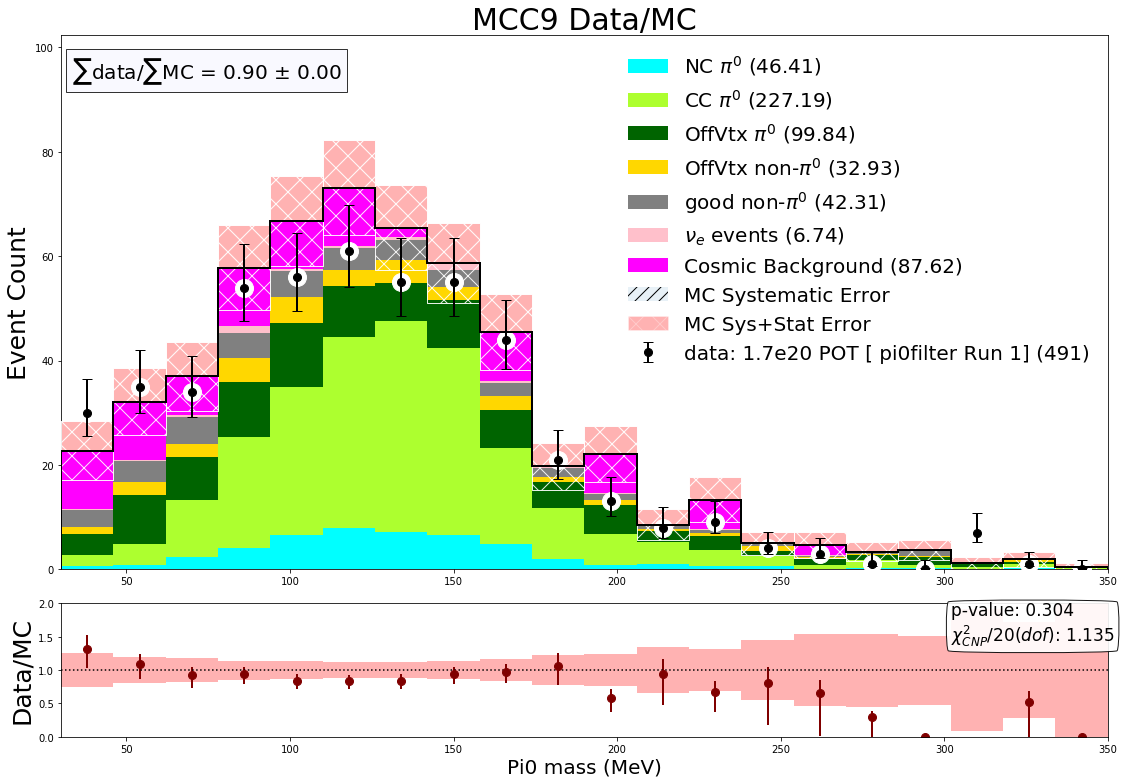

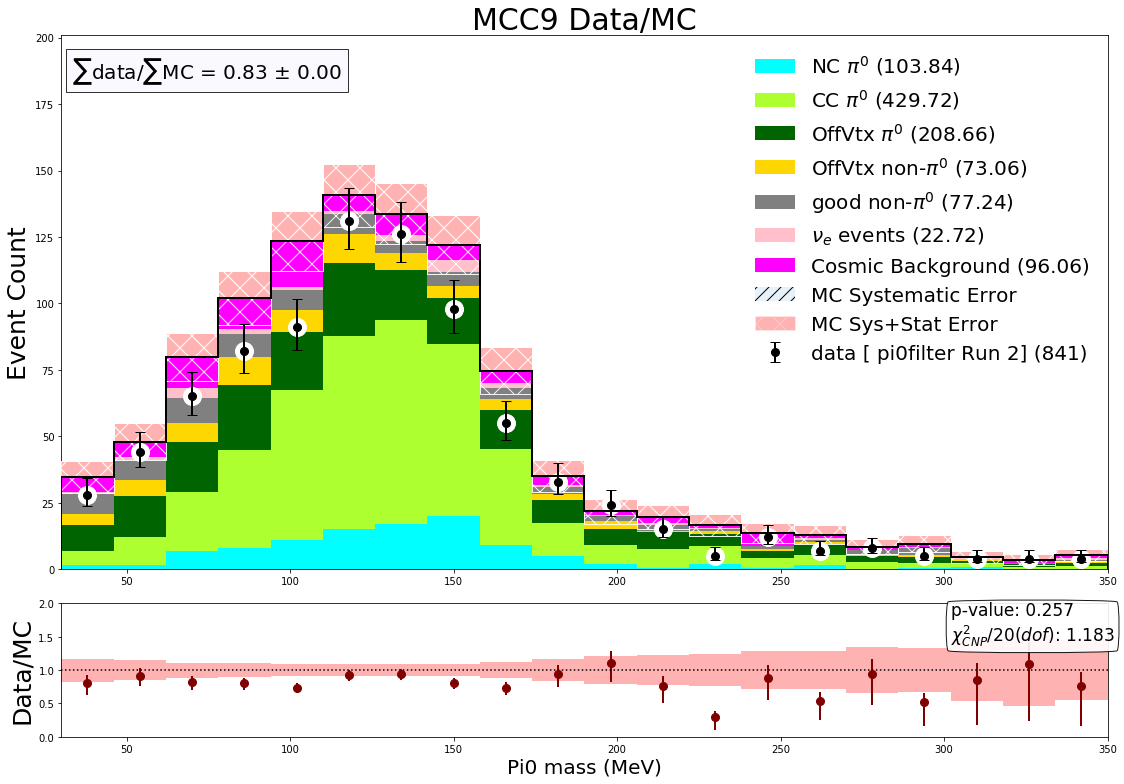

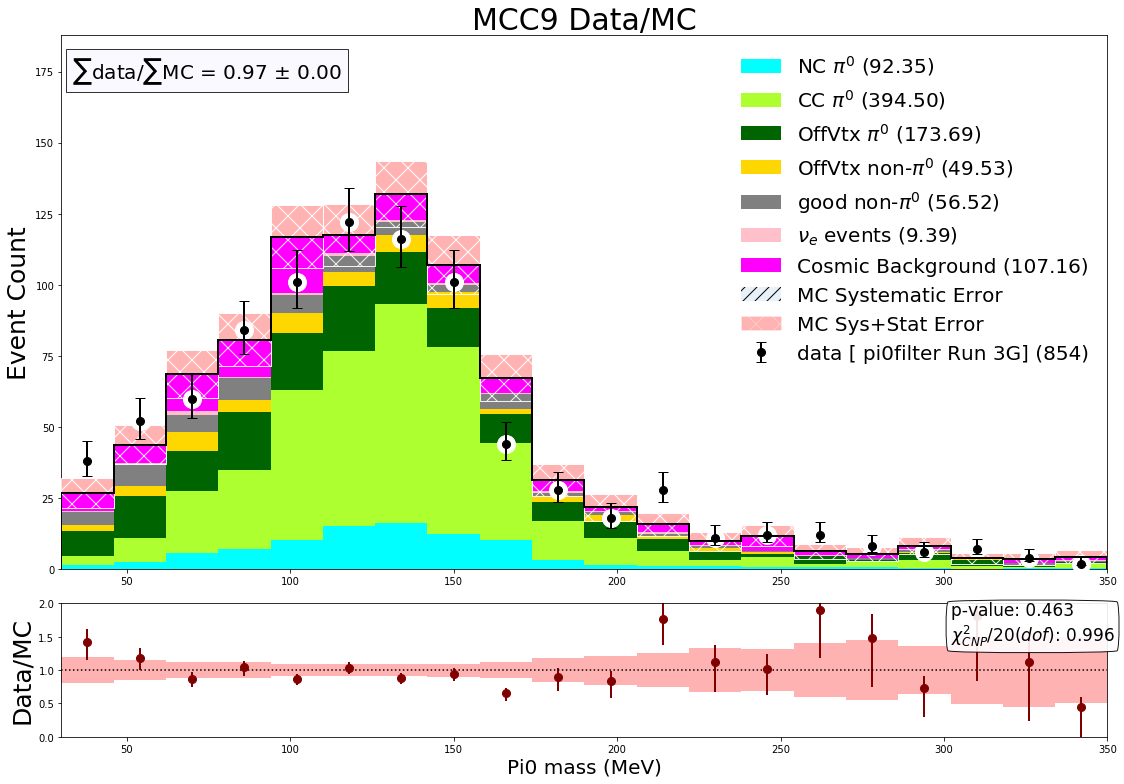

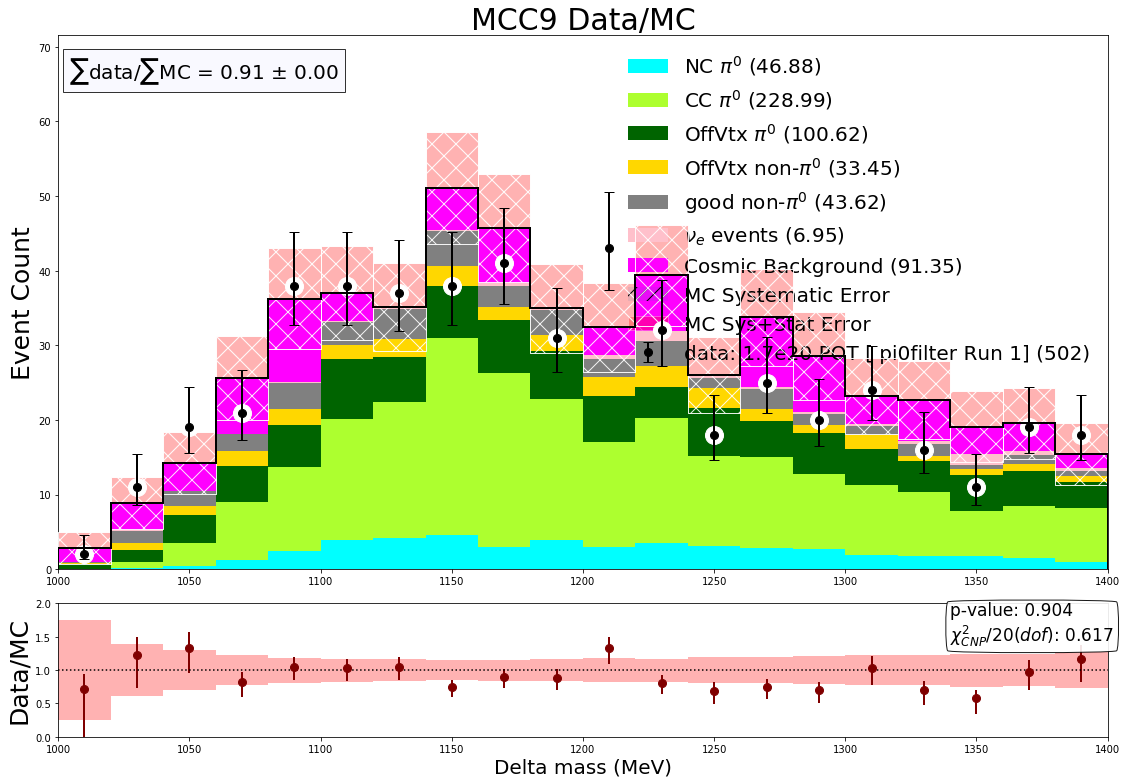

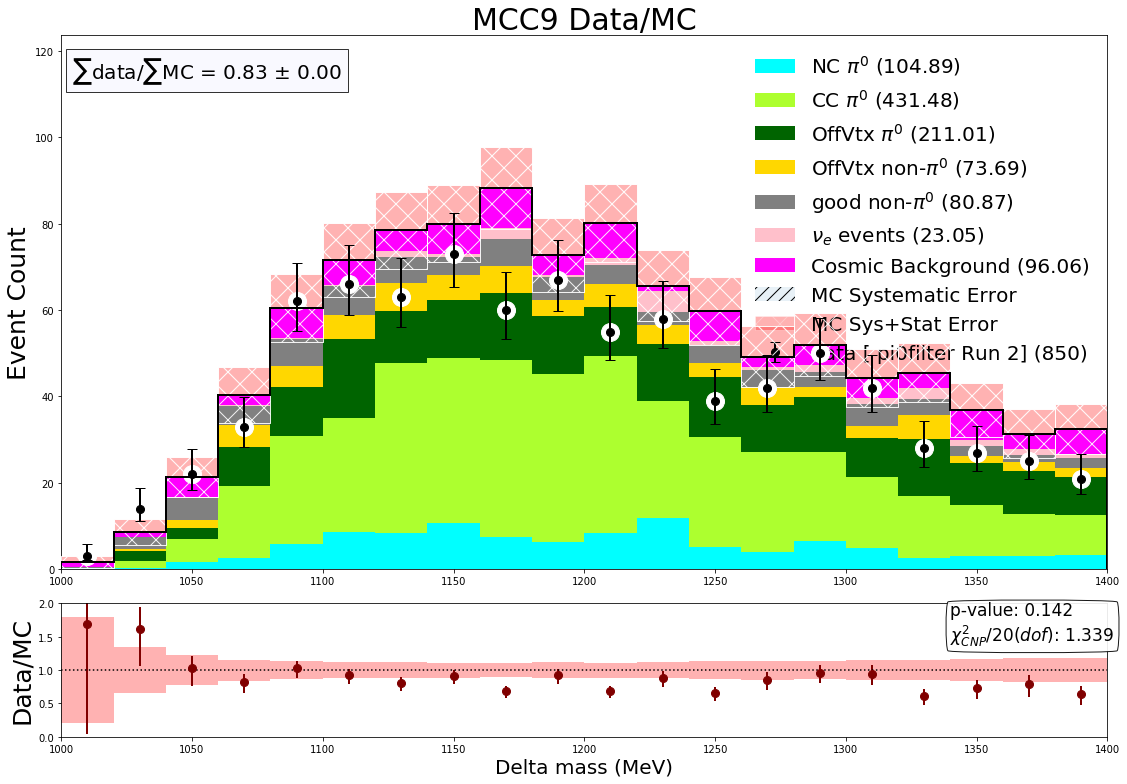

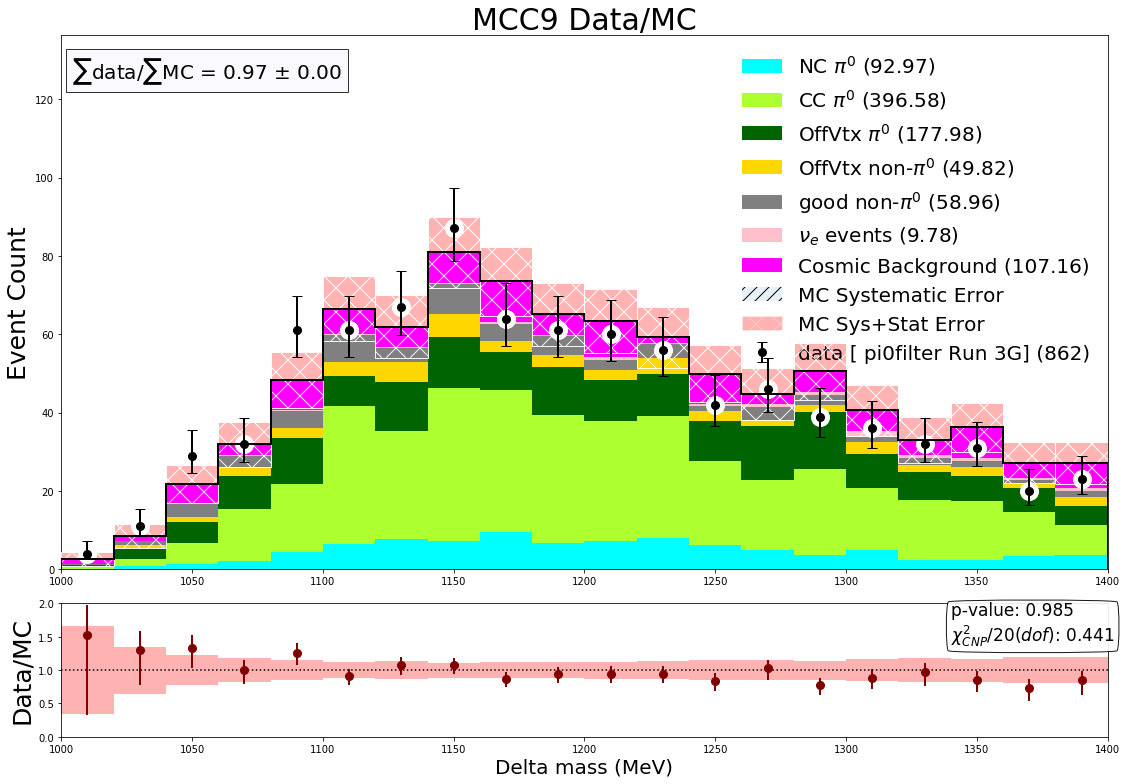

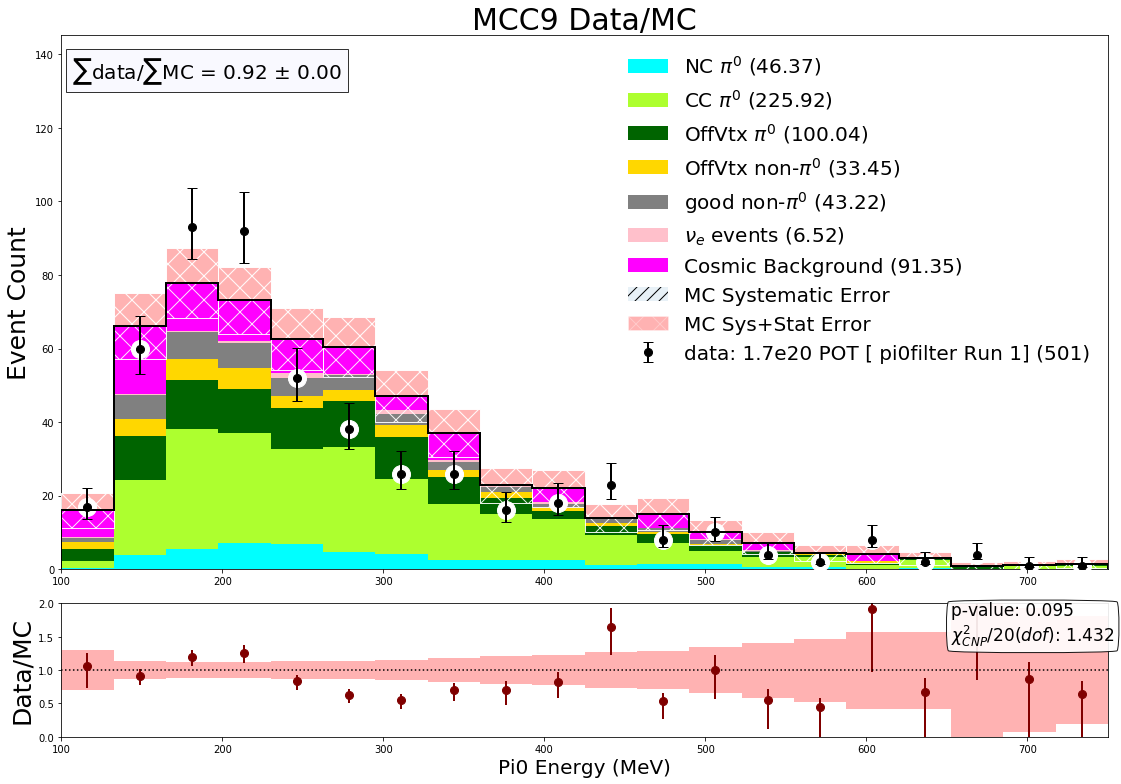

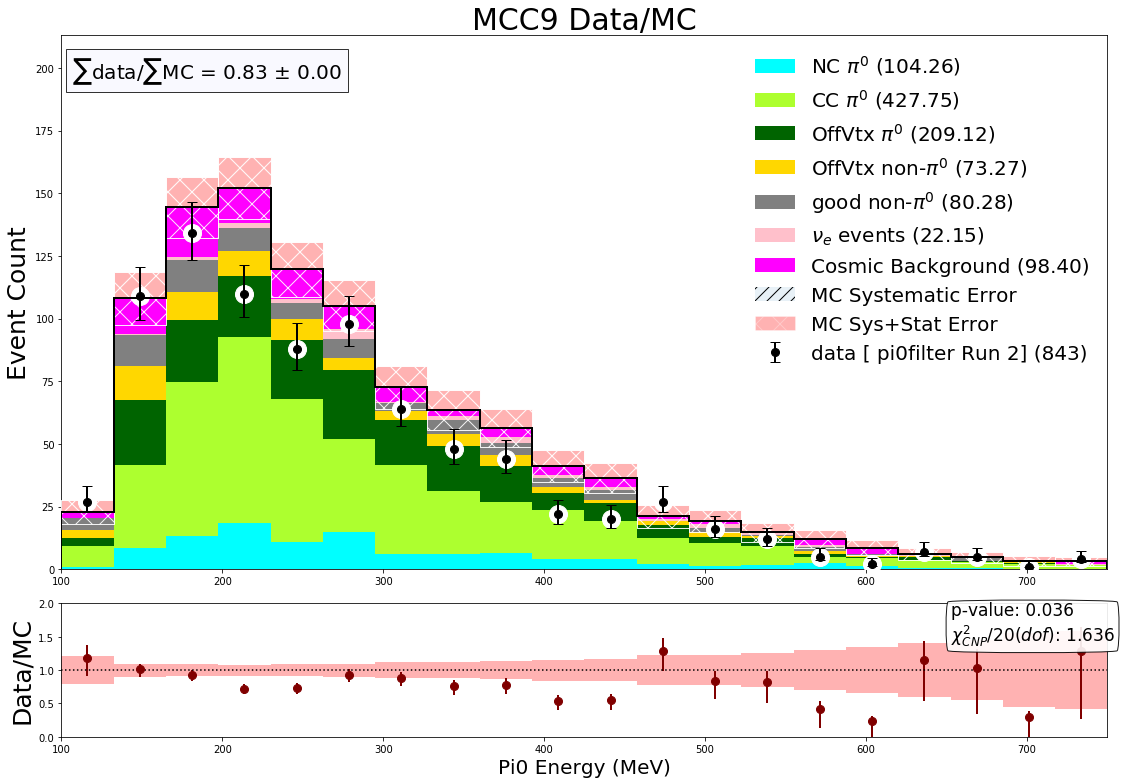

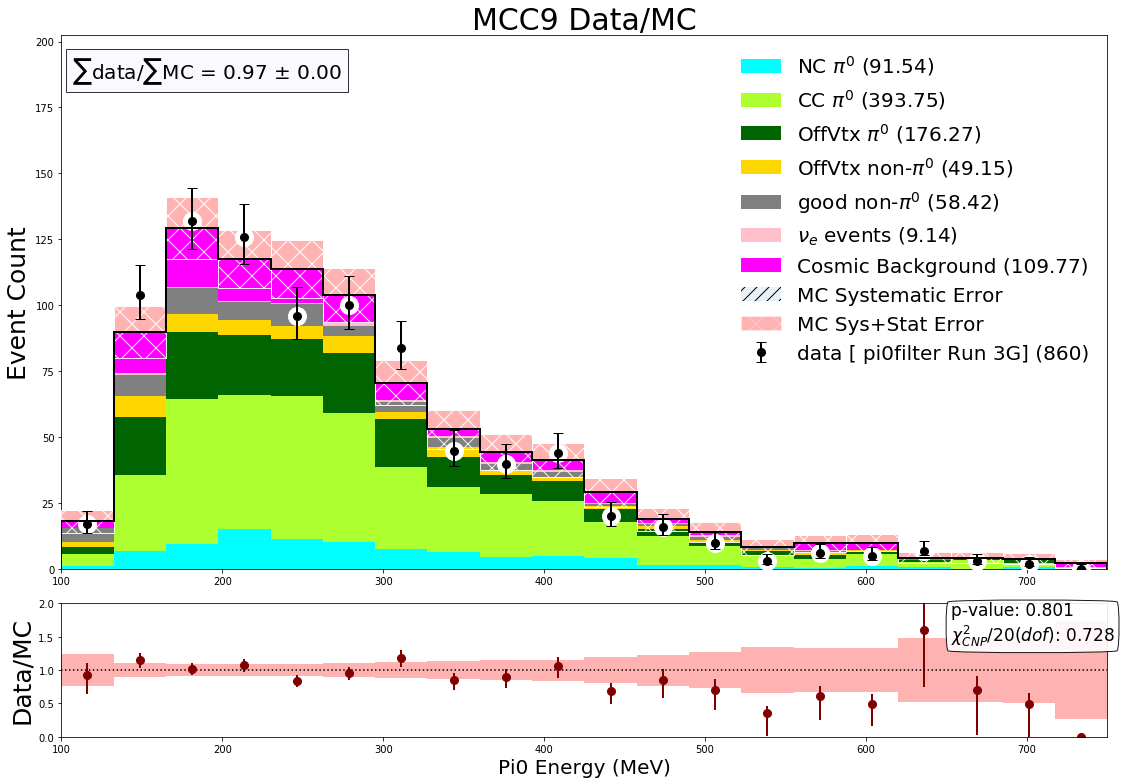

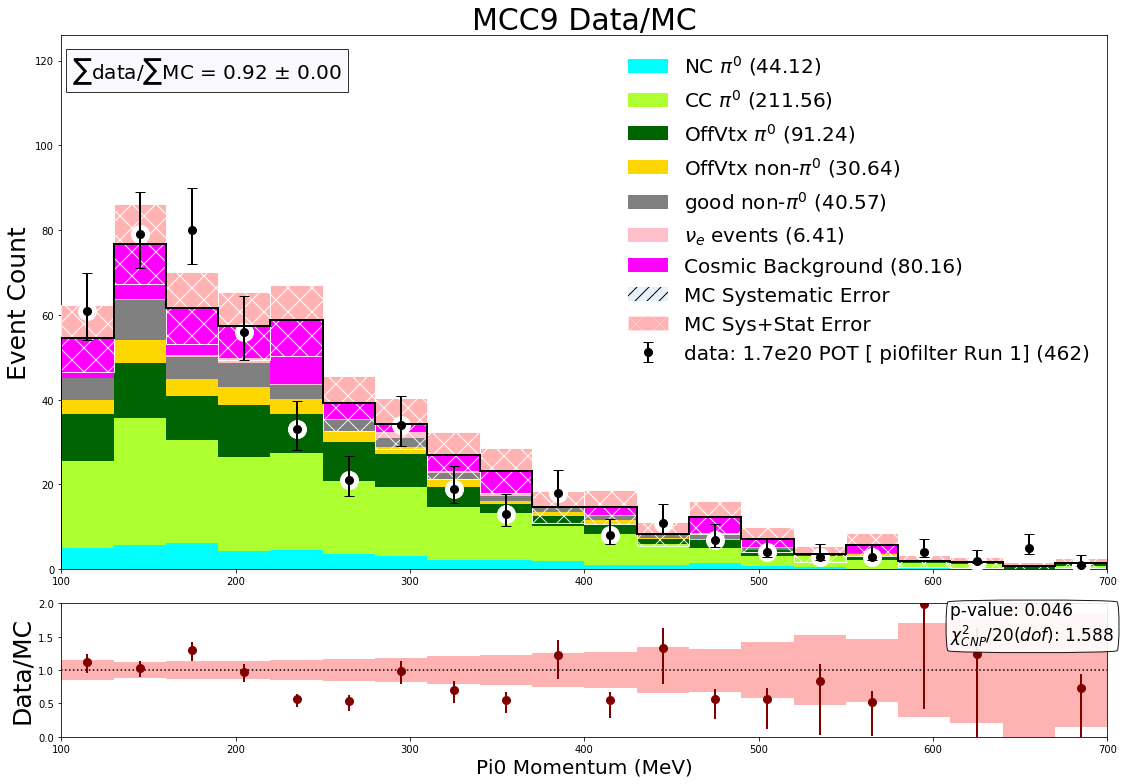

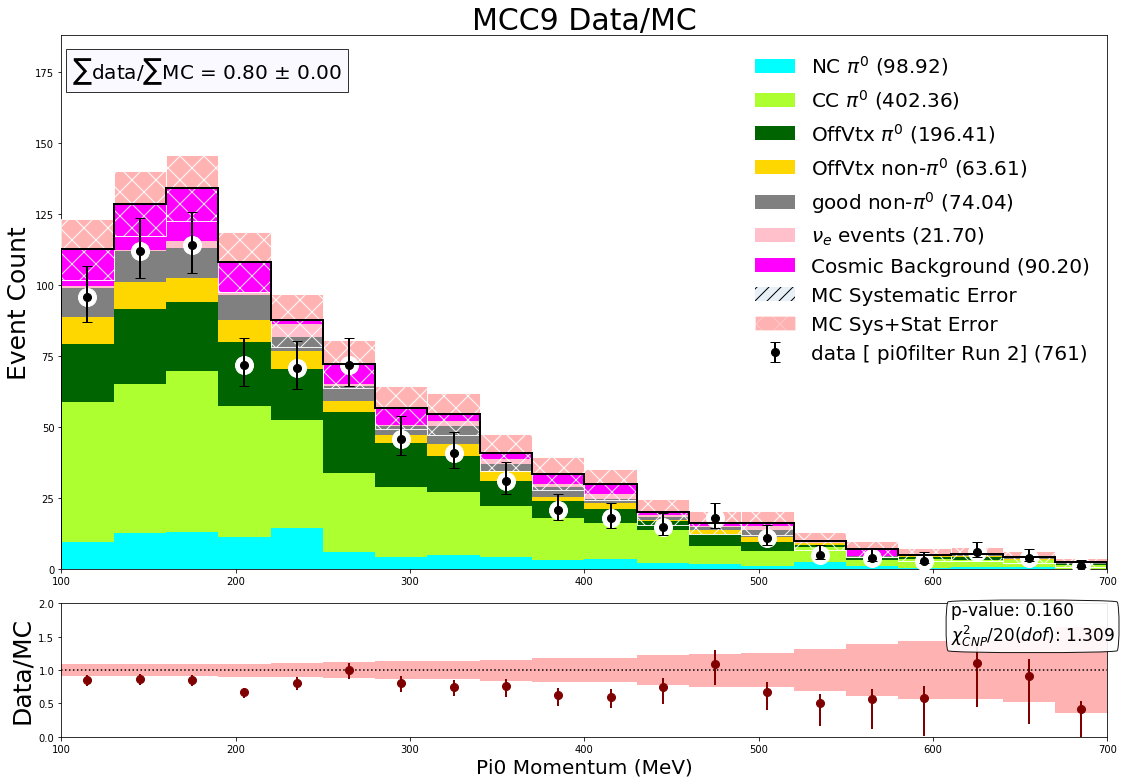

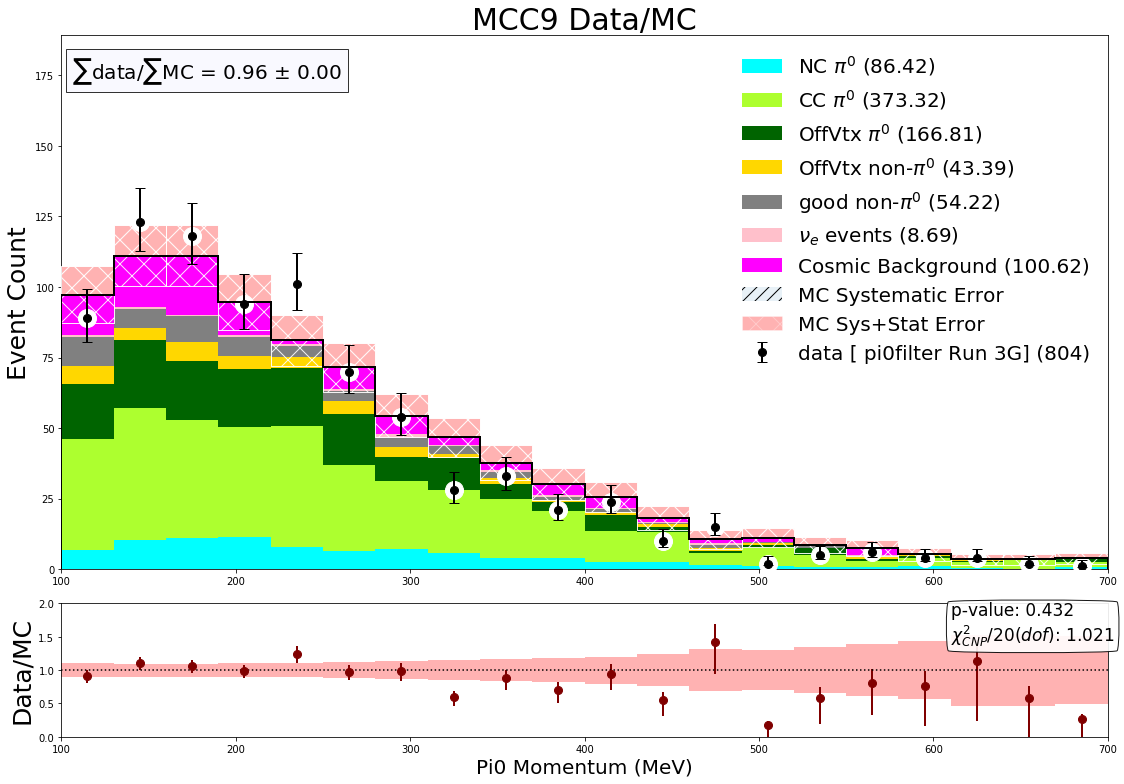

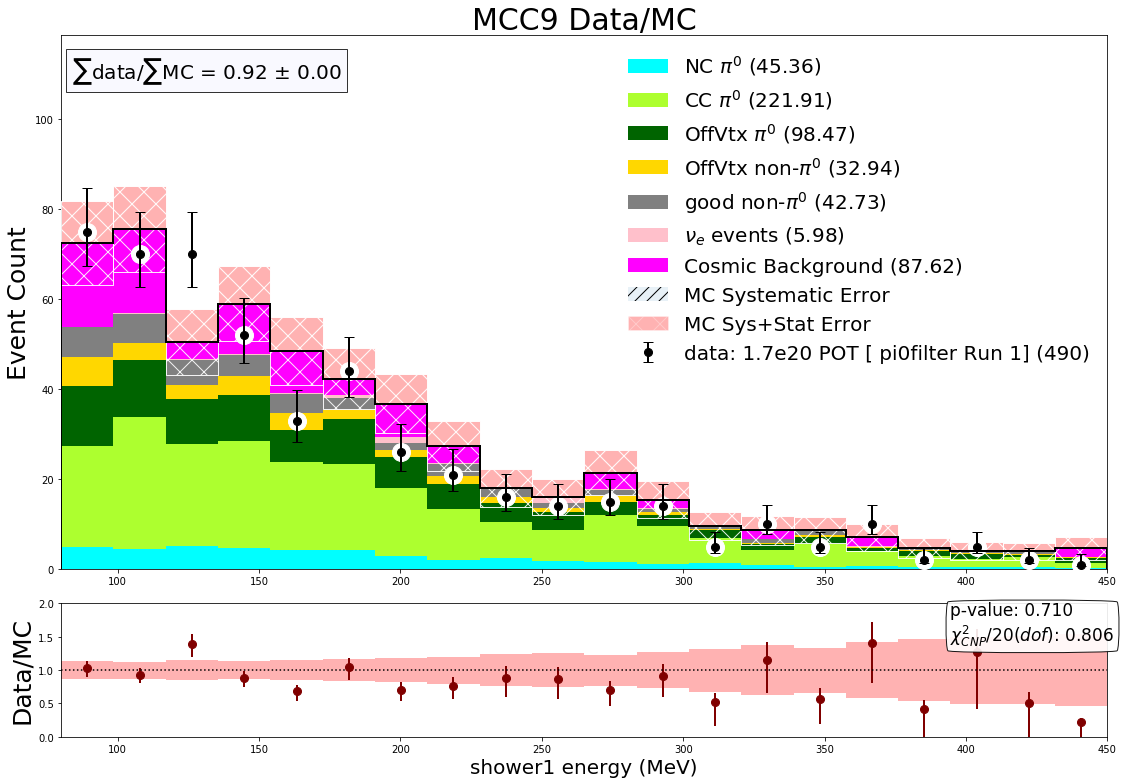

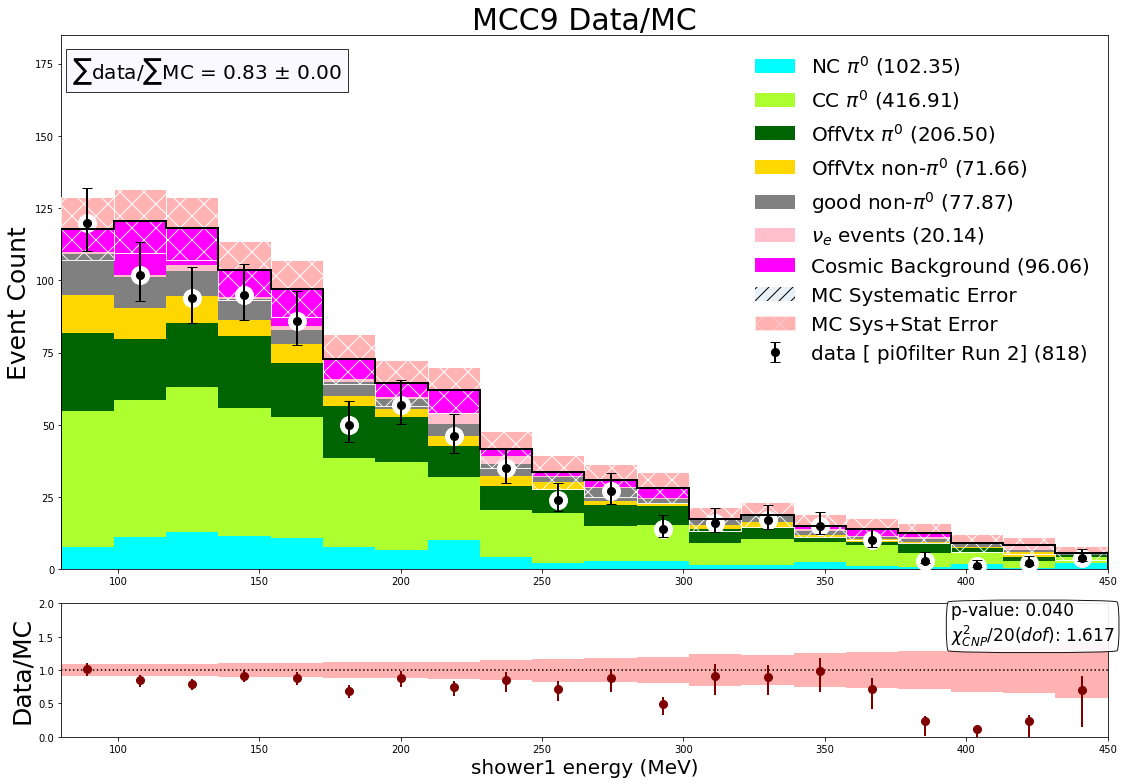

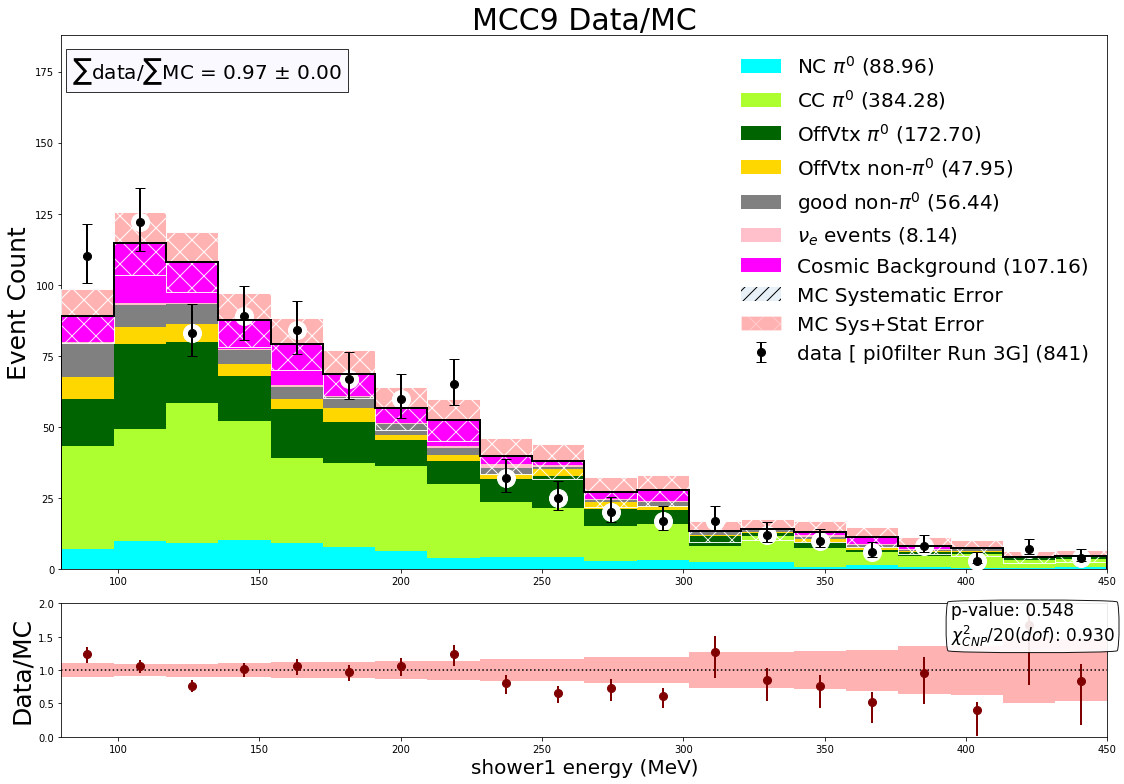

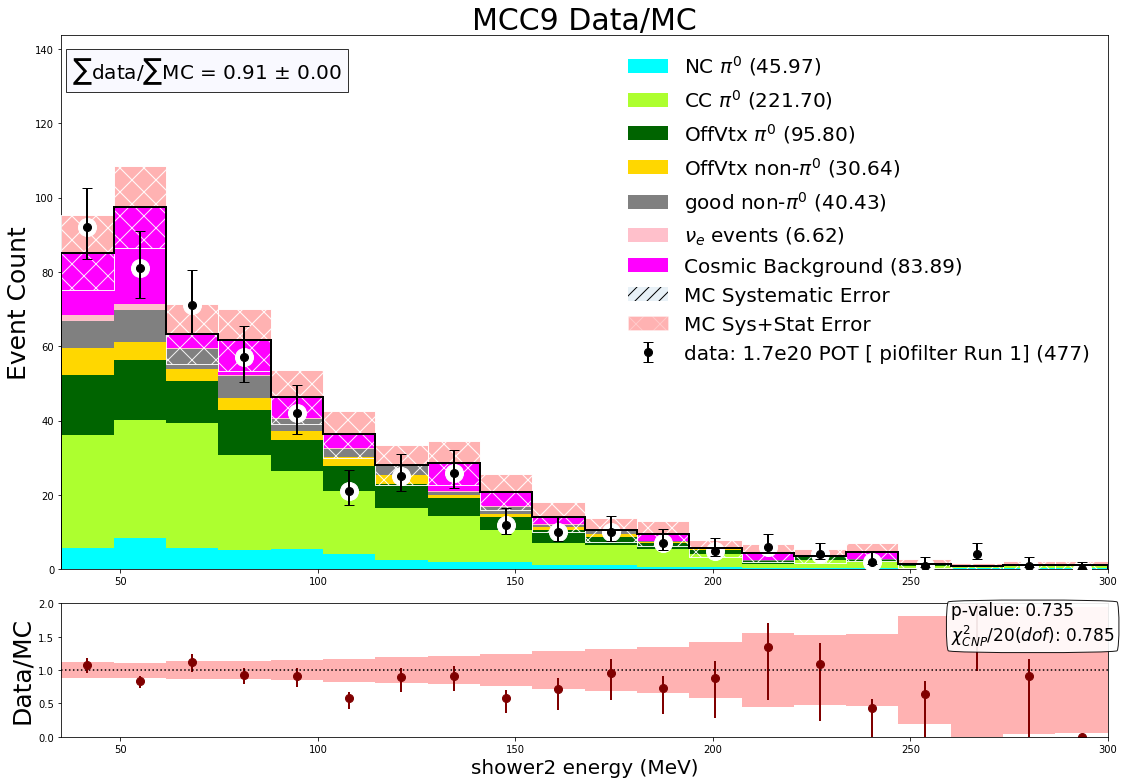

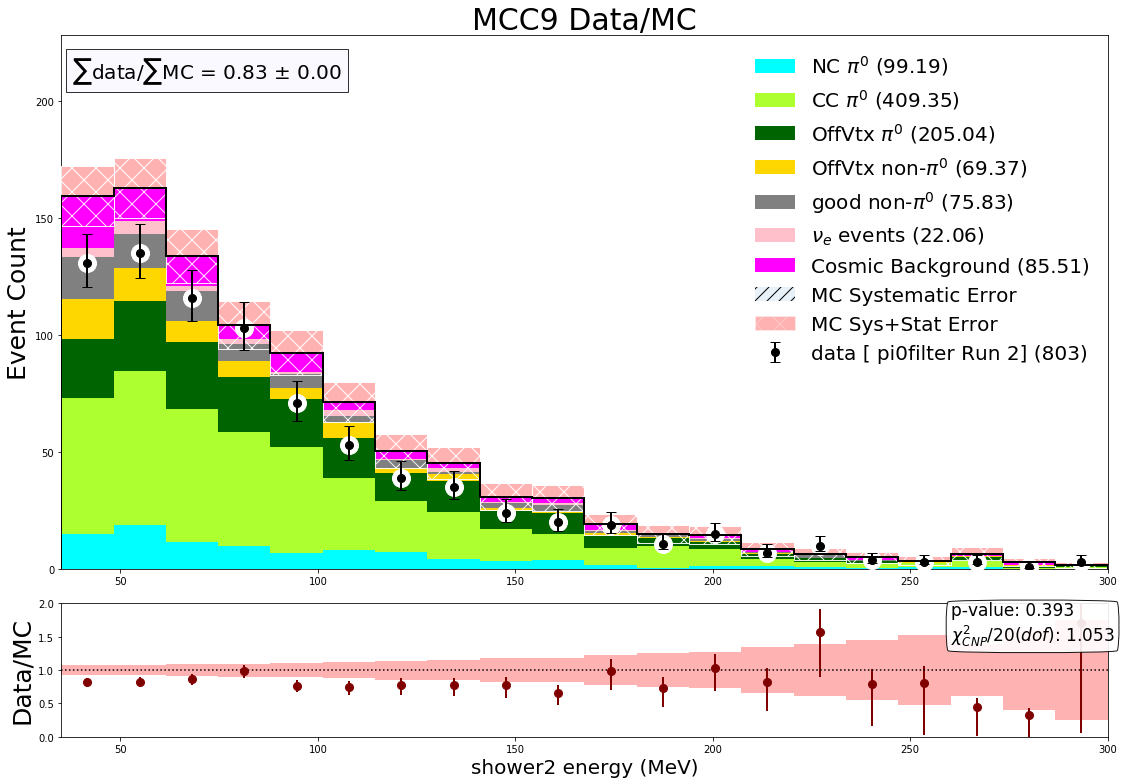

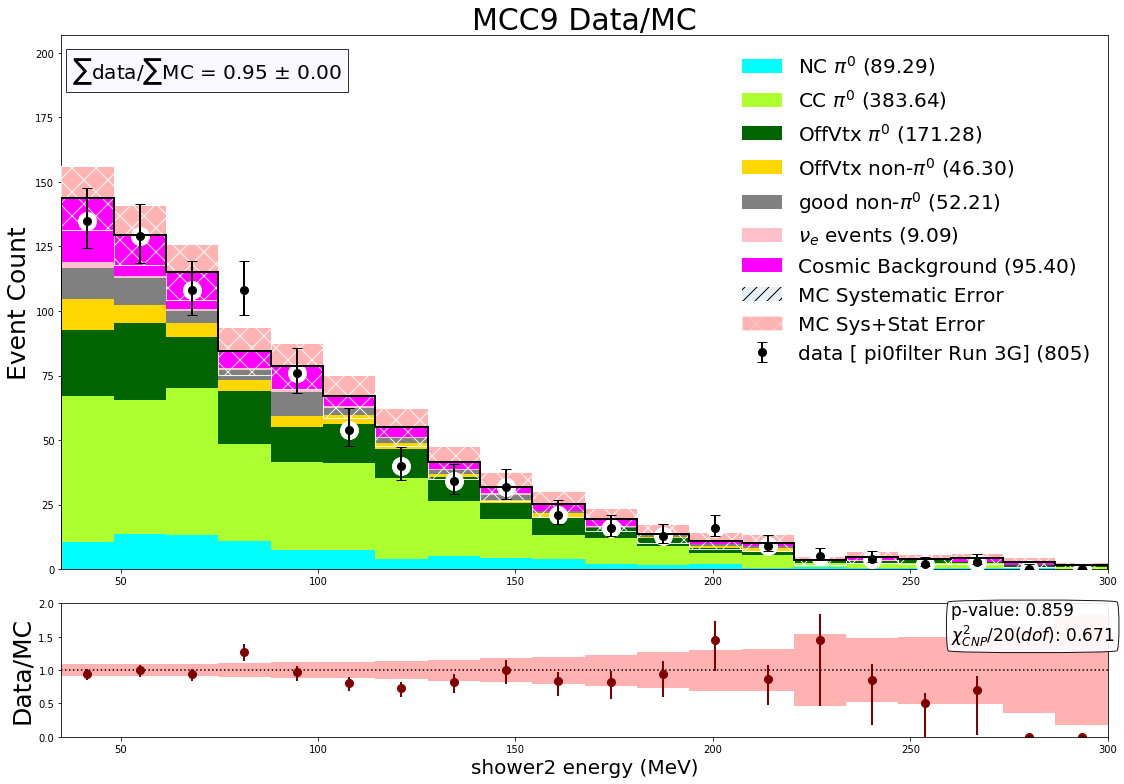

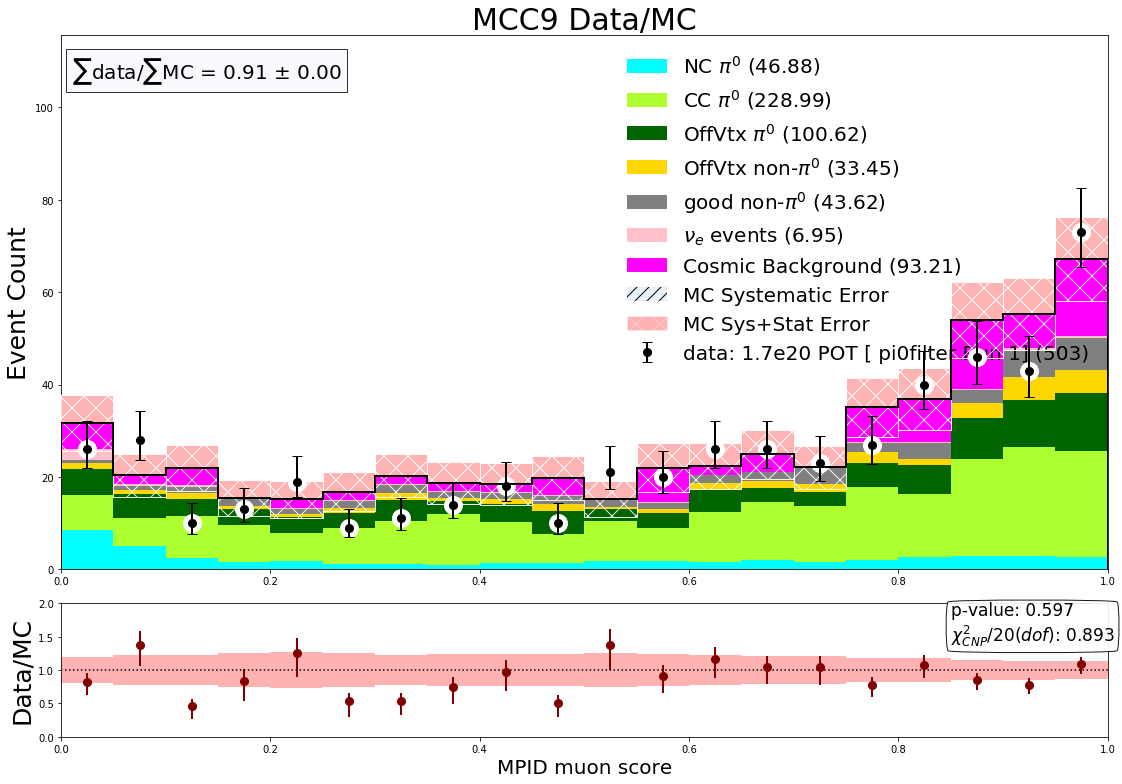

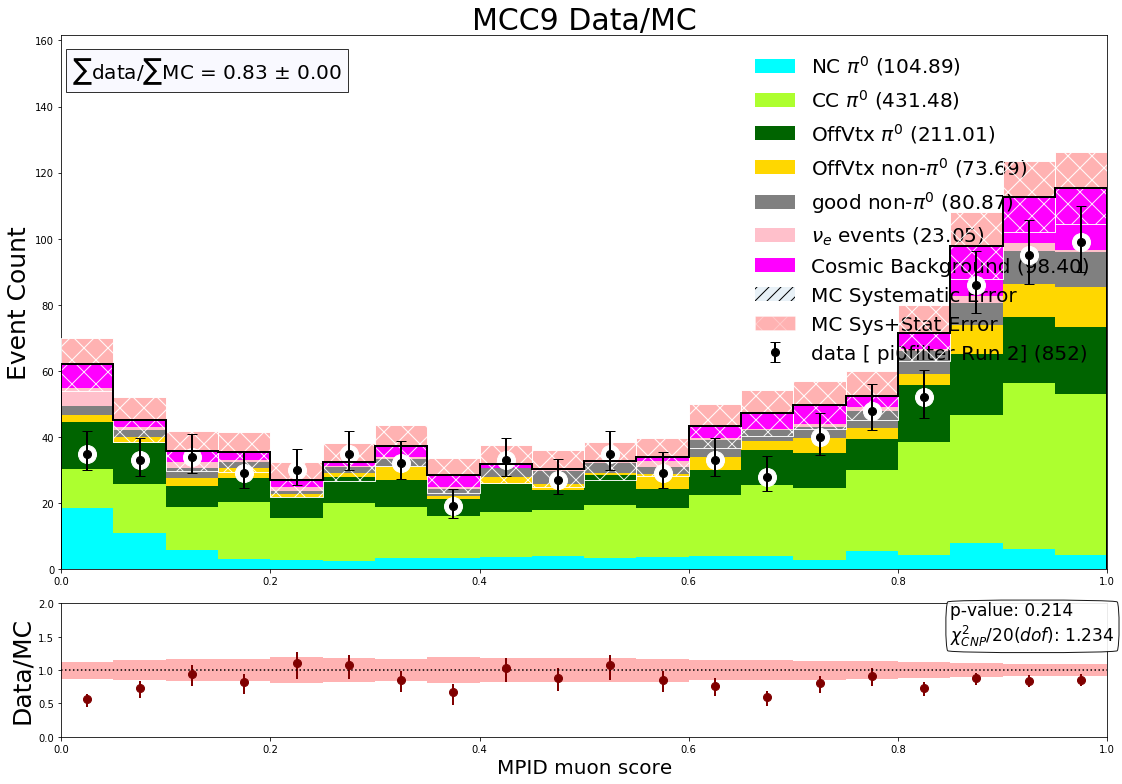

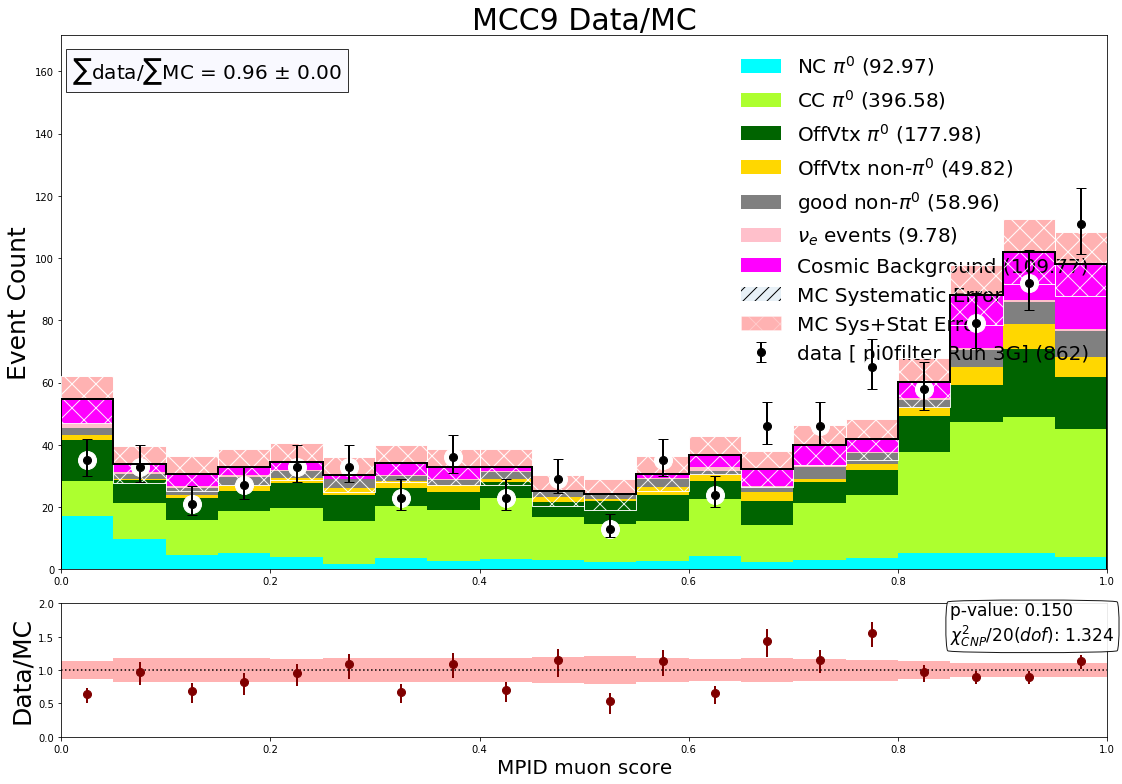

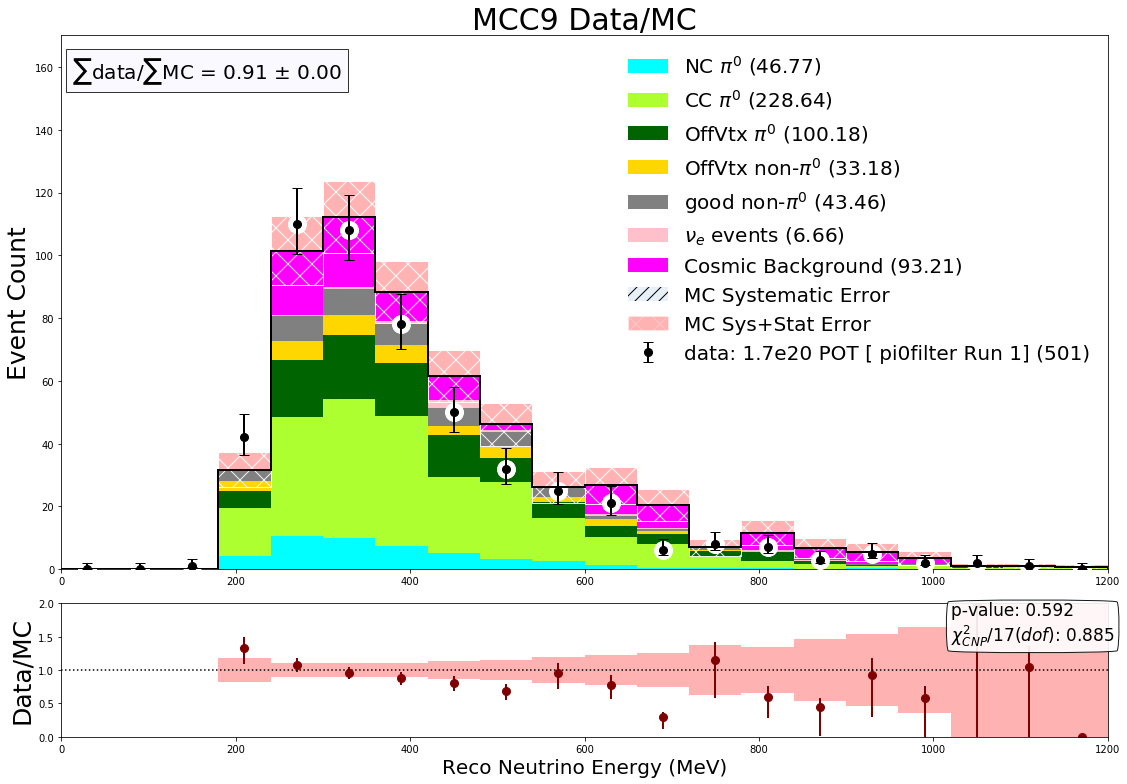

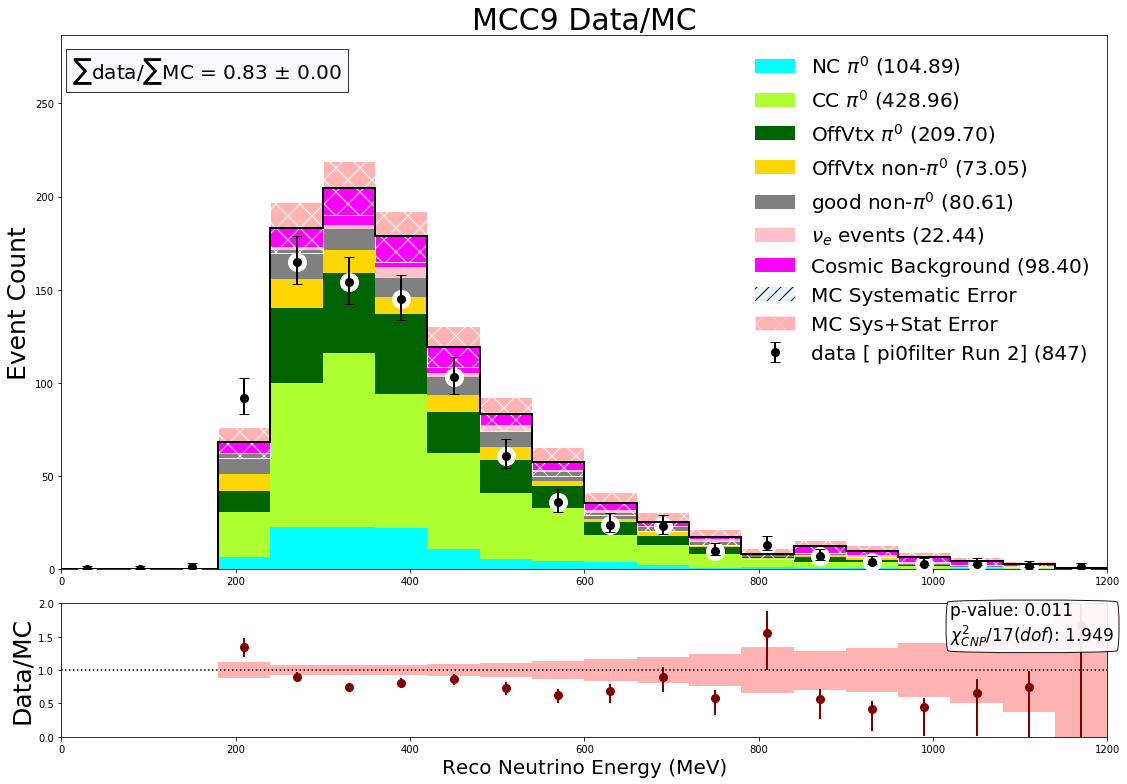

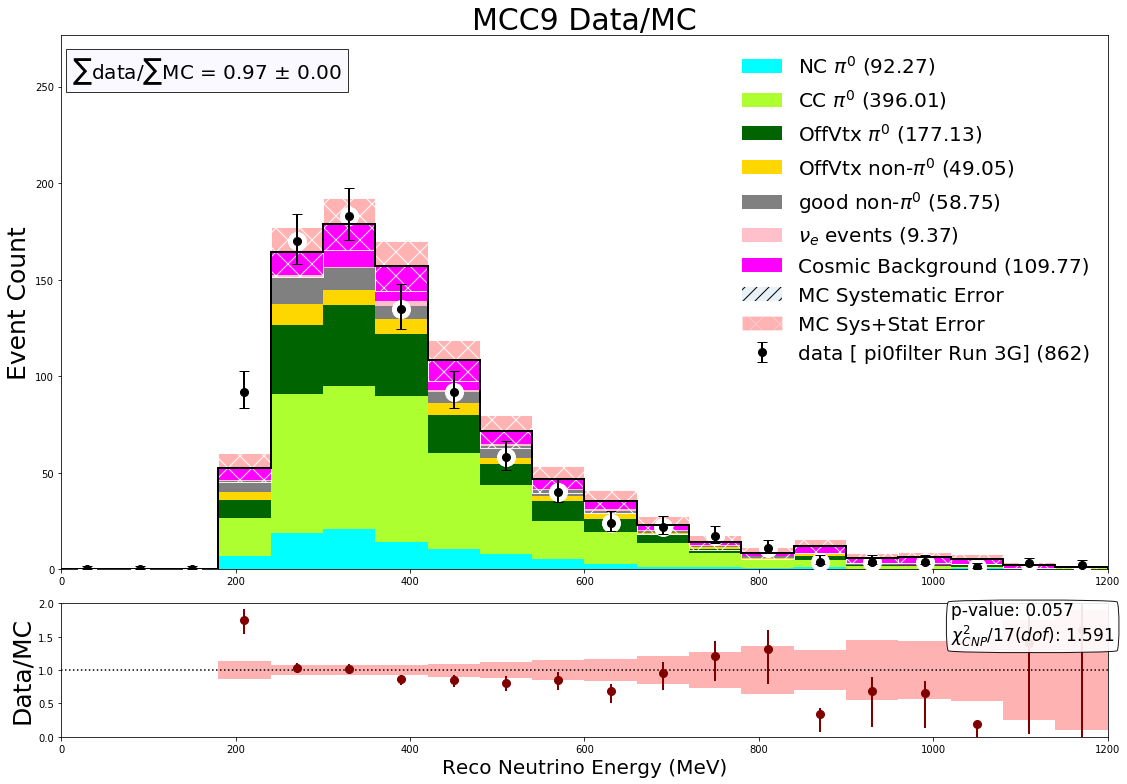

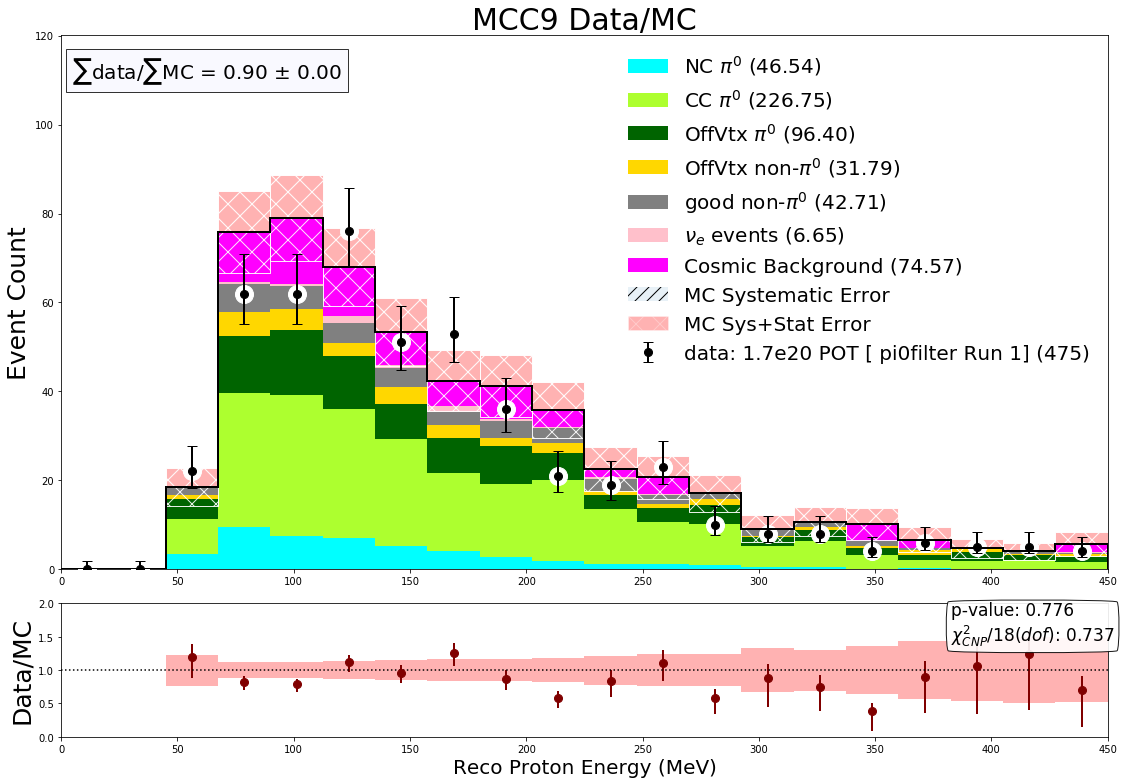

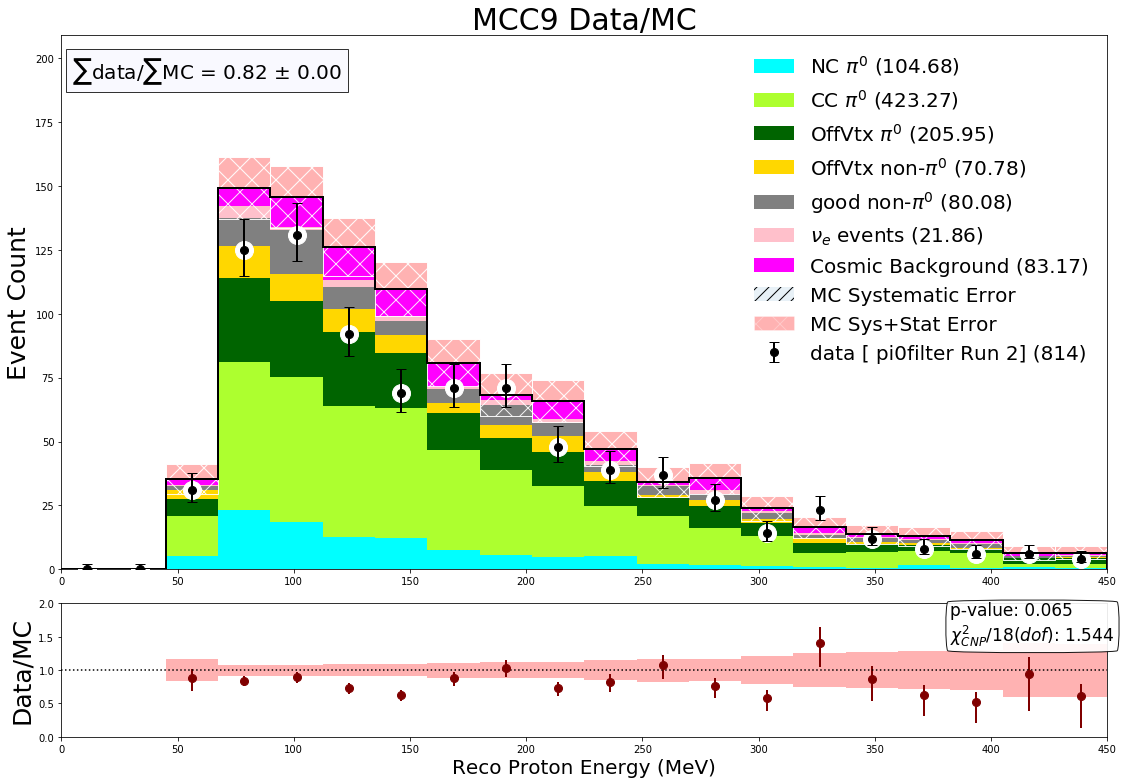

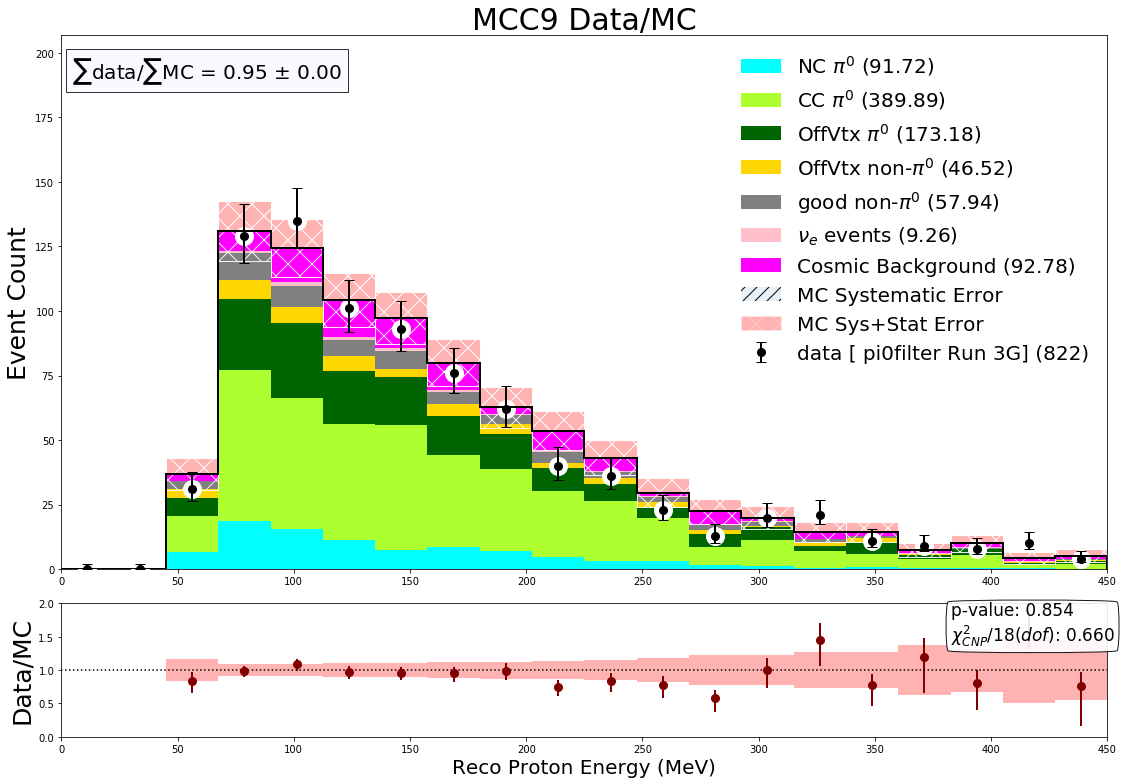

In [23]:
# individual runs again

EXT_R2_PI0FILTER_POT = EXT_R2D_PI0FILTER_POT +EXT_R2E_PI0FILTER_POT
EXT_R3_PI0FILTER_POT = EXT_R3F_PI0FILTER_POT +EXT_R3G_PI0FILTER_POT
EXT_R2_PI0FILTER_SCALE =  (DATA_R2D_PI0FILTER_POT+DATA_R2E_PI0FILTER_POT)/ float(EXT_R2_PI0FILTER_POT)
EXT_R3_PI0FILTER_SCALE =  (DATA_R3F_PI0FILTER_POT+DATA_R3G_PI0FILTER_POT)/ float(EXT_R3_PI0FILTER_POT)

norm = 1.0
with PdfPages('output_20210205_individualruns_original.pdf') as pdf:

    for i in range(len(vartest_list)):
        vartest = vartest_list[i]
        varname = varname_list[i]
        myrange = myrange_list[i]
        nbins =bins_list[i]

        cov = np.zeros((nbins,nbins))
        run1_pi0filter_Hists = StackedHisto((df_numu_1mil_pi0.query('newhaspi0==0'),df_nue_pi0,df_ccpi0_r1_pi0,df_ncpi0_r1_pi0),(1.0,1.0,1.0,1.0))
        run1_pi0filter_Hists.AddStrata('MC_parentPDG ==14 and haspi0==1 and ccnc==1 and MC_scedr<5 ',r"NC $\pi^0$",'cyan')
        run1_pi0filter_Hists.AddStrata('MC_parentPDG ==14 and haspi0==1 and ccnc!=1 and MC_scedr<5 ',r"CC $\pi^0$",'greenyellow')
        run1_pi0filter_Hists.AddStrata('haspi0==1  and MC_scedr>=5 ',r"OffVtx $\pi^0$",'darkgreen')
        run1_pi0filter_Hists.AddStrata('MC_parentPDG ==14 and haspi0==0 and MC_scedr>=5 ',r"OffVtx non-$\pi^0$",'gold')
        run1_pi0filter_Hists.AddStrata('MC_parentPDG ==14 and haspi0==0 and MC_scedr<5',r"good non-$\pi^0$",'grey')
        run1_pi0filter_Hists.AddStrata('MC_parentPDG ==12',r"$\nu_e$ events",'pink')
        run1_pi0filter_Hists.AddLayer(df_ext_pi0,EXT_R1_PI0FILTER_SCALE*norm,0,'Cosmic Background','fuchsia')
        run1_pi0filter_DataHist = SimpleHisto(df_data_r1_pi0filter_pi0,1.0,0,'','data: 1.7e20 POT [ pi0filter Run 1]')
        fig3,ax3,_,a = distplot_wratio_davio(vartest,nbins,myrange,run1_pi0filter_Hists,run1_pi0filter_DataHist,varname,m_cov=cov)

        cov = np.zeros((nbins,nbins))
        df_data_r2=df_data_r2D_pi0filter_pi0.append(df_data_r2E_pi0filter_pi0)
        run2D_pi0filter_Hists = StackedHisto((df_numu_r2_1mil_pi0,df_nue_r2_pi0),(1.0,1.0))
        run2D_pi0filter_Hists.AddStrata('haspi0==1 and ccnc==1 and MC_scedr<5 ',r"NC $\pi^0$",'cyan')
        run2D_pi0filter_Hists.AddStrata('haspi0==1 and ccnc!=1 and MC_scedr<5 ',r"CC $\pi^0$",'greenyellow')
        run2D_pi0filter_Hists.AddStrata('haspi0==1 and MC_scedr>=5 ',r"OffVtx $\pi^0$",'darkgreen')
        run2D_pi0filter_Hists.AddStrata('haspi0==0 and MC_scedr>=5 ',r"OffVtx non-$\pi^0$",'gold')
        run2D_pi0filter_Hists.AddStrata('haspi0==0 and MC_scedr<5',r"good non-$\pi^0$",'grey')
        run2D_pi0filter_Hists.AddStrata('MC_parentPDG ==12',r"$\nu_e$ events",'pink')
        run2D_pi0filter_Hists.AddLayer(df_ext_r3_pi0,EXT_R2_PI0FILTER_SCALE*norm,0,'Cosmic Background','fuchsia')
        run2D_pi0filter_DataHist = SimpleHisto(df_data_r2,1.0,0,'','data [ pi0filter Run 2]')
        fig4,ax4,_,a = distplot_wratio_davio(vartest,nbins,myrange,run2D_pi0filter_Hists,run2D_pi0filter_DataHist,varname,m_cov=cov)

        cov = np.zeros((nbins,nbins))
        df_data_r3=df_data_r3F_pi0filter_pi0.append(df_data_r3G_pi0filter_pi0)
        run3F_pi0filter_Hists = StackedHisto((df_numu_r3_pi0.query('newhaspi0==0'),df_nue_r3_pi0,df_ccpi0_r3_pi0,df_ncpi0_r3_pi0),(1.0,1.0,1.0,1.0))
        run3F_pi0filter_Hists.AddStrata('haspi0==1 and ccnc==1 and MC_scedr<5 ',r"NC $\pi^0$",'cyan')
        run3F_pi0filter_Hists.AddStrata('haspi0==1 and ccnc!=1 and MC_scedr<5 ',r"CC $\pi^0$",'greenyellow')
        run3F_pi0filter_Hists.AddStrata('haspi0==1 and MC_scedr>=5 ',r"OffVtx $\pi^0$",'darkgreen')
        run3F_pi0filter_Hists.AddStrata('haspi0==0 and MC_scedr>=5 ',r"OffVtx non-$\pi^0$",'gold')
        run3F_pi0filter_Hists.AddStrata('haspi0==0 and MC_scedr<5',r"good non-$\pi^0$",'grey')
        run3F_pi0filter_Hists.AddStrata('MC_parentPDG ==12',r"$\nu_e$ events",'pink')
        run3F_pi0filter_Hists.AddLayer(df_ext_r3_pi0,EXT_R3_PI0FILTER_SCALE*norm,0,'Cosmic Background','fuchsia')
        run3F_pi0filter_DataHist = SimpleHisto(df_data_r3,1.0,0,'','data [ pi0filter Run 3G]')
        fig6,ax6,_,a = distplot_wratio_davio(vartest,nbins,myrange,run3F_pi0filter_Hists,run3F_pi0filter_DataHist,varname,m_cov=cov)

        #save to pdf file of plots
#         pdf.savefig(fig1)
#         pdf.savefig(fig3)
#         pdf.savefig(fig4)
#         pdf.savefig(fig5)
#         pdf.savefig(fig6)
#         pdf.savefig(fig7)

In [24]:
print(len(df_numu_pi0.query('newhaspi0==1 and MC_scedr<5 and ccnc==0'))*(DATA_R1_PI0FILTER_POT)/NUMU_R1_POT)
print(len(df_ccpi0_r1_pi0.query('MC_scedr<5'))*(DATA_R1_PI0FILTER_POT)/CCPI0_R1_POT)
print(len(df_ext_total))

1199.5023670593416
204.06733933132378
218



True
True


/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:132: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



2411
4633
3401
696
827
3662
hstack gh_weights [0.12200961 0.12200961 0.12200961 ... 1.30680013 1.30680013 1.30680013]
hstack gh_scale [1.         1.         1.         ... 1.30680013 1.30680013 1.30680013]
SUM 238.1031981110362
SUM 1032.7144299835352
SUM 461.4407766670574
SUM 140.0398036781035
SUM 162.33797617644086
SUM 19.17044251941478
SUM 441.7996193836444
Normalization Uncertainty: 0.23114783638208014
yerr_mc_total [23.94946779 35.40015145 49.28456696 64.57766506 85.16682644 89.39177428
 95.62051336 69.3981001  47.33634501 23.69301846 21.31205687 15.21789574
 14.2502056  11.11516591  9.08972955  7.7061305   9.25150453  4.3246678
  4.55629565  4.98093437]
yerr_data 190.22013442439757
ERROR HERE
[0.09380313 0.078566   0.06223823 0.0562637  0.04528591 0.05022804
 0.04807763 0.05318091 0.0572628  0.09463483 0.09146281 0.14454862
 0.09854115 0.14280862 0.16241291 0.20642482 0.09848236 0.35529668
 0.22078894 0.1532583 ]
[0.11492841 0.0934859  0.07287821 0.06434228 0.05138582 0.05619773
 

/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:132: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



hstack gh_weights [0.12200961 0.12200961 0.12200961 ... 1.30680013 1.30680013 1.30680013]
hstack gh_scale [1.         1.         1.         ... 1.30680013 1.30680013 1.30680013]
SUM 239.5142893140517
SUM 1038.1311688132123
SUM 470.19467582243556
SUM 141.40101056672844
SUM 169.0891782066536
SUM 19.580300540909892
SUM 448.7504115122359
Normalization Uncertainty: 0.22730452215317526
yerr_mc_total [ 5.55441675 12.66747074 19.06001921 26.08130024 33.80984047 46.84094461
 44.20875427 59.88535901 55.36763073 49.28767202 46.52117539 44.80641029
 37.09986909 33.91156615 36.80618704 32.70361656 31.55166448 30.82540549
 24.98116368 23.18883807]
yerr_data 212.17687276307265
ERROR HERE
[0.2001266  0.16342945 0.10893386 0.08198155 0.07591516 0.06462424
 0.07138414 0.05931664 0.05624659 0.0692225  0.06753835 0.0678654
 0.06732217 0.07258101 0.06940285 0.08161308 0.07488582 0.07344845
 0.08731823 0.09268548]
[0.38868241 0.22771375 0.13818657 0.1016048  0.08880593 0.07545328
 0.08326841 0.06832768 0.06

/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:132: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



hstack gh_weights [0.12200961 0.12200961 0.12200961 ... 1.30680013 1.30680013 1.30680013]
hstack gh_scale [1.         1.         1.         ... 1.30680013 1.30680013 1.30680013]
SUM 236.6967167996933
SUM 1029.592152370006
SUM 465.59350701573254
SUM 140.85235948265162
SUM 168.22153096243824
SUM 18.333287210388352
SUM 455.58131782950704
Normalization Uncertainty: 0.2311518956093285
yerr_mc_total [18.60324738 66.67595812 93.38847481 84.81291536 81.86699492 79.44981278
 50.52251251 39.68528211 30.73802695 28.46187258 21.13993656 14.08730582
 12.04570962  8.87736159  9.11141566  9.16994495  4.8728886   5.12876196
  4.7630786   4.15643764]
yerr_data 188.91309458058484
ERROR HERE
[0.10838771 0.05422333 0.04863814 0.05090218 0.04710112 0.05079968
 0.0629377  0.0642476  0.07658481 0.07257676 0.08916867 0.1141407
 0.12387398 0.13279267 0.10106366 0.11009887 0.27693407 0.24589031
 0.13139253 0.21161021]
[0.13984364 0.06116362 0.05402444 0.05681417 0.05361539 0.05782547
 0.07318639 0.07710535 0.09

/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:132: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



hstack gh_weights [0.12200961 0.12200961 0.12200961 ... 1.30680013 1.30680013 1.30680013]
hstack gh_scale [1.         1.         1.         ... 1.30680013 1.30680013 1.30680013]
SUM 223.74718773970403
SUM 973.1190208358539
SUM 435.91821674395504
SUM 123.25182445470666
SUM 155.51686213273587
SUM 17.918190232253405
SUM 410.8207693332835
Normalization Uncertainty: 0.23073479645248826
yerr_mc_total [63.4293566  80.15215893 79.13352713 69.35509962 68.91265501 49.98280314
 39.00419957 34.57801771 27.11363402 19.32391033 17.90551224 12.0603875
 10.7257019  11.60025053  6.58607003  8.6768744   5.26596737  4.23478742
  4.34081686  4.82320619]
yerr_data 182.556180554681
ERROR HERE
[0.05354936 0.05041929 0.05370264 0.05248143 0.05606792 0.06175576
 0.07357948 0.06362097 0.07453525 0.08343027 0.08640238 0.11852234
 0.14882277 0.09015988 0.14412228 0.11626128 0.19767391 0.30578822
 0.27711925 0.10528526]
[0.0607935  0.05641171 0.06010688 0.05998059 0.06442832 0.0721725
 0.08738121 0.07865623 0.0935

/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:132: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



hstack gh_weights [0.12200961 0.12200961 0.12200961 ... 1.30680013 1.30680013 1.30680013]
hstack gh_scale [1.         1.         1.         ... 1.30680013 1.30680013 1.30680013]
SUM 230.31011328656066
SUM 1006.51997150778
SUM 456.7478005110246
SUM 138.52934137624288
SUM 164.3861200156617
SUM 16.927497927786554
SUM 441.7996193836444
Normalization Uncertainty: 0.23305647589961398
yerr_mc_total [71.87890668 80.62285839 72.33563943 65.81729988 57.97090933 53.62272241
 42.52371225 38.25293495 31.61995928 27.6913097  23.46579329 20.51183501
 12.76581396 10.95886326 10.67939268 11.41420363 10.0620178   8.52440279
  7.39585593  7.48496386]
yerr_data 193.52736142942467
ERROR HERE
[0.05705378 0.04731188 0.05241936 0.05599321 0.05826707 0.06299914
 0.06731419 0.07378053 0.08028868 0.07486384 0.08383519 0.07874369
 0.13838268 0.13142506 0.13021477 0.12366003 0.11377768 0.11740058
 0.17886059 0.15267931]
[0.06393981 0.05313424 0.05949533 0.06373729 0.06700114 0.0736967
 0.07950239 0.08773374 0.0998

/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:132: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



hstack gh_weights [0.12200961 0.12200961 0.12200961 ... 1.30680013 1.30680013 1.30680013]
hstack gh_scale [1.         1.         1.         ... 1.30680013 1.30680013 1.30680013]
SUM 230.26335271556871
SUM 1002.5714603655221
SUM 451.4640515711487
SUM 131.57746343335432
SUM 155.58739023063583
SUM 18.593787764304814
SUM 404.1097488273327
Normalization Uncertainty: 0.22762316763256418
yerr_mc_total [98.2866157  94.43216156 80.52389051 63.65677647 53.79130051 46.16894863
 38.61544754 32.69985647 24.96515763 21.43856528 17.29624859 14.01623734
 11.93075392 13.42816235  6.8876092   9.47585462  6.95145722 13.07836924
  9.1370939   4.74618819]
yerr_data 179.19335402011083
ERROR HERE
[0.04367099 0.04447143 0.05054899 0.06159221 0.06011632 0.05858335
 0.0654896  0.07245153 0.08196482 0.08776482 0.11420914 0.1148232
 0.18005162 0.14087283 0.28701507 0.13617322 0.17396289 0.20643355
 0.08708909 0.2100443 ]
[0.04851434 0.04950063 0.05675854 0.06955342 0.06947971 0.06984985
 0.07960155 0.08886296 0.1

/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:132: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



3662
hstack gh_weights [0.12200961 0.12200961 0.12200961 ... 1.30680013 1.30680013 1.30680013]
hstack gh_scale [1.         1.         1.         ... 1.30680013 1.30680013 1.30680013]
SUM 239.51428931405138
SUM 1038.1311688132114
SUM 470.1946758224362
SUM 141.40101056672842
SUM 169.0891782066535
SUM 19.580300540909914
SUM 459.05671389380285
Normalization Uncertainty: 0.225581026376395
yerr_mc_total [38.25687928 25.83541265 25.27606314 22.56853565 24.60084388 22.97779418
 26.76790278 24.93458524 27.27832919 22.95001431 20.73591081 24.17560504
 28.22264176 28.0176102  30.0437259  35.10385202 43.57042909 59.26104939
 67.64930748 65.72707907]
yerr_data 213.31191295228967
ERROR HERE
[0.058338   0.0951277  0.07992585 0.08878864 0.09423474 0.10020854
 0.07674098 0.08509209 0.08642999 0.09401057 0.11048855 0.08928881
 0.08052132 0.09022415 0.08451735 0.08334747 0.06521662 0.05235133
 0.05025636 0.05339956]
[0.07147623 0.11680209 0.10230347 0.11282526 0.11739658 0.12571862
 0.09804266 0.10812799

/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:132: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



3401
696
827
3662
hstack gh_weights [0.12200961 0.12200961 0.12200961 ... 1.30680013 1.30680013 1.30680013]
hstack gh_scale [1.         1.         1.         ... 1.30680013 1.30680013 1.30680013]
SUM 238.26298146622926
SUM 1036.5498131399931
SUM 467.884984657125
SUM 139.9883091681849
SUM 168.93204493148752
SUM 18.64211189047772
SUM 459.05671389380285
Normalization Uncertainty: 0.0
yerr_mc_total [ 0.          0.          0.         12.51448414 22.45944178 23.76748265
 21.46699035 18.00077242 14.36261262 11.43903807 10.99422158  9.5136144
  5.98872526  6.60967694  6.83634086  5.58440837  5.0669102   3.70550347
  2.60276088  1.77816552]
yerr_data 166.69655886780734
ERROR HERE
[0.         0.         0.         0.092888   0.04354577 0.03936361
 0.04161924 0.04902183 0.05716225 0.07175209 0.07061923 0.08106119
 0.14295076 0.1377446  0.07541481 0.11703845 0.10825082 0.13635674
 0.27704784 0.29076641]
[0.         0.         0.         0.10603496 0.04785367 0.04325778
 0.04623504 0.05566789 0.0

/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:422: RuntimeWarning: divide by zero encountered in true_divide
/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:422: RuntimeWarning: invalid value encountered in true_divide


True
2411
4633
3401
696
827
3662


/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:132: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



hstack gh_weights [0.12200961 0.12200961 0.12200961 ... 1.30680013 1.30680013 1.30680013]
hstack gh_scale [1.         1.         1.         ... 1.30680013 1.30680013 1.30680013]
SUM 236.59962848727218
SUM 1022.6409655987046
SUM 456.6454358498963
SUM 134.36315070591286
SUM 166.83267467728973
SUM 18.80251693734082
SUM 379.9018621885827
Normalization Uncertainty: 0.0
yerr_mc_total [ 0.          0.          9.62911575 19.51120628 19.89697617 18.09708298
 17.03176465 15.19979995 13.86034906 12.94568653 11.0801803   9.51293841
  8.76064146  7.22476842  6.57736718  7.03665154  5.47905285  5.20392664
  3.91698664  4.88740373]
yerr_data 183.4246922007294
ERROR HERE
[0.         0.         0.090556   0.04714224 0.04741383 0.05153468
 0.05071032 0.06165011 0.06758931 0.0610274  0.07557674 0.09769849
 0.08438939 0.10825075 0.15212077 0.10044439 0.14901483 0.13212196
 0.2560062  0.12925094]
[0.         0.         0.11251707 0.0527264  0.05292067 0.05818272
 0.05811848 0.07096531 0.07876979 0.0738426

/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:422: RuntimeWarning: invalid value encountered in true_divide


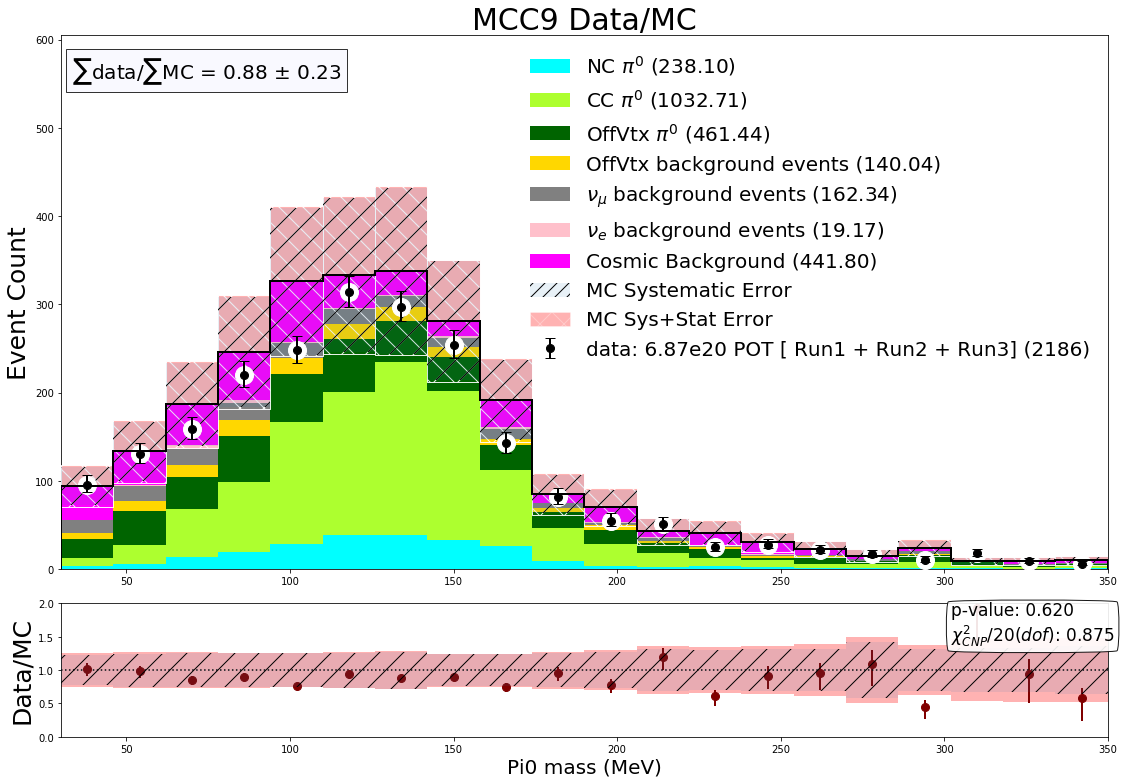

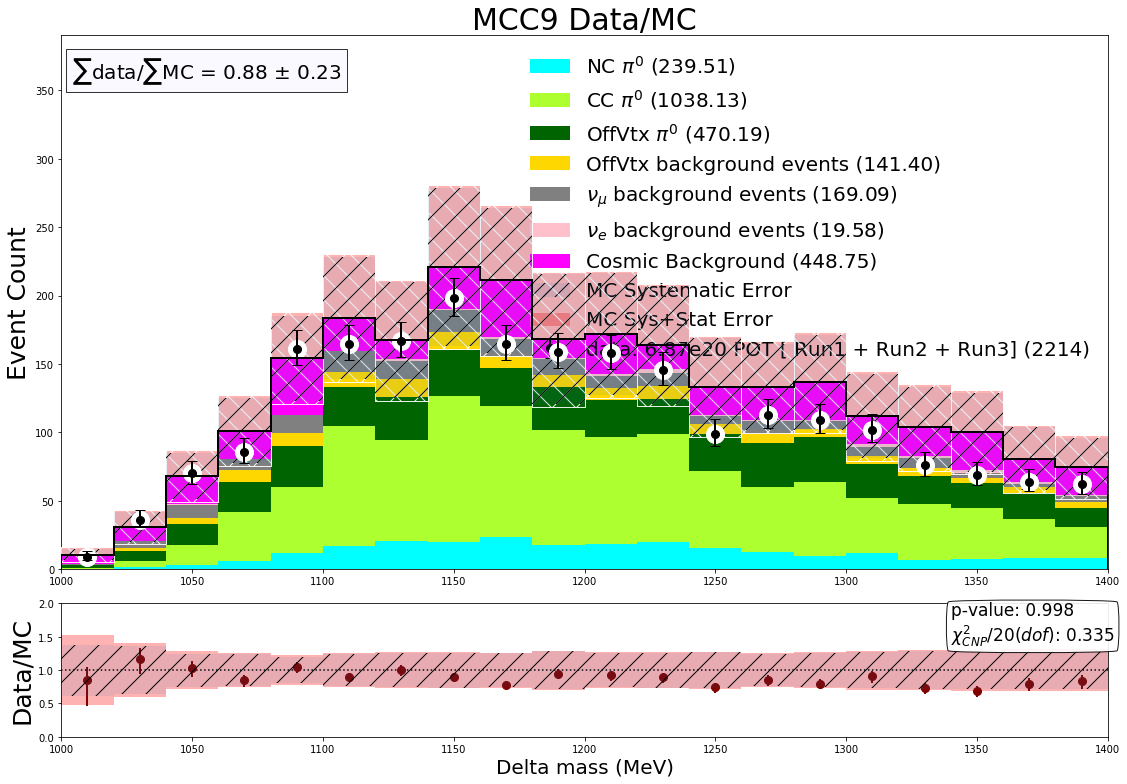

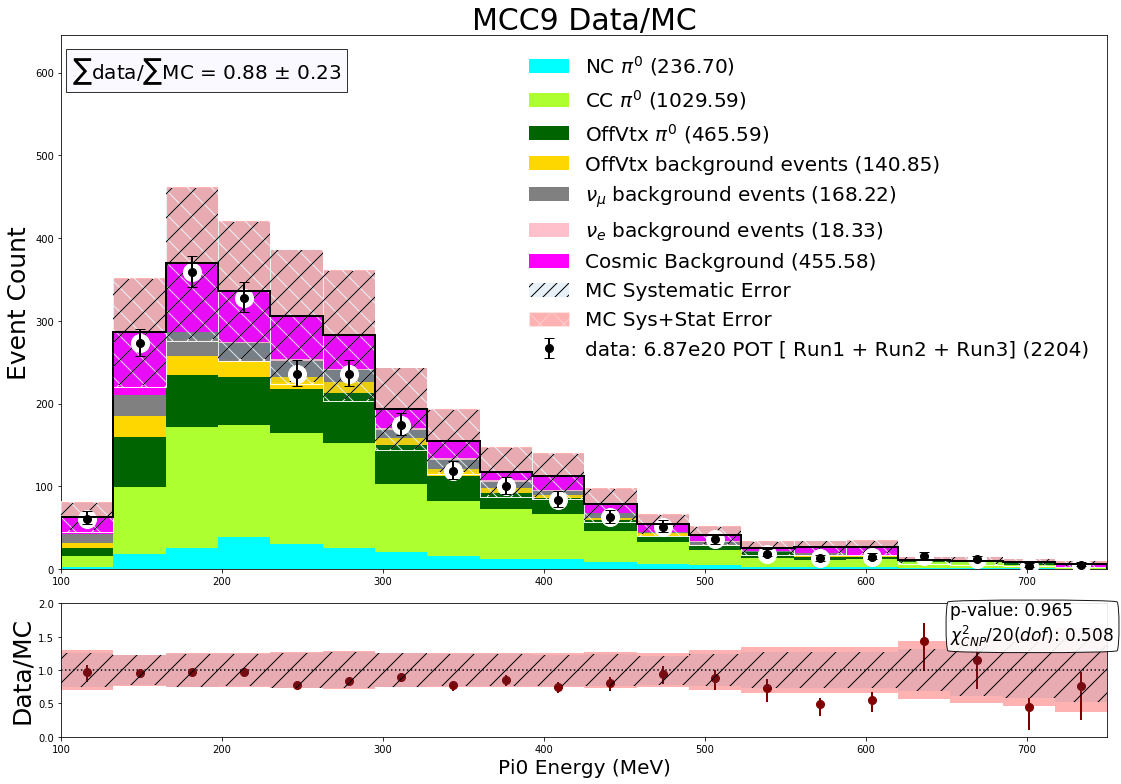

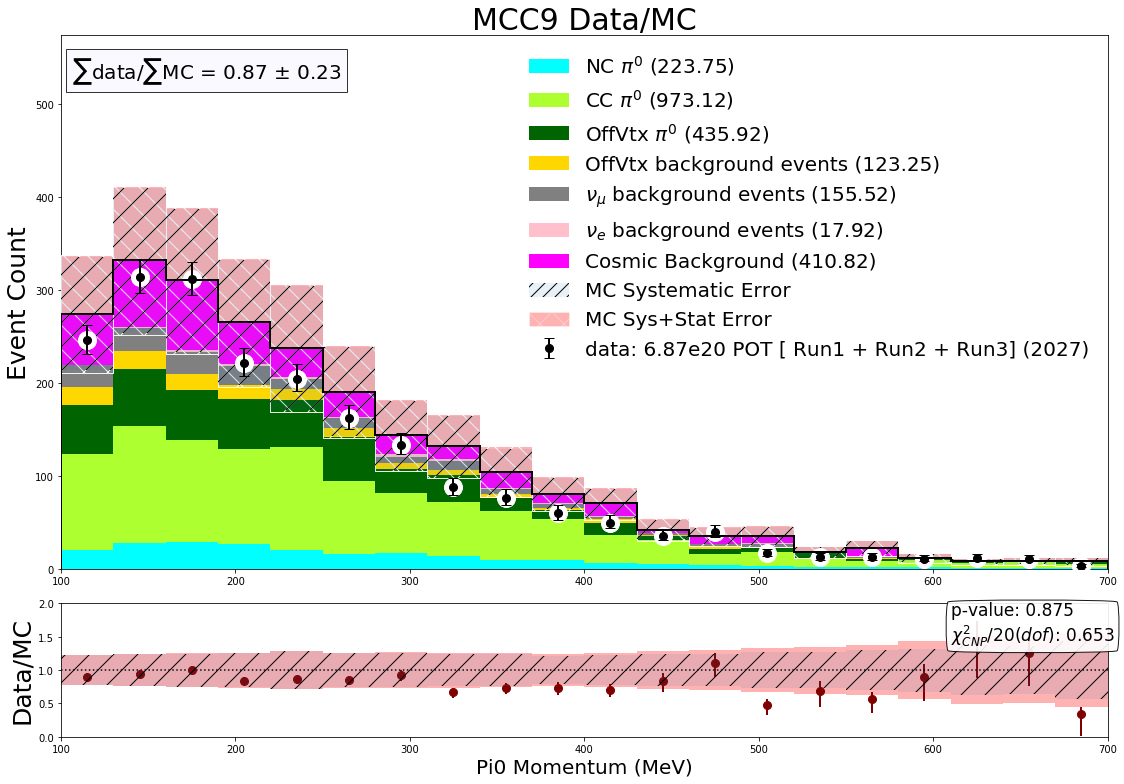

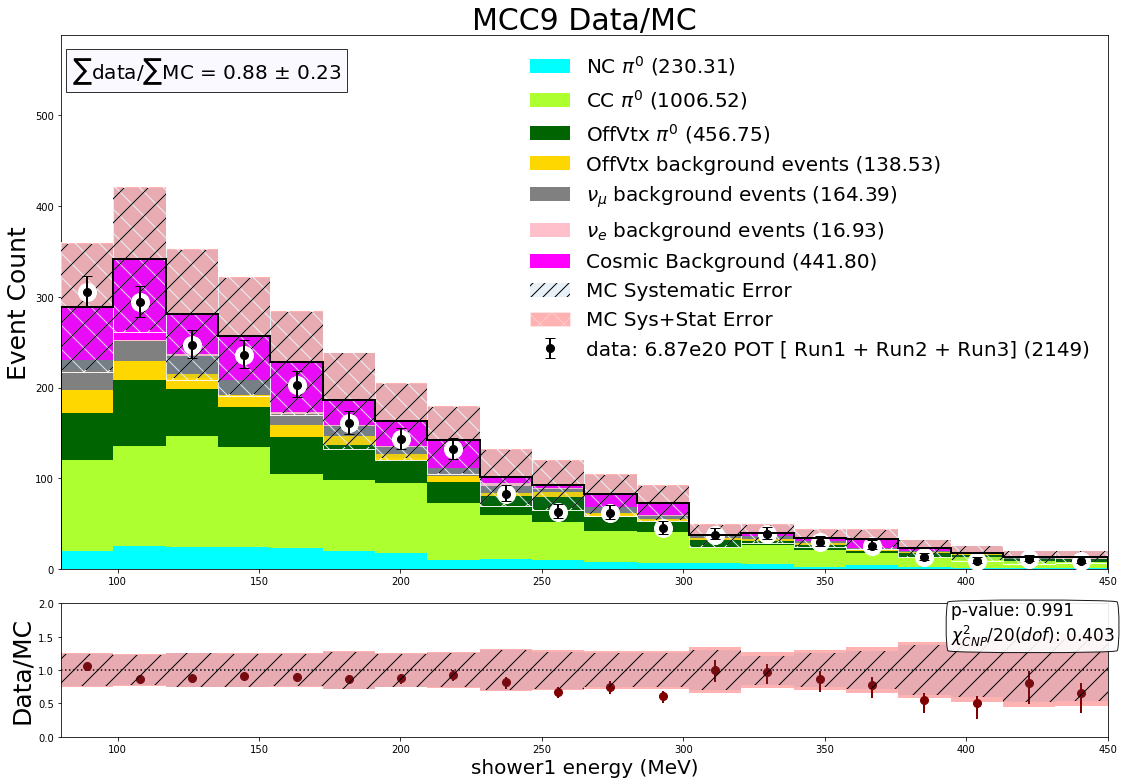

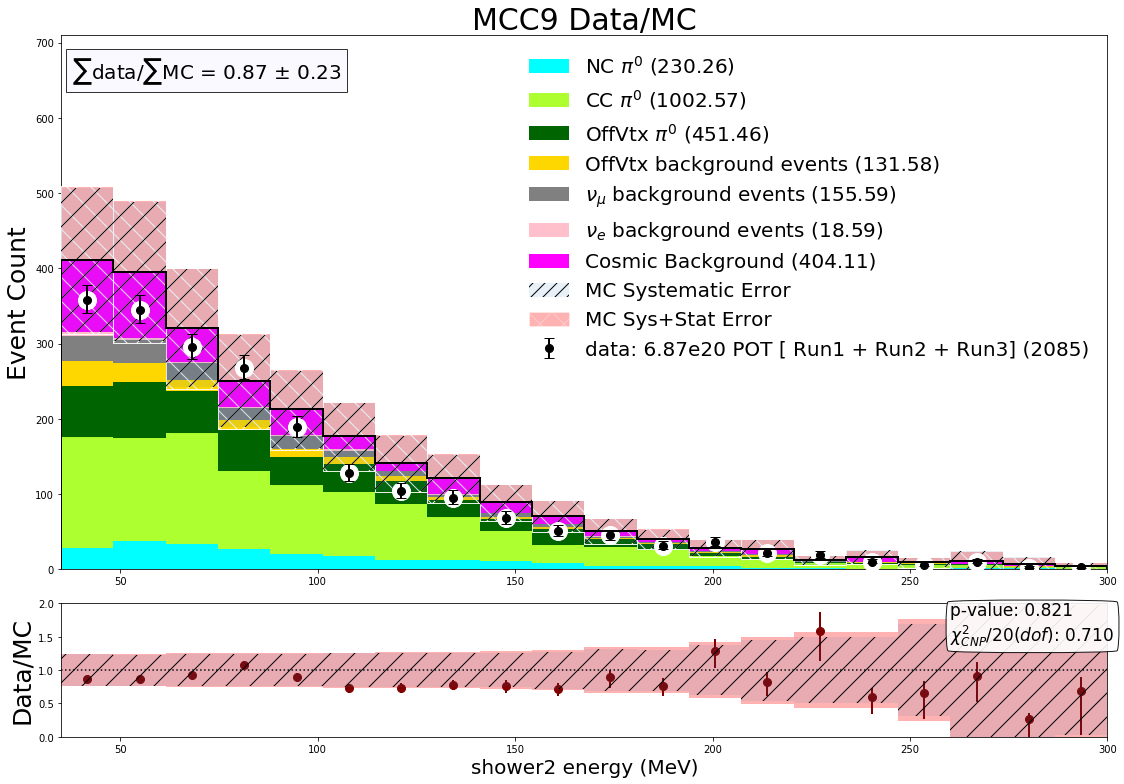

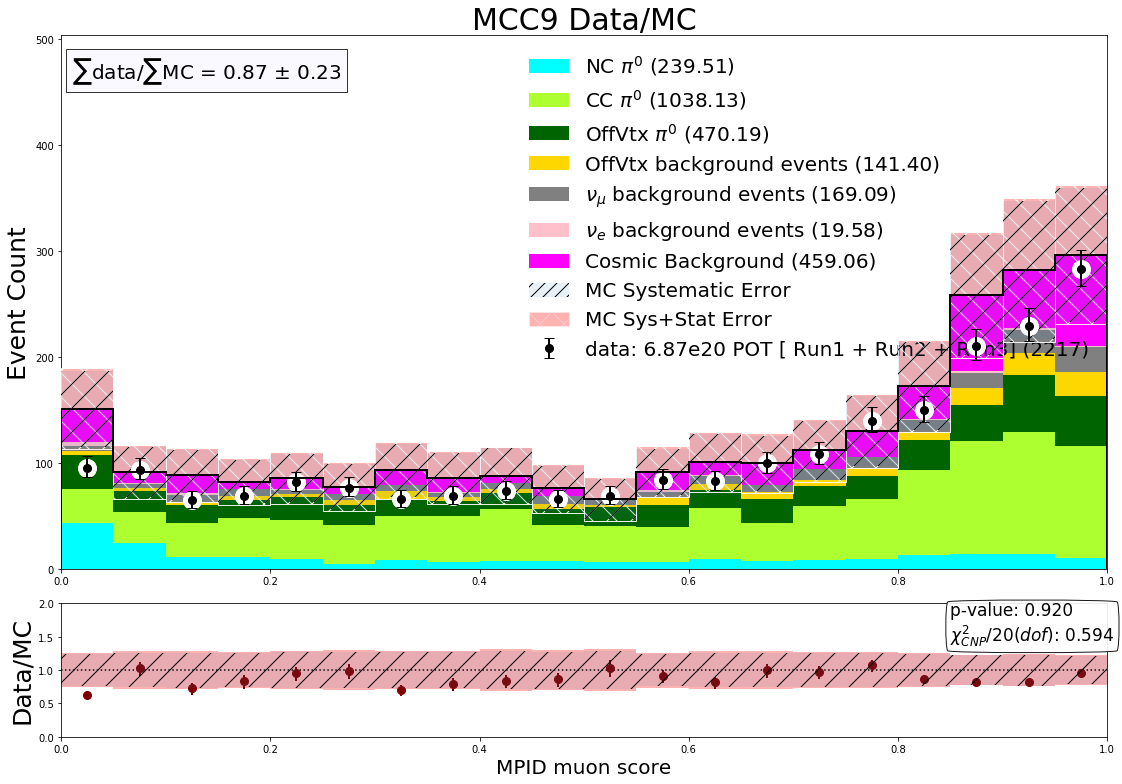

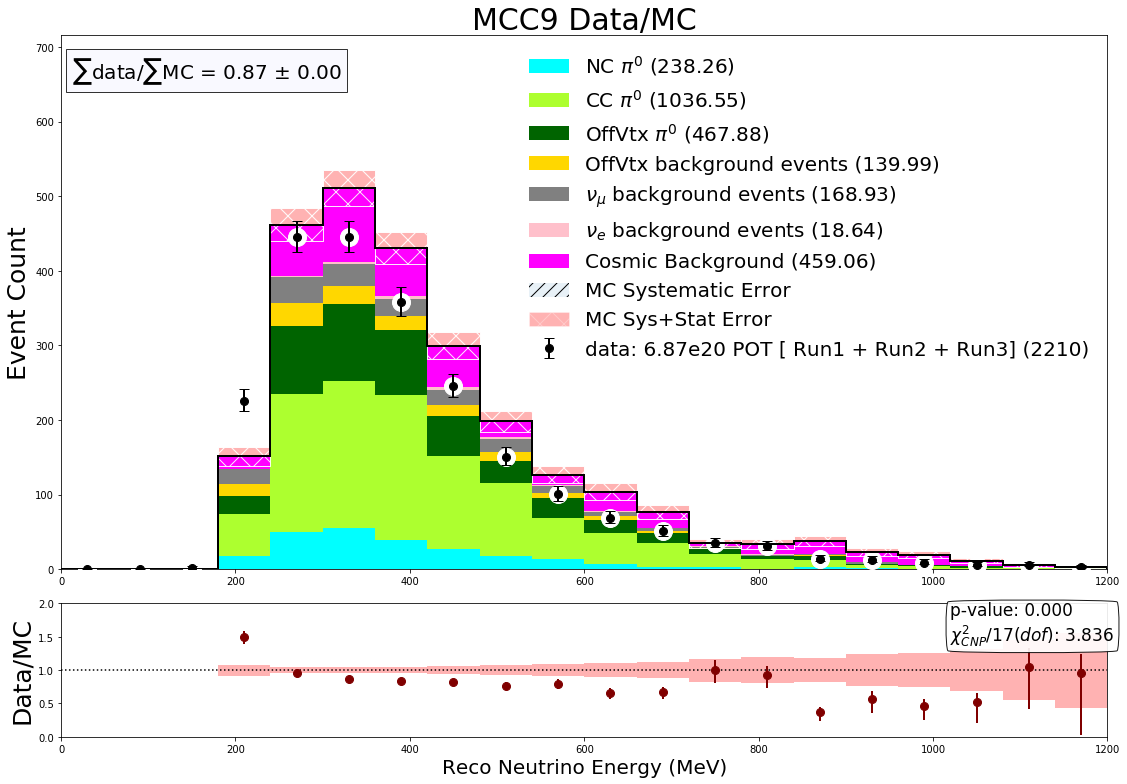

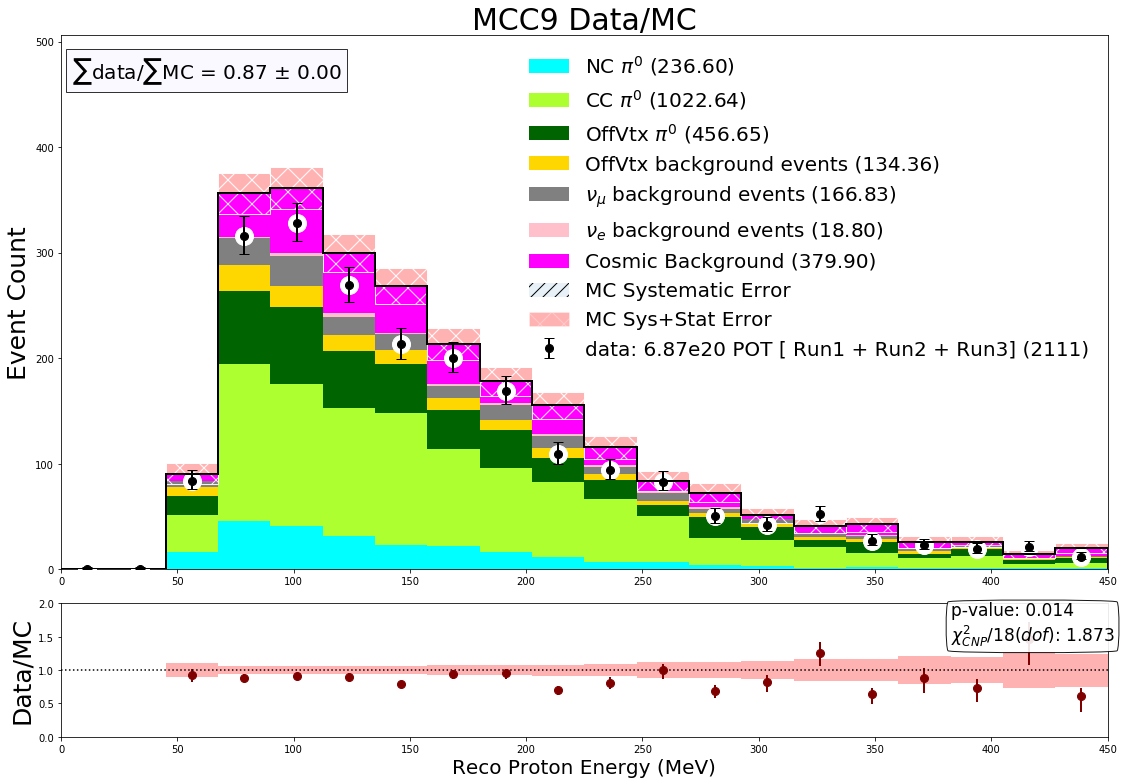

In [25]:
norm = 1.0
print()
print('xsec_corr_weight' in df_nue_total.keys())
with PdfPages('output_combined_20210205_highstatsrun1.pdf') as pdf:

    for i in range(len(vartest_list)):
        vartest = vartest_list[i]
        varname = varname_list[i]
        myrange = myrange_list[i]
        nbins =bins_list[i]
        
        if sys_list[i] == 'none':
            s_cov = np.zeros((nbins,nbins))
        else:
            s_cov = np.genfromtxt(sys_list[i],delimiter=',')
        
        
        if detvar1_list[i] == 'none':
            d_cov = np.zeros((nbins,nbins))
        else:
            d_cov1 = np.genfromtxt(detvar1_list[i],delimiter=',')
            d_cov3 = np.genfromtxt(detvar3_list[i],delimiter=',')
            d_cov = ((DATA_R1_PI0FILTER_POT)*d_cov1 + (DATA_R2D_PI0FILTER_POT+DATA_R2E_PI0FILTER_POT+DATA_R3F_PI0FILTER_POT+DATA_R3G_PI0FILTER_POT)*d_cov3)/(DATA_R1_PI0FILTER_POT+DATA_R2D_PI0FILTER_POT+DATA_R2E_PI0FILTER_POT+DATA_R3F_PI0FILTER_POT+DATA_R3G_PI0FILTER_POT)
        
        cov = s_cov +d_cov
#         cov = np.zeros((nbins,nbins))
        print('xsec_corr_weight' in df_ccpi0_total.keys())
        run1_open_Hists = StackedHisto((df_numu_total.query('(newhaspi0==0 and MC_parentPDG ==14) or MC_parentPDG ==-14'),df_nue_total.query('MC_parentPDG == 12'),df_ncpi0_total,df_ccpi0_total),(1.0,1.0,1.0,1.0))
        run1_open_Hists.AddStrata('haspi0==1 and ccnc==1 and MC_scedr<5 ',r"NC $\pi^0$",'cyan')
        run1_open_Hists.AddStrata('haspi0==1 and ccnc!=1 and MC_scedr<5 ',r"CC $\pi^0$",'greenyellow')
        run1_open_Hists.AddStrata('haspi0==1 and MC_scedr>=5 ',r"OffVtx $\pi^0$",'darkgreen')
        run1_open_Hists.AddStrata('MC_parentPDG ==14 and haspi0==0 and MC_scedr>=5 ',r"OffVtx background events",'gold')
        run1_open_Hists.AddStrata('MC_parentPDG ==14 and haspi0==0 and MC_scedr<5',r"$\nu_\mu$ background events",'grey')
        run1_open_Hists.AddStrata('MC_parentPDG ==12 and haspi0==0',r"$\nu_e$ background events",'pink')
        run1_open_Hists.AddLayer(df_ext_total,df_ext_total['pot_weight'],1.0,'Cosmic Background','fuchsia')
        run1_open_DataHist = SimpleHisto(df_data_total,1.0,0,'','data: 6.87e20 POT [ Run1 + Run2 + Run3]')
        fig1,ax1,_,a = distplot_wratio_davio(vartest,nbins,myrange,run1_open_Hists,run1_open_DataHist,varname,m_cov=cov)
        fig1.savefig(vartest_list[i]+'_20210413.png')

In [26]:
# # # plot the resolution distributions

# # first cut for events with a true pi0 with two contained showers.
# contained_pi0='haspi0==1 and shower_energy_true >=0 and secondshower_energy_true >=0 '
# df_numu_total.query(contained_pi0+'and (newhaspi0==0 and MC_parentPDG ==14) or MC_parentPDG ==-14')
# df_nue_total.query(contained_pi0+'and MC_parentPDG ==12')
# df_ncpi0_total.query(contained_pi0)
# df_ccpi0_total.query(contained_pi0)

# df_nue_r1=df_nue_goodruns_pmtprecut.query("MC_scedr<5 and haspi0==0 and shower_energy_true >=0 and shower1_E_Y_new>=0 and BDTscore_1e1p >.7 ")
# df_nue_r2=df_nue_r2_goodruns_pmtprecut.query("MC_scedr<5 and haspi0==0 and shower_energy_true >=0 and shower1_E_Y_new>=0 and BDTscore_1e1p >.7")
# df_nue_r3=df_nue_r3_goodruns_pmtprecut.query("MC_scedr<5 and haspi0==0 and shower_energy_true >=0 and shower1_E_Y_new>=0 and BDTscore_1e1p >.7")

# def getangleres(df):
# #     funtion to get the angle between true and reco shower directions
#     angleres= []
#     for i in range(len(df)):
#         recox1 = df['shower1_dir_3d_X'].values[i]
#         recoy1 = df['shower1_dir_3d_Y'].values[i]
#         recoz1 = df['shower1_dir_3d_Z'].values[i]
#         recox2 = df['shower2_dir_3d_X'].values[i]
#         recoy2 = df['shower2_dir_3d_Y'].values[i]
#         recoz2 = df['shower2_dir_3d_Z'].values[i]
        
#         truex1 = df['first_direction_true_X'].values[i]
#         truey1 = df['first_direction_true_Y'].values[i]
#         truez1 = df['first_direction_true_Z'].values[i]
#         truex2 = df['second_direction_true_X'].values[i]
#         truey2 = df['second_direction_true_Y'].values[i]
#         truez2 = df['second_direction_true_Z'].values[i]
        
#         dot1 = recox1*recox2+recoy1*recoy2+recoz1*recoz2
#         dot2 = truex1*truex2+truey1*truey2+truez1*truez2
        
#         magreco1 = sqrt(recox1**2+recoy1**2+recoz1**2)             
#         magreco2 = sqrt(recox2**2+recoy2**2+recoz2**2)
#         magtrue1 = sqrt(truex1**2+truey1**2+truez1**2)             
#         magtrue2 = sqrt(truex2**2+truey2**2+truez2**2) 
        
#         cosdir1 = dot1/(magreco1*magreco2)
#         cosdir2 = dot2/(magtrue1*magtrue2)
#         alpha1 = acos(cosdir1) * 180.0 / 3.14159
#         alpha2 = acos(cosdir2) * 180.0 / 3.14159

#         angleres.append((alpha1-alpha2)/alpha2)

#     return angleres




# def getenergyres(df):
# #     funtion to get the angle between true and reco shower directions
#     energyres1 = []
#     energyres2 = []
#     for i in range(len(df)):
#         reco1 = df['shower1_E_Y_new'].values[i]
#         reco2 = df['shower2_E_Y_new'].values[i]
#         if(reco2 >reco1):
#             reco2 = df['shower1_E_Y_new'].values[i]
#             reco1 = df['shower2_E_Y_new'].values[i]
#         true1 = df['gamma_1_true'].values[i]
#         true2 = df['gamma_2_true'].values[i]
#         if (true2>true1):
#             true2 = df['gamma_1_true'].values[i]
#             true1 = df['gamma_2_true'].values[i]
#         print(true1,true2)
        
#         energyres1.append((reco1-true1)/true1)
#         energyres2.append((reco2-true2)/true2)
# #         energyres2.append(-999)

#     return energyres1,energyres2

# # add all of the data frames
# # df_data_total = df_fakedata1_run1_pi0.append(df_fakedata1_run3_pi0)
# df_data_total_1 = df_data_r1_pi0filter_pi0.append(df_data_r3F_pi0filter_pi0)
# df_data_total = df_data_total_1.append(df_data_r3G_pi0filter_pi0)

# print("total number of data pi0: ",len(df_data_total['_pi0mass'].values))
# # scale CV weights:
# def potscale(df,scalefactor=1.0,ext=False):
#     pot_weight = []
#     for i in range(len(df)):
#         if ext==False:
#             pot_weight.append(scalefactor)
#         else:
#             pot_weight.append(scalefactor)
#     return pot_weight

# # general mc
# w_cc_1 =potscale(df_ccpi0_r1_pi0,DATA_R1_PI0FILTER_POT/CCPI0_R1_POT)
# w_cc_3 =potscale(df_ccpi0_r3_pi0,(DATA_R3G_PI0FILTER_POT+DATA_R3F_PI0FILTER_POT)/(CCPI0_R3_POT))
# df_ccpi0_r1_pi0['pot_weight'] = w_cc_1
# df_ccpi0_r3_pi0['pot_weight'] = w_cc_3
# df_ccpi0_total = df_ccpi0_r1_pi0.append(df_ccpi0_r3_pi0)

# w_nc_1 =potscale(df_ncpi0_r1_pi0,DATA_R1_PI0FILTER_POT/NCPI0_R1_POT)
# w_nc_3 =potscale(df_ncpi0_r3_pi0,(DATA_R3G_PI0FILTER_POT+DATA_R3F_PI0FILTER_POT)/(NCPI0_R3a_POT+NCPI0_R3b_POT))
# df_ncpi0_r1_pi0['pot_weight'] = w_nc_1
# df_ncpi0_r3_pi0['pot_weight'] = w_nc_3
# df_ncpi0_total = df_ncpi0_r1_pi0.append(df_ncpi0_r3_pi0)

                 


# a1_cc = getangleres(df_ccpi0_total)
# e1_cc,e2_cc = getenergyres(df_ccpi0_total)
# df_ccpi0_total["AngleRes"]=a1_cc
# # df_ccpi0_total["AngleRes2"]=a2_cc
# df_ccpi0_total["EnergyRes1"]=e1_cc
# df_ccpi0_total["EnergyRes2"]=e2_cc

# a1_nc = getangleres(df_ncpi0_total)
# e1_nc,e2_nc = getenergyres(df_ncpi0_total)
# df_ncpi0_total["AngleRes"]=a1_nc
# # df_ncpi0_total["AngleRes2"]=a2_nc
# df_ncpi0_total["EnergyRes1"]=e1_nc
# df_ncpi0_total["EnergyRes2"]=e2_nc


In [27]:
# vartest_list = []
# varname_list = []
# myrange_list = []
# detvar_list  = []
# sys_list = []
# bins_list = []


# vartest_list.append('AngleRes')
# varname_list.append('Opening Angle Res (reco-true)/true')
# # myrange_list.append((-1,1))
# myrange_list.append((-1,2))
# detvar_list.append('none')
# sys_list.append('none')
# bins_list.append(20)

# # vartest_list.append('AngleRes2')
# # varname_list.append('Cosine Angle between true and reco subleading showers')
# # myrange_list.append((-1,1))
# # # myrange_list.append((0,180))
# # detvar_list.append('none')
# # sys_list.append('none')
# # bins_list.append(20)

# vartest_list.append('EnergyRes1')
# varname_list.append('Energy Res of leading shower (reco-true)/true')
# myrange_list.append((-1,2))
# detvar_list.append('none')
# sys_list.append('none')
# bins_list.append(20)

# vartest_list.append('EnergyRes2')
# varname_list.append('Energy Res of subleading shower (reco-true)/true')
# myrange_list.append((-1,2))
# detvar_list.append('none')
# sys_list.append('none')
# bins_list.append(20)



# for i in range(len(vartest_list)):
#     vartest = vartest_list[i]
#     varname = varname_list[i]
#     myrange = myrange_list[i]
#     nbins =bins_list[i]

#     cov = np.zeros((nbins,nbins))
#     run1_open_Hists = StackedHisto((df_numu_total.query('(newhaspi0==0 and MC_parentPDG ==14) or MC_parentPDG ==-14'),df_nue_total.query('MC_parentPDG ==12'),df_ncpi0_total,df_ccpi0_total),(1.0,1.0,1.0,1.0))
#     run1_open_Hists.AddStrata('haspi0==1 and ccnc==1 and MC_scedr<5 ',r"NC $\pi^0$",'cyan')
#     run1_open_Hists.AddStrata('haspi0==1 and ccnc!=1 and MC_scedr<5 ',r"CC $\pi^0$",'greenyellow')
#     run1_open_Hists.AddStrata('haspi0==1 and MC_scedr>=2 ',r"OffVtx $\pi^0$",'darkgreen')
# #     run1_open_Hists.AddStrata('MC_parentPDG ==14 and haspi0==0 and MC_scedr>=5 ',r"OffVtx background events",'gold')
# #     run1_open_Hists.AddStrata('MC_parentPDG ==14 and haspi0==0 and MC_scedr<5',r"$\nu_\mu$ background events",'grey')
# # #         run1_open_Hists.AddStrata('MC_parentPDG ==14',r"$\nu_mu$ events",'blue')
# #     run1_open_Hists.AddStrata('MC_parentPDG ==12 and haspi0==0',r"$\nu_e$ background events",'pink')
#     fig1,ax1 = distplot_mc(vartest,nbins,myrange,run1_open_Hists,varname)
#     fig1.savefig(vartest_list[i]+'_20210413.png')
    

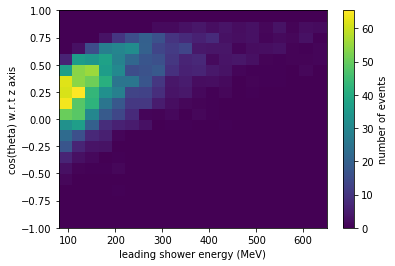

In [40]:
# make 2d hist:
import matplotlib

dftest1= df_ncpi0_total.append(df_ccpi0_total)
dftest2= dftest1.append(df_numu_total.query('(newhaspi0==0 and MC_parentPDG ==14) or MC_parentPDG ==-14'))
dftest= dftest2.append(df_nue_total.query('MC_parentPDG == 12'))


var_e =dftest['shower1_E_Y_new'].values
var_e2 =dftest['shower2_E_Y_new'].values
var_w1=dftest['pot_weight'].values
var_w2=dftest['xsec_corr_weight'].values
var_x =dftest['shower1_dir_3d_X'].values
var_y =dftest['shower1_dir_3d_Y'].values
var_z =dftest['shower1_dir_3d_Z'].values

# var_x =dftest['first_direction_true_X'].values
# var_y =dftest['first_direction_true_Y'].values
# var_z =dftest['first_direction_true_Z'].values
var_cos =[]
var_w = []
for i in range(len(dftest)):
#     mag = math.sqrt(var_x[i]**2+var_y[i]**2+var_z[i]**2)
#     var_cos.append((var_x[i]+var_y[i])/mag)
    var_cos.append((var_e[i]-var_e2[i])/(var_e[i]+var_e2[i]))
    var_w.append(var_w1[i]*var_w2[i])

plt.hist2d(var_e, var_cos, bins=(20, 20), range = ((80,650),(-1,1)),weights=var_w)

plt.xlabel('leading shower energy (MeV)')
plt.ylabel('cos(theta) w.r.t z axis')
plt.colorbar(label='number of events')

# plt.show()



In [245]:
# # electron simple resolution

# print(df_nue_r1["EnergyRes1"].values)
# vartest = "EnergyRes1"
# varname = 'Energy Res of electron (reco-true)/true'
# myrange = [-1,2]
# nbins =20

# cov = np.zeros((nbins,nbins))
# run1_open_Hists = StackedHisto((df_nue_r1,df_nue_r3,df_nue_r3),(1.0,1.0,1.0))
# # run1_open_Hists.AddStrata('haspi0==1 and ccnc==1 and MC_scedr<5 ',r"NC $\pi^0$",'cyan')
# # run1_open_Hists.AddStrata('haspi0==1 and ccnc!=1 and MC_scedr<5 ',r"CC $\pi^0$",'greenyellow')
# # run1_open_Hists.AddStrata('haspi0==1 and MC_scedr>=2 ',r"OffVtx $\pi^0$",'darkgreen')
# # run1_open_Hists.AddStrata('MC_parentPDG ==14 and haspi0==0 and MC_scedr>=5 ',r"OffVtx background events",'gold')
# # run1_open_Hists.AddStrata('MC_parentPDG ==14 and haspi0==0 and MC_scedr<5',r"$\nu_\mu$ background events",'grey')
# #         run1_open_Hists.AddStrata('MC_parentPDG ==14',r"$\nu_mu$ events",'blue')
# run1_open_Hists.AddStrata('haspi0==1 or haspi0==0',r"$\nu_e$ simulated events",'pink')
# fig1,ax1 = distplot_mc(vartest,nbins,myrange,run1_open_Hists,varname)
# fig1.savefig('electronres_20210413.png')

In [246]:
# # choose mpid muon cut value

# pur_NC = []
# pur_CC = []
# cutvals= [.01*i for i in range(1,99)]

# eff_NC=[]
# eff_CC=[]


# for cut in cutvals:
#     muoncut = str(cut)
#     countcc=len(df_numu_total.query('haspi0 ==1 and ccnc==0 and MC_scedr<5 and MPID_muon >=' + muoncut))
#     totalcc=len(df_numu_total.query('haspi0 ==1 and MC_scedr<5 and MPID_muon >=' + muoncut))
#     countnc=len(df_numu_total.query('haspi0 ==1 and MC_scedr<5 and ccnc==1 and MPID_muon <' + muoncut))
#     totalnc=len(df_numu_total.query('haspi0 ==1 and MC_scedr<5 and MPID_muon <' + muoncut))
#     pur_CC.append(float(countcc)/float(totalcc))
#     pur_NC.append(float(countnc)/float(totalnc))
#     print(float(countnc)/float(totalnc), cut)
#     eff_CC.append(float(countcc)/float(len(df_numu_total.query('haspi0 ==1 and ccnc==0 and MC_scedr<5' ))))
#     eff_NC.append(float(countnc)/float(len(df_numu_total.query('haspi0 ==1 and ccnc==1 and MC_scedr<5' ))))
    
# plt.scatter(cutvals,pur_NC,color ='blue',label = "NC purity",marker='.')
# plt.scatter(cutvals,pur_CC,color ='red',label = "CC purity",marker='.')
# plt.legend()
# plt.xlabel('Muon MPID cut value')
# plt.ylabel('sample purity (cc or nc)pi0/totalpi0')
# plt.show()
# plt.close()

# plt.scatter(cutvals,eff_NC,color ='blue',label = "NC eff",marker='.')
# plt.scatter(cutvals,eff_CC,color ='red',label = "CC eff",marker='.')
# plt.legend()
# plt.xlabel('Muon MPID cut value')
# plt.ylabel('sample efficiency (cc or nc)pi0 in cut /total(cc or nc) pi0')
# plt.show()

In [247]:
# reset covariance matrices for weighted
detvar1_list  = []
detvar3_list  = []
sys_list = []

sys_list.append('../systematics/covar_pi0_weighted__pi0_mass_reco.txt')
detvar1_list.append('HighstatsDetVar/outputs/covMatrix2021-02-10/detsys__pi0mass_new_run1_cov.csv')
detvar3_list.append('HighstatsDetVar/outputs/covMatrix2021-02-10/detsys__pi0mass_new_run3_cov.csv')


detvar1_list.append('HighstatsDetVar/outputs/covMatrix2021-02-10/detsys_DeltaMass_new_run1_cov.csv')
detvar3_list.append('HighstatsDetVar/outputs/covMatrix2021-02-10/detsys_DeltaMass_new_run3_cov.csv')
sys_list.append('../systematics/covar_pi0_weighted__Delta_mass_reco.txt')

detvar1_list.append('HighstatsDetVar/outputs/covMatrix2021-02-10/detsys_pi0_energy_reco_new_run1_cov.csv')
detvar3_list.append('HighstatsDetVar/outputs/covMatrix2021-02-10/detsys_pi0_energy_reco_new_run3_cov.csv')
sys_list.append('../systematics/covar_pi0_weighted__pi0_energy_reco.txt')

detvar1_list.append('HighstatsDetVar/outputs/covMatrix2021-02-10/detsys_pi0_momentum_reco_new_run1_cov.csv')
detvar3_list.append('HighstatsDetVar/outputs/covMatrix2021-02-10/detsys_pi0_momentum_reco_new_run3_cov.csv')
sys_list.append('../systematics/covar_pi0_weighted__pi0_momentum_reco.txt')

detvar1_list.append('HighstatsDetVar/outputs/covMatrix2021-02-10/detsys_shower1_E_Y_new_run1_cov.csv')
detvar3_list.append('HighstatsDetVar/outputs/covMatrix2021-02-10/detsys_shower1_E_Y_new_run3_cov.csv')
sys_list.append('../systematics/covar_pi0_weighted__shower1_energy_reco.txt')

detvar1_list.append('HighstatsDetVar/outputs/covMatrix2021-02-10/detsys_shower2_E_Y_new_run1_cov.csv')
detvar3_list.append('HighstatsDetVar/outputs/covMatrix2021-02-10/detsys_shower2_E_Y_new_run3_cov.csv')
sys_list.append('../systematics/covar_pi0_weighted__shower2_energy_reco.txt')

detvar1_list.append('HighstatsDetVar/outputs/covMatrix2021-02-10/detsys_MPID_muon_run1_cov.csv')
detvar3_list.append('HighstatsDetVar/outputs/covMatrix2021-02-10/detsys_MPID_muon_run3_cov.csv')
sys_list.append('../systematics/covar_pi0_weighted__mpid_muon_score.txt')

detvar1_list.append('none')
detvar3_list.append('none')
sys_list.append('none')

detvar1_list.append('none')
detvar3_list.append('none')
sys_list.append('none')

/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:132: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



2411
4568
3398
696
827
3345
hstack gh_weights [0.11492766 0.10062297 0.13061237 ... 1.         1.         1.        ]
hstack gh_scale [1.        1.        1.        ... 0.7978831 0.7978831 0.7978831]
SUM 210.28927890958695
SUM 984.3537863750299
SUM 411.3557660909459
SUM 144.12465468714169
SUM 167.33133463959823
SUM 18.47657738537041
SUM 213.14792555022197
Normalization Uncertainty: 0.23403528888524852
yerr_mc_total [18.34015245 28.65195654 39.25267664 52.45146129 69.85767375 80.14055007
 90.68214602 66.63040524 44.26517277 21.64092195 18.36473701 13.17791975
 11.52530452  8.20513467  7.60387969  6.90572312  8.07405001  3.92431699
  3.72086179  4.57120081]
yerr_data 177.66508203397848
ERROR HERE
[0.11655734 0.09515266 0.0749422  0.06502563 0.05253908 0.05310142
 0.04991836 0.05313191 0.06018504 0.10212503 0.09658368 0.15854844
 0.11901977 0.1907363  0.20301037 0.22902793 0.12956645 0.36008588
 0.25509409 0.17883833]
[0.14463867 0.1137718  0.08851155 0.07504042 0.05997523 0.05982017
 0.0

/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:132: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



2411
4568
3398
696
827
3345
hstack gh_weights [0.11492766 0.10062297 0.13061237 ... 1.         1.         1.        ]
hstack gh_scale [1.        1.        1.        ... 0.7978831 0.7978831 0.7978831]
SUM 211.7133978121097
SUM 989.3747392589773
SUM 418.7286129317511
SUM 145.5282561005137
SUM 174.26362297400573
SUM 18.876005784555378
SUM 215.01216696814384
Normalization Uncertainty: 0.2306350160871072
yerr_mc_total [ 4.09208536 10.18130458 16.76263163 23.94020114 30.26507887 44.96297316
 42.90286702 56.80561069 48.48174832 45.90076839 40.17214228 40.80736492
 31.5197803  28.34231213 28.50722746 25.7982617  25.16322126 22.85256085
 19.39474775 17.54534245]
yerr_data 197.9175141316574
ERROR HERE
[0.24183533 0.1921522  0.11677071 0.08710049 0.0830977  0.06376938
 0.07014152 0.06022717 0.06088079 0.0725775  0.0764315  0.07287106
 0.07561849 0.08285627 0.08452669 0.10233662 0.09342666 0.09402609
 0.10883489 0.11600291]
[0.51346507 0.27171397 0.15065953 0.10865568 0.09765401 0.07514422
 0.0825

/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:132: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



2411
4568
3398
696
827
3345
hstack gh_weights [0.11492766 0.10062297 0.13061237 ... 1.         1.         1.        ]
hstack gh_scale [1.        1.        1.        ... 0.7978831 0.7978831 0.7978831]
SUM 209.88564227048482
SUM 980.6260574688328
SUM 414.68829516251174
SUM 144.94631715057636
SUM 173.3559430603649
SUM 17.7229307637762
SUM 216.33945793895612
Normalization Uncertainty: 0.23500199315232712
yerr_mc_total [15.98570741 62.4318721  89.7445259  79.57165926 73.52472583 68.60170831
 41.84253012 32.39439849 24.29400677 21.13930086 16.05326928 10.99211213
  8.89099862  6.99987546  6.57676028  6.59518611  4.81255613  4.42357826
  4.50317378  2.85114167]
yerr_data 174.889667734678
ERROR HERE
[0.12491877 0.0556801  0.04921673 0.05176993 0.05213196 0.05640484
 0.07130306 0.07883765 0.09438819 0.0906619  0.1103329  0.1480629
 0.16183194 0.17517789 0.11334756 0.15640992 0.30896002 0.2663039
 0.15603369 0.32356085]
[0.16186416 0.06321249 0.05493296 0.05817561 0.05951048 0.06470767
 0.083749

/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:132: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



2411
4568
3398
696
827
3345
hstack gh_weights [0.11492766 0.10062297 0.13061237 ... 1.         1.         1.        ]
hstack gh_scale [1.        1.        1.        ... 0.7978831 0.7978831 0.7978831]
SUM 194.02191610039173
SUM 910.4915015298711
SUM 382.6606163366396
SUM 126.96682370705831
SUM 160.3349420699642
SUM 17.308002543151588
SUM 193.98364607085472
Normalization Uncertainty: 0.2344349551141232
yerr_mc_total [62.71305547 75.79210827 71.19826612 61.7971214  60.65934086 40.87238781
 31.65754496 27.50733019 20.15133129 14.13159981 12.95583383  9.25512134
  8.37278303  8.57555768  5.60999688  5.90521979  4.30151793  3.53934984
  3.62144095  4.45566066]
yerr_data 168.2873720732425
ERROR HERE
[0.05295931 0.05142632 0.05767507 0.05718151 0.06284878 0.07223048
 0.08774391 0.07767228 0.09420951 0.10502675 0.11558205 0.14796795
 0.18589592 0.11428892 0.17734188 0.15897576 0.25299626 0.41326685
 0.30424523 0.1285845 ]
[0.06045493 0.05793312 0.06494491 0.06568576 0.07258258 0.08506729
 0.104

/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:132: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



2411
4568
3398
696
827
3345
hstack gh_weights [0.11492766 0.10062297 0.13061237 ... 1.         1.         1.        ]
hstack gh_scale [1.        1.        1.        ... 0.7978831 0.7978831 0.7978831]
SUM 207.0853994688854
SUM 963.919136884673
SUM 405.2699177283382
SUM 142.5393971194329
SUM 169.4177779051326
SUM 16.4854972592391
SUM 209.41944271437796
Normalization Uncertainty: 0.2368202165965285
yerr_mc_total [69.02130153 73.20654191 69.93217501 60.0240728  49.79214234 46.45493789
 35.20575028 31.0135907  26.98629608 23.01205186 18.15515933 15.39090696
 10.62407387  8.69156601  8.22913549  8.16083809  7.77705816  7.09230295
  5.73715781  5.94953696]
yerr_data 179.19643480577906
ERROR HERE
[0.05759847 0.05031395 0.05355097 0.0595171  0.06597727 0.06805304
 0.07631754 0.08657058 0.0919621  0.09114742 0.10635201 0.10005586
 0.174756   0.16613878 0.17226752 0.14784927 0.10942621 0.13511079
 0.17834252 0.18401894]
[0.0648724  0.05681737 0.06097406 0.06814704 0.07640265 0.08056635
 0.0912510

/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:132: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



2411
4568
3398
696
827
3345
hstack gh_weights [0.11492766 0.10062297 0.13061237 ... 1.         1.         1.        ]
hstack gh_scale [1.        1.        1.        ... 0.7978831 0.7978831 0.7978831]
SUM 203.75266762137565
SUM 956.9779397729487
SUM 401.6903776266268
SUM 135.62996519960762
SUM 160.25107574151397
SUM 18.023483324756626
SUM 195.0575469650742
Normalization Uncertainty: 0.23114285502526713
yerr_mc_total [87.6329344  85.08201974 74.53220703 58.15262044 46.57094375 41.09518513
 33.98190847 26.98656339 20.62110132 17.30801602 14.17928227 11.43100673
  9.36263017 10.03476676  5.69657633  6.52862968  5.92644281  9.51947692
  5.66917719  3.92720563]
yerr_data 167.02134580137331
ERROR HERE
[0.04645415 0.04784946 0.05324795 0.0651782  0.0670187  0.06444708
 0.07188654 0.0827085  0.09916506 0.10514153 0.13573502 0.1354658
 0.21043649 0.17106424 0.35831783 0.20529704 0.20848095 0.28629879
 0.14245706 0.26029685]
[0.05198462 0.0535269  0.06005018 0.07403389 0.07796588 0.07728585
 0.08

/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:132: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



2411
4568
3398
696
827
3345
hstack gh_weights [0.11492766 0.10062297 0.13061237 ... 1.         1.         1.        ]
hstack gh_scale [1.        1.        1.        ... 0.7978831 0.7978831 0.7978831]
SUM 211.71339781210963
SUM 989.3747392589776
SUM 418.7286129317511
SUM 145.52825610051374
SUM 174.2636229740058
SUM 18.876005784555378
SUM 218.20369935687802
Normalization Uncertainty: 0.2287191377494037
yerr_mc_total [30.10587195 22.54795832 22.68213442 20.38017824 23.54872715 21.52167193
 23.64035054 21.80934627 24.91375045 20.21534081 19.93511426 20.87470362
 26.05606804 25.10975315 26.46597984 32.16798702 37.88208244 48.27851231
 57.05087858 54.00446909]
yerr_data 200.1867059557429
ERROR HERE
[0.06741232 0.10370002 0.08677591 0.09508162 0.09709753 0.10128734
 0.08649698 0.08996782 0.09237947 0.09903819 0.11117405 0.098246
 0.08232867 0.09918611 0.09417859 0.08974135 0.07306053 0.06087655
 0.05748891 0.06224432]
[0.08365349 0.12820699 0.11244034 0.12217666 0.12199696 0.12848669
 0.11071

/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:132: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



2411
4568
3398
696
827
3345
hstack gh_weights [0.11492766 0.10062297 0.13061237 ... 1.         1.         1.        ]
hstack gh_scale [1.        1.        1.        ... 0.7978831 0.7978831 0.7978831]
SUM 210.85599419946078
SUM 987.3409357534165
SUM 416.55304049666864
SUM 144.06333170173153
SUM 174.09541040598643
SUM 18.002331240259544
SUM 218.20369935687802
Normalization Uncertainty: 0.0
yerr_mc_total [ 0.          0.          0.         12.23859058 21.33313282 21.45108549
 19.34448778 15.65785427 12.80705061  9.98044996  9.23591041  7.80568639
  5.10592686  5.23757188  4.91688938  4.21386964  3.55121174  2.80250804
  1.72690535  1.81719902]
yerr_data 154.85770905865957
ERROR HERE
[ 0.          0.          0.          0.07715312  0.04146902  0.0420935
  0.04659659  0.06189287  0.06852152  0.09153483  0.09358844  0.11359154
  0.18538194  0.21346106  0.10894532  0.1867295   0.17662356  0.24870242
  0.48007358 -0.0526028 ]
[0.         0.         0.         0.09029828 0.045989   0.04652059

/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:422: RuntimeWarning: invalid value encountered in true_divide
/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:132: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



2411
4568
3398
696
827
3345
hstack gh_weights [0.11492766 0.10062297 0.13061237 ... 1.         1.         1.        ]
hstack gh_scale [1.        1.        1.        ... 0.7978831 0.7978831 0.7978831]
SUM 209.4042647382135
SUM 974.0964332288812
SUM 404.8124459301028
SUM 138.22152441707456
SUM 171.89613247787838
SUM 18.106199094187
SUM 182.54480748673032
Normalization Uncertainty: 0.0
yerr_mc_total [ 0.          0.          8.98476479 18.0925972  18.01682631 16.25575032
 15.55037337 13.37788488 12.91102408 11.47277566  9.87256711  8.64147429
  7.64908324  6.62762376  6.00339975  6.0595755   4.74956762  4.75589734
  3.50810886  4.10905788]
yerr_data 172.32772572547645
ERROR HERE
[0.         0.         0.09108185 0.05041401 0.05086028 0.05612074
 0.05497985 0.07041951 0.07111296 0.06934628 0.0855883  0.10971075
 0.1000218  0.11985022 0.15505453 0.1261082  0.19599974 0.1398349
 0.26329926 0.15519151]
[0.         0.         0.11554065 0.05664059 0.05715341 0.06383037
 0.06333207 0.08157948 0

/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:422: RuntimeWarning: invalid value encountered in true_divide


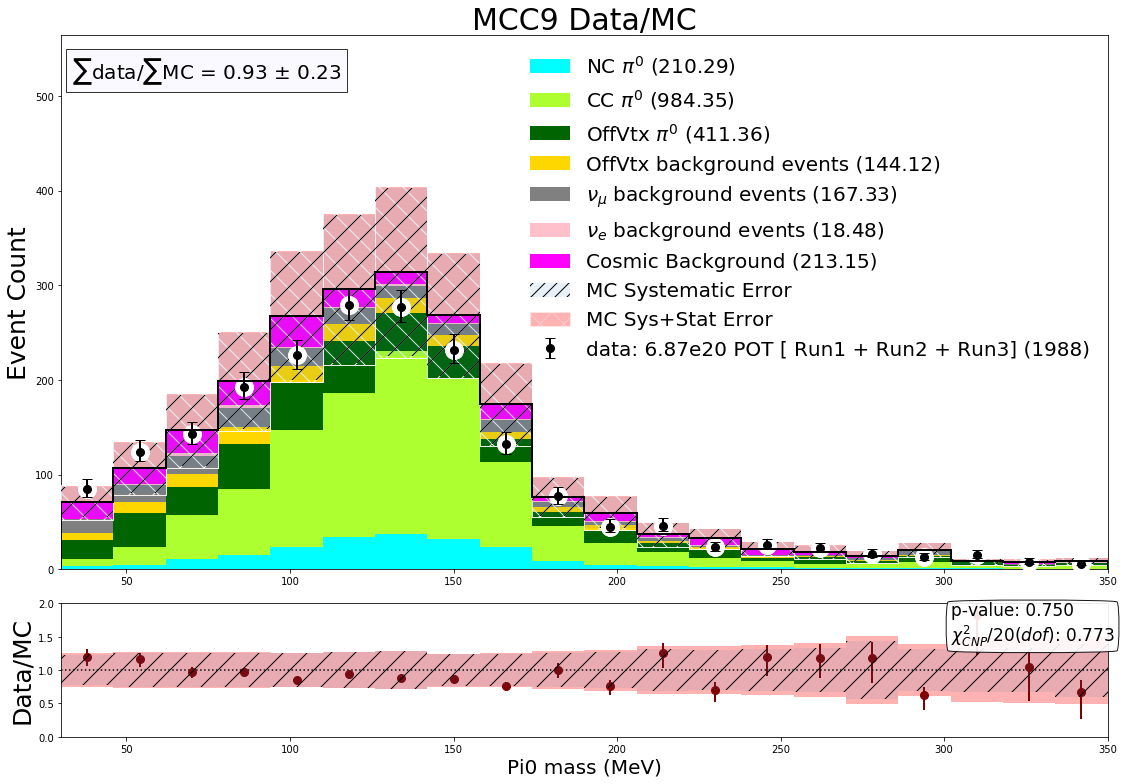

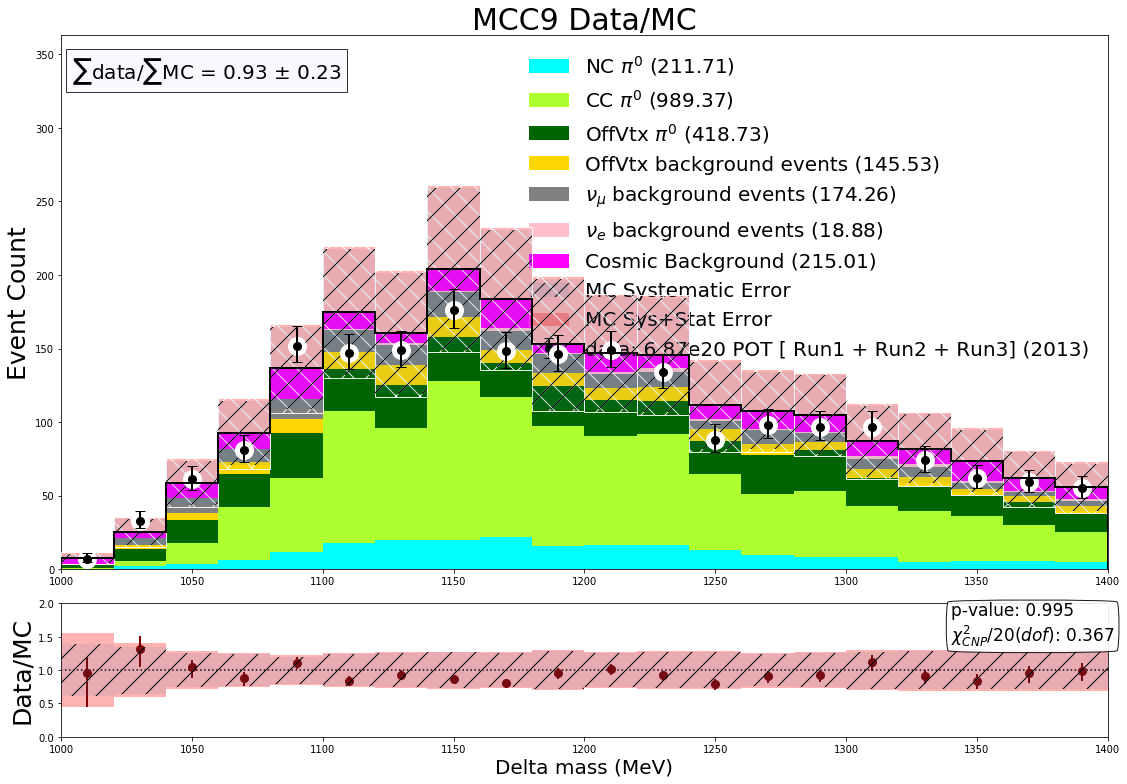

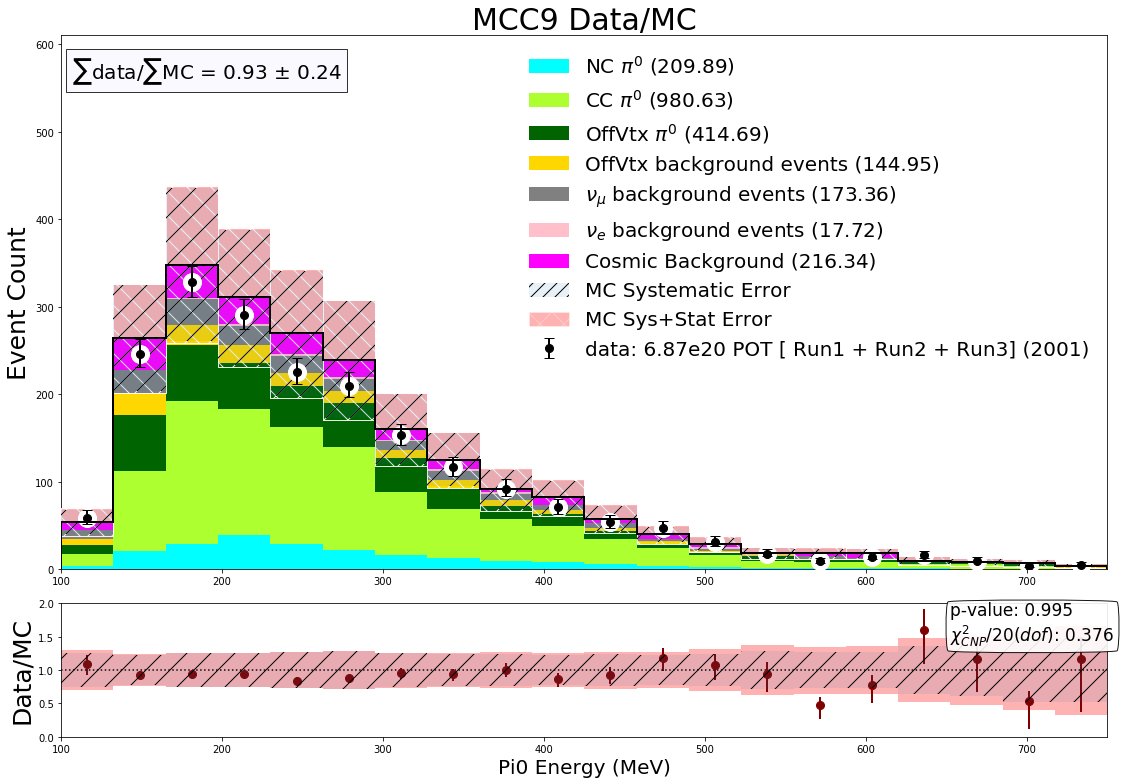

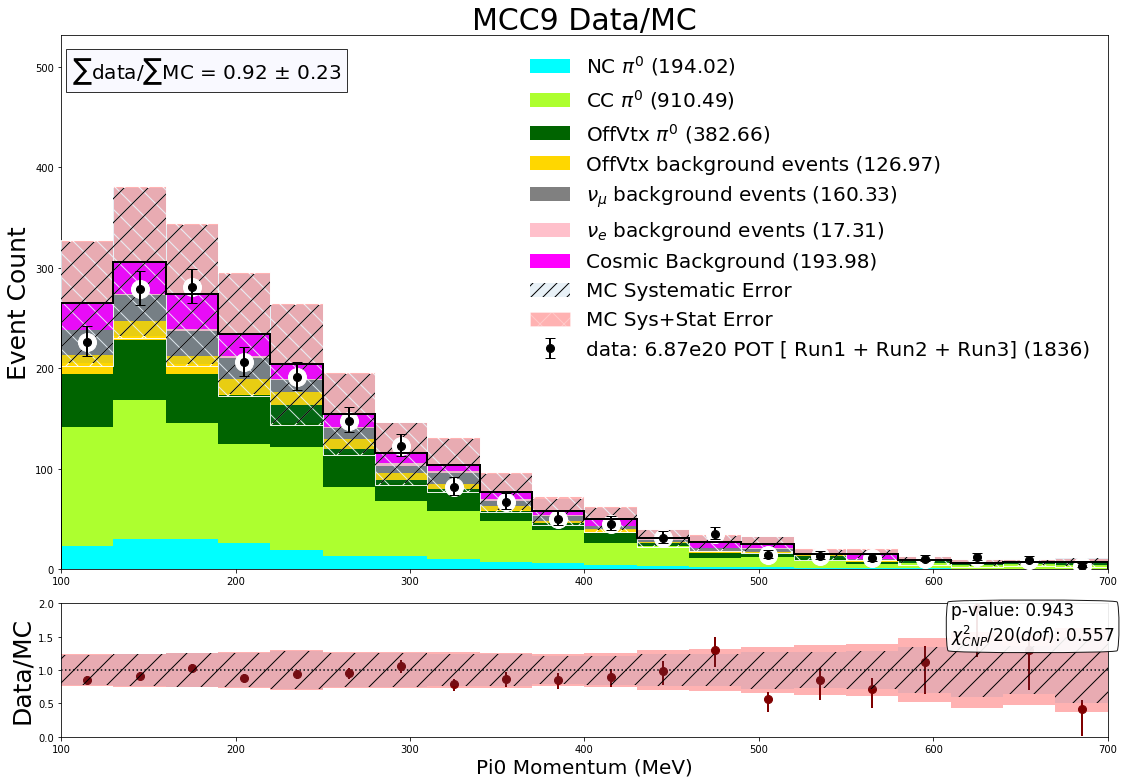

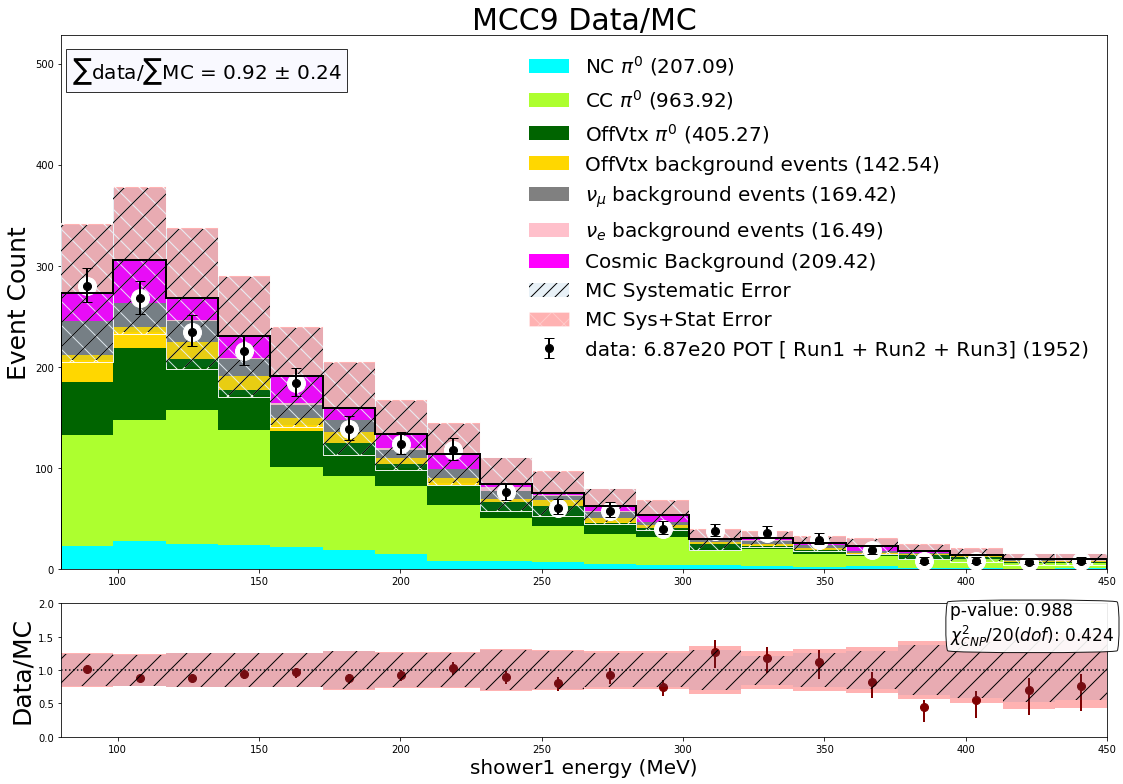

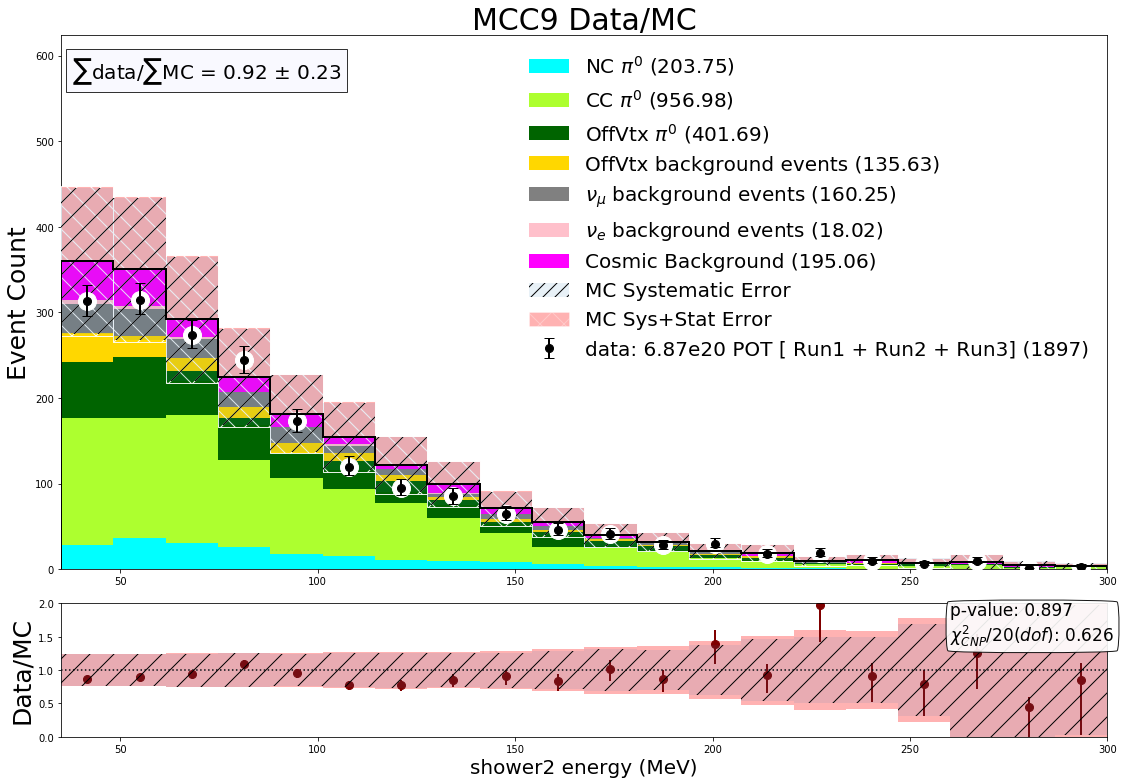

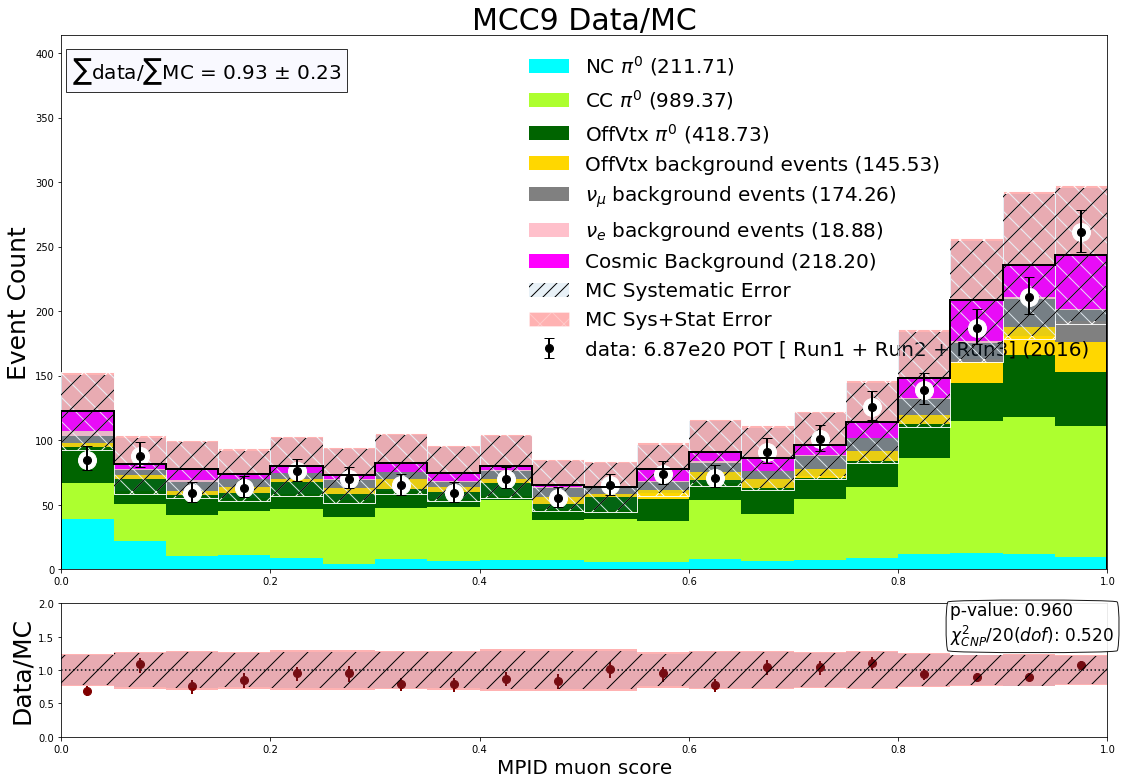

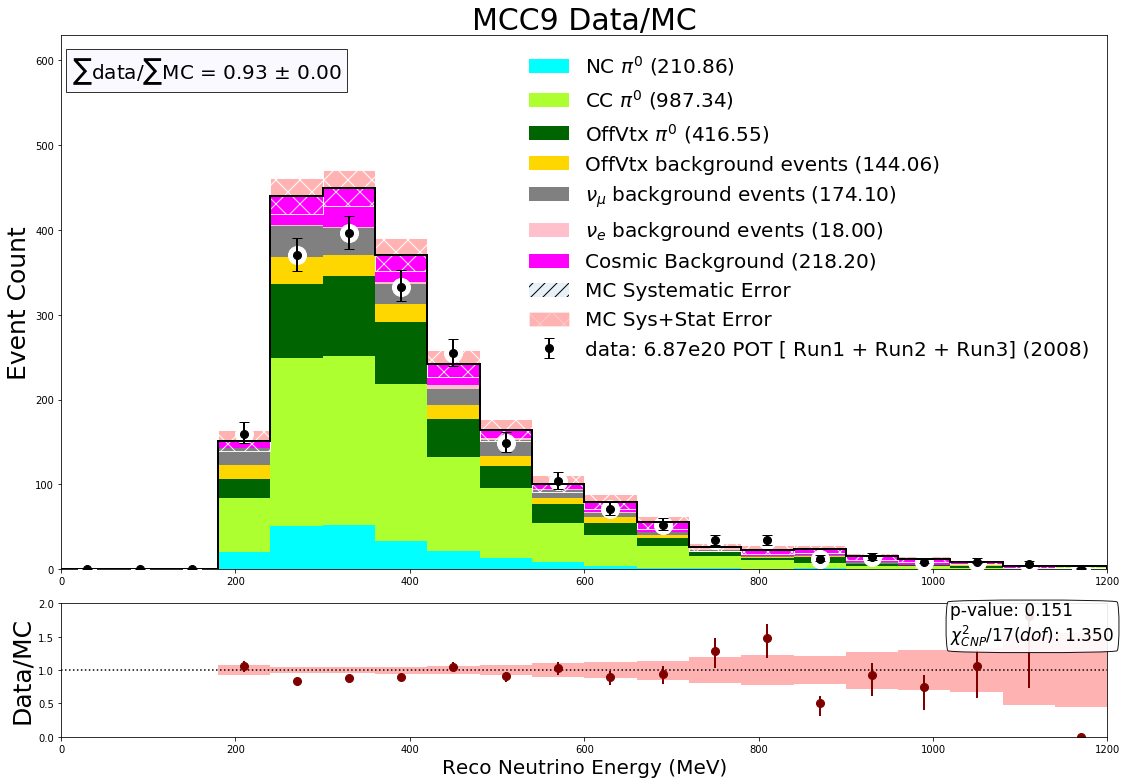

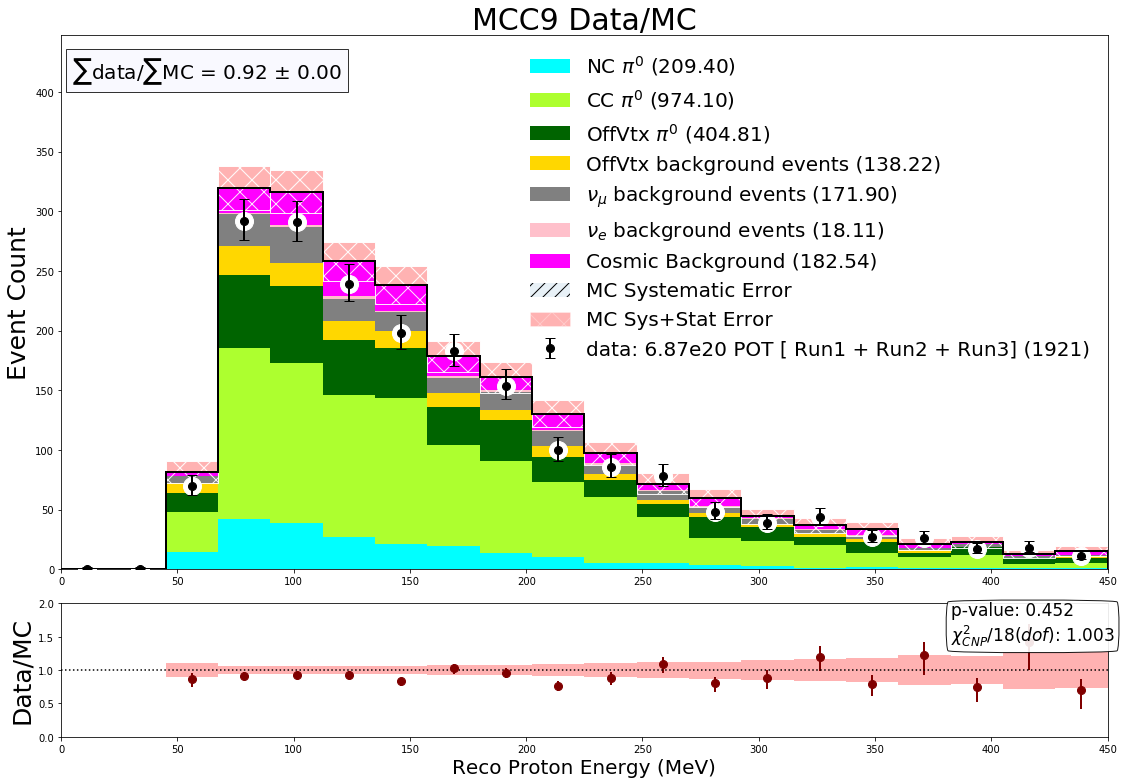

In [249]:
def getweights(df):
    a_CC= 2.75e-06
    b_CC= -0.0032
    c_CC = 1.553

    a_NC=  2.093816660137859e-06
    b_NC=  -0.003246790877041392
    c_NC=  1.5648383057401296
    weights =[]
    mom = df['pi0_momentum_true'].values
    pi0s = df['_pi0mass'].values
    ccnc = df['ccnc'].values

    for i in range(len(mom)):
        if pi0s[i] > 0 and a_CC*(mom[i]**2)+b_CC*mom[i]+c_CC <4:
            if ccnc[i]==0:
                weights.append(a_CC*(mom[i]**2)+b_CC*mom[i]+c_CC)
            else:
                if(a_NC*(mom[i]**2)+b_NC*mom[i]+c_NC <0):
                    weights.append(.001)
                else:
                    weights.append(a_NC*(mom[i]**2)+b_NC*mom[i]+c_NC)
        else:
            weights.append(1.0)
    return weights

def resetweights(df):
    weights_v = []
    for i in range(len(df)):
        weights_v.append(1.0)
    return weights_v

#reset new weights column
# df_numu_total.drop(['new_weight'], axis=1)
# df_nue_total.drop(['new_weight'], axis=1)
# df_ccpi0_total.drop(['new_weight'], axis=1)
# df_ncpi0_total.drop(['new_weight'], axis=1)

# now add in new weights
pi0_new4 = getweights(df_numu_total)
df_numu_total['new_weight'] = pi0_new4

pi0_new8 = resetweights(df_nue_total)
df_nue_total['new_weight'] = pi0_new8

pi0_new5 = getweights(df_ccpi0_total)
df_ccpi0_total['new_weight'] = pi0_new5

pi0_new6 = getweights(df_ncpi0_total)
df_ncpi0_total['new_weight'] = pi0_new6

# print(df_ncpi0_total['new_weight'])
# print(df_ccpi0_total['new_weight'])

with PdfPages('output_combined_20201109_weighted.pdf') as pdf:

    for i in range(len(vartest_list)):
        vartest = vartest_list[i]
        varname = varname_list[i]
        myrange = myrange_list[i]
        nbins =bins_list[i]
        
        if sys_list[i] == 'none':
            s_cov = np.zeros((nbins,nbins))
        else:
            s_cov = np.genfromtxt(sys_list[i],delimiter=',')
        
        if detvar1_list[i] == 'none':
            d_cov = np.zeros((nbins,nbins))
        else:
            d_cov1 = np.genfromtxt(detvar1_list[i],delimiter=',')
            d_cov3 = np.genfromtxt(detvar3_list[i],delimiter=',')
            d_cov = ((DATA_R1_PI0FILTER_POT)*d_cov1 + (DATA_R2D_PI0FILTER_POT+DATA_R2E_PI0FILTER_POT+DATA_R3F_PI0FILTER_POT+DATA_R3G_PI0FILTER_POT)*d_cov3)/(DATA_R1_PI0FILTER_POT+DATA_R2D_PI0FILTER_POT+DATA_R2E_PI0FILTER_POT+DATA_R3F_PI0FILTER_POT+DATA_R3G_PI0FILTER_POT)
        
        cov = d_cov+s_cov
#         cov =np.zeros((nbins,nbins))
        run1_open_Hists = StackedHisto((df_numu_total.query('(newhaspi0==0 and MC_parentPDG ==14) or MC_parentPDG ==-14'),df_nue_total.query('MC_parentPDG ==12'),df_ncpi0_total,df_ccpi0_total),(1.0,1.0,1.0,1.0))
        run1_open_Hists.AddStrata('haspi0==1 and ccnc==1 and MC_scedr<5 ',r"NC $\pi^0$",'cyan')
        run1_open_Hists.AddStrata('haspi0==1 and ccnc!=1 and MC_scedr<5 ',r"CC $\pi^0$",'greenyellow')
        run1_open_Hists.AddStrata('haspi0==1 and MC_scedr>=5 ',r"OffVtx $\pi^0$",'darkgreen')
        run1_open_Hists.AddStrata('MC_parentPDG ==14 and haspi0==0 and MC_scedr>=5 ',r"OffVtx background events",'gold')
        run1_open_Hists.AddStrata('MC_parentPDG ==14 and haspi0==0 and MC_scedr<5',r"$\nu_\mu$ background events",'grey')
#         run1_open_Hists.AddStrata('MC_parentPDG ==14',r"$\nu_mu$ events",'blue')
        run1_open_Hists.AddStrata('MC_parentPDG ==12 and haspi0==0',r"$\nu_e$ background events",'pink')
        run1_open_Hists.AddLayer(df_ext_total,df_ext_total['pot_weight'],0,'Cosmic Background','fuchsia')
        run1_open_DataHist = SimpleHisto(df_data_total,1.0,0,'','data: 6.87e20 POT [ Run1 + Run2 + Run3]')
        fig1,ax1,_,a = distplot_wratio_davio(vartest,nbins,myrange,run1_open_Hists,run1_open_DataHist,varname,m_cov=cov)
        pdf.savefig(fig1)

QE count:  55
Res count:  659
Dis count:  202
Coh count:  2
MEC count:  15
[  0.   9.  78. 152. 140. 127. 113.  98.  57.  34.  28.  34.  23.  13.
   9.   4.   6.   3.   1.   0.] 929.0
55
2
0


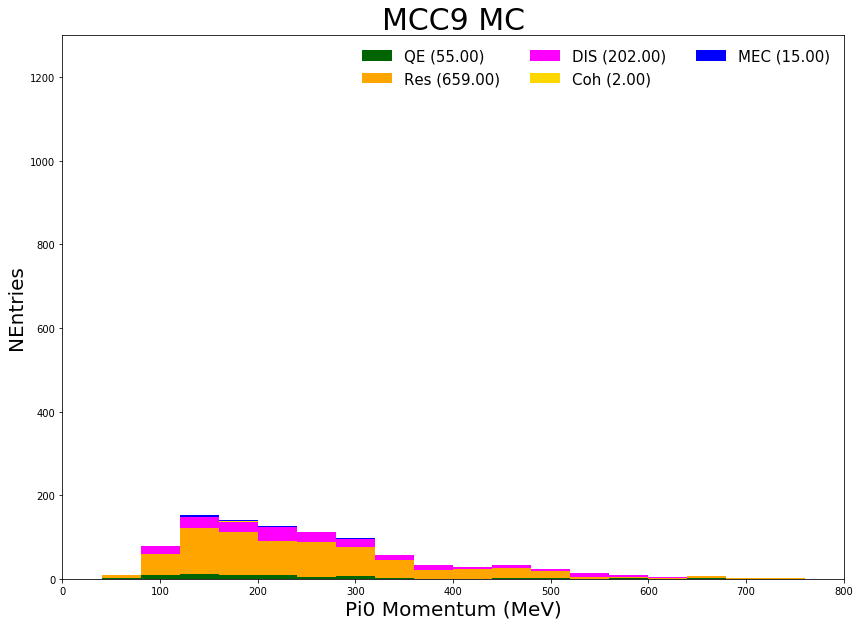

In [216]:
var_bnb_QE = df_numu_total.query("nu_interaction_mode ==0 and haspi0==1")['pi0_momentum_reco'].values
var_bnb_Res = df_numu_total.query("nu_interaction_mode ==1 and haspi0==1")['pi0_momentum_reco'].values
var_bnb_Dis = df_numu_total.query("nu_interaction_mode ==2 and haspi0==1")['pi0_momentum_reco'].values
var_bnb_Coh = df_numu_total.query("nu_interaction_mode ==3 and haspi0==1")['pi0_momentum_reco'].values
var_bnb_MEC = df_numu_total.query("nu_interaction_mode ==10 and haspi0==1")['pi0_momentum_reco'].values

print("QE count: ",len(df_numu_total.query("nu_interaction_mode ==0 and haspi0==1")))
print("Res count: ",len(df_numu_total.query("nu_interaction_mode ==1 and haspi0==1")))
print("Dis count: ",len(df_numu_total.query("nu_interaction_mode ==2 and haspi0==1")))
print("Coh count: ",len(df_numu_total.query("nu_interaction_mode ==3 and haspi0==1")))
print("MEC count: ",len(df_numu_total.query("nu_interaction_mode ==10 and haspi0==1")))

fig,ax = plt.subplots(figsize=(14,10))
_hists=[var_bnb_QE,var_bnb_Res,var_bnb_Dis,var_bnb_Coh,var_bnb_MEC]
tmp_colors = ['darkgreen','orange','magenta','gold','blue']
myrange = (0,800)
nbins = 20
ymax =1300
tmp_labels = ['QE'+' (%.2f)'%len(var_bnb_QE),'Res'+' (%.2f)'%len(var_bnb_Res),'DIS'+' (%.2f)'%len(var_bnb_Dis),'Coh'+' (%.2f)'%len(var_bnb_Coh),'MEC'+' (%.2f)'%len(var_bnb_MEC)]

fig.patch.set_alpha(1)
vals_mc = np.zeros(nbins)

for i in range(0,len(_hists)):
    v1,binedges = np.histogram(_hists[i],nbins,range=myrange)
    vals_mc += v1

print (vals_mc, sum(vals_mc))


bincenters = np.diff(binedges)/2 + binedges[:-1]     

plt.ylim(0,ymax)
plt.xlim(myrange)
ax.set_xlabel("Pi0 Momentum (MeV)",fontsize=20)
ax.set_ylabel('NEntries',fontsize=20)
ax.set_title('MCC9 MC',fontsize=30)

plt.hist(_hists,nbins,range=myrange,color=tmp_colors,stacked=True,linewidth=2.5,label=tmp_labels,edgecolor='None')

ax.legend(loc='upper right',fontsize=15,frameon=False,ncol=3)

print(len(df_numu_total.query("nu_interaction_mode ==0 and haspi0==1")))
print(len(df_numu_total.query("nu_interaction_type ==1096 and haspi0==1")))
print(len(df_numu_total.query("nu_interaction_mode ==0 and nu_interaction_type ==1096 and haspi0==1 and MC_scedr<5")))

## Save selection for Lauren

In [76]:
def getpi0weights(df):
    a_CC= 3.425e-06
    b_CC= -0.0039
    c_CC = 1.784

    a_NC= 1.885e-06
    b_NC= -0.00316
    c_NC = 1.442


    weights =[]
    mom = df['pi0_momentum_true'].values
    pi0s = df['_pi0mass'].values
    ccnc = df['ccnc'].values

    for i in range(len(mom)):
        if pi0s[i] > 0 and a_CC*(mom[i]**2)+b_CC*mom[i]+c_CC <4:
            if ccnc[i]==0:
                weights.append(a_CC*(mom[i]**2)+b_CC*mom[i]+c_CC)
            else:
                weights.append(a_NC*(mom[i]**2)+b_NC*mom[i]+c_NC)
        else:
            weights.append(1.0)
    return weights

weights1mu = getpi0weights(df_numu_1mil_pi0)
weights2mu = getpi0weights(df_numu_r2_1mil_pi0)
weights3mu = getpi0weights(df_numu_r3_pi0)
weights1e = getpi0weights(df_nue_pi0)
weights2e = getpi0weights(df_nue_r2_pi0)
weights3e = getpi0weights(df_nue_r3_pi0)
weights1cc = getpi0weights(df_ccpi0_r1_pi0)
weights3cc = getpi0weights(df_ccpi0_r3_pi0)
weights1nc = getpi0weights(df_ncpi0_r1_pi0)
weights3nc = getpi0weights(df_ncpi0_r3_pi0)

df_numu_1mil_pi0['pi0_weight']=weights1mu
df_numu_r2_1mil_pi0['pi0_weight']=weights2mu
df_numu_r3_pi0['pi0_weight']=weights3mu
df_nue_pi0['pi0_weight']=weights1e
df_nue_r2_pi0['pi0_weight']=weights2e
df_nue_r3_pi0['pi0_weight']=weights3e
df_ccpi0_r1_pi0['pi0_weight']=weights1cc
df_ccpi0_r3_pi0['pi0_weight']=weights3cc
df_ncpi0_r1_pi0['pi0_weight']=weights1nc
df_ncpi0_r3_pi0['pi0_weight']=weights3nc

In [77]:
df_numu_pi0=df_numu_1mil_pi0.query('(MC_parentPDG ==14  and newhaspi0==0) or MC_parentPDG ==-14')
df_nue_pi0=df_nue_pi0.query("MC_parentPDG ==12")

# file1 = open("2021Apr02_pi0selection_bnb_overlay_run1.txt","w")
# file1.write("[run,subrun,event,pi0mass, deltamass, shower1_energy, shower2_energy, pi0energy, pi0momentum,MPID_muon, weight]\n")
# for event in range(len(df_numu_pi0)):
#     teststr = "[" +str(df_numu_pi0['run'].values[event])+","+str(df_numu_pi0['subrun'].values[event])+","+str(df_numu_pi0['event'].values[event])+","+str(df_numu_pi0['_pi0mass_new'].values[event])+","+str(df_numu_pi0['DeltaMass_new'].values[event])
#     teststr2 =","+ str(df_numu_pi0['shower1_E_Y_new'].values[event])+","+str(df_numu_pi0['shower2_E_Y_new'].values[event])+","+ str(df_numu_pi0['pi0_energy_reco_new'].values[event])+","+ str(df_numu_pi0['pi0_momentum_reco_new'].values[event])+","+ str(df_numu_pi0['MPID_muon'].values[event])+","+ str(df_numu_pi0['pi0_weight'].values[event])+"]"+"\n"
#     file1.write(teststr+teststr2)
# file1.close()


# file2 = open("2021Apr02_pi0selection_nue_intrinsic_run1.txt","w")
# file2.write("[run,subrun,event,pi0mass, deltamass, shower1_energy, shower2_energy, pi0energy, pi0momentum,MPID_muon, weight]\n")
# for event in range(len(df_nue_pi0)):
#     teststr = "[" +str(df_nue_pi0['run'].values[event])+","+str(df_nue_pi0['subrun'].values[event])+","+str(df_nue_pi0['event'].values[event])+","+str(df_nue_pi0['_pi0mass_new'].values[event])+","+str(df_nue_pi0['DeltaMass_new'].values[event])
#     teststr2 =","+  str(df_nue_pi0['shower1_E_Y_new'].values[event])+","+str(df_nue_pi0['shower2_E_Y_new'].values[event])+","+ str(df_nue_pi0['pi0_energy_reco_new'].values[event])+","+ str(df_nue_pi0['pi0_momentum_reco_new'].values[event])+","+ str(df_nue_pi0['MPID_muon'].values[event])+","+ str(df_nue_pi0['pi0_weight'].values[event])+"]"+"\n"
#     file2.write(teststr+teststr2)
# file2.close()

# file3 = open("2021Apr02_pi0selection_ext_run1.txt","w")
# file3.write("[run,subrun,event,pi0mass, deltamass, shower1_energy, shower2_energy, pi0energy, pi0momentum,MPID_muon, weight]\n")
# for event in range(len(df_ext_pi0)):
#     teststr = "[" +str(df_ext_pi0['run'].values[event])+","+str(df_ext_pi0['subrun'].values[event])+","+str(df_ext_pi0['event'].values[event])+","+str(df_ext_pi0['_pi0mass_new'].values[event])+","+str(df_ext_pi0['DeltaMass_new'].values[event])
#     teststr2 = ","+ str(df_ext_pi0['shower1_E_Y_new'].values[event])+","+str(df_ext_pi0['shower2_E_Y_new'].values[event])+","+ str(df_ext_pi0['pi0_energy_reco_new'].values[event])+","+ str(df_ext_pi0['pi0_momentum_reco'].values[event])+","+ str(df_ext_pi0['MPID_muon'].values[event])+","+'1.0'+"]"+"\n"
#     file3.write(teststr+teststr2)
# file3.close()


file1 = open("2021May31_fullpi0selection_bnb_overlay_run1.txt","w")
file1.write("[run,subrun,event, weight, reco Enu]\n")
for event in range(len(df_numu_pi0)):
    teststr = "[" +str(df_numu_pi0['run'].values[event])+","+str(df_numu_pi0['subrun'].values[event])+","+str(df_numu_pi0['event'].values[event])
    teststr2 = ","+ str(df_numu_pi0['pi0_weight'].values[event])+ ","+ str(df_numu_pi0['Enu_1e1p'].values[event])+"]"+"\n"
    file1.write(teststr+teststr2)
file1.close()


file2 = open("2021May31_fullpi0selection_nue_intrinsic_run1.txt","w")
file2.write("[run,subrun,event, weight, reco Enu]\n")
for event in range(len(df_nue_pi0)):
    teststr = "[" +str(df_nue_pi0['run'].values[event])+","+str(df_nue_pi0['subrun'].values[event])+","+str(df_nue_pi0['event'].values[event])
    teststr2 = ","+ str(df_nue_pi0['pi0_weight'].values[event])+ ","+ str(df_nue_pi0['Enu_1e1p'].values[event])+"]"+"\n"
    file2.write(teststr+teststr2)
file2.close()

file3 = open("2021May31_fullpi0selection_ext_run1.txt","w")
file3.write("[run,subrun,event,weight, reco Enu]\n")
for event in range(len(df_ext_pi0)):
    teststr = "[" +str(df_ext_pi0['run'].values[event])+","+str(df_ext_pi0['subrun'].values[event])+","+str(df_ext_pi0['event'].values[event])
    teststr2 = ","+ "1.0"+ ","+ str(df_ext_pi0['Enu_1e1p'].values[event])+"]"+"\n"
    file3.write(teststr+teststr2)
file3.close()


In [78]:
df_numu_r2_1mil_pi0=df_numu_r2_1mil_pi0.query('(MC_parentPDG ==14  and newhaspi0==0) or MC_parentPDG ==-14')
df_nue_r2_pi0=df_nue_r2_pi0.query("MC_parentPDG ==12")

file1 = open("2021May31_fullpi0selection_bnb_overlay_run2.txt","w")
file1.write("[run,subrun,event,pi0mass, weight, reco Enu,true neutrino energy]\n")
for event in range(len(df_numu_r2_1mil_pi0)):
    teststr = "[" +str(df_numu_r2_1mil_pi0['run'].values[event])+","+str(df_numu_r2_1mil_pi0['subrun'].values[event])+","+str(df_numu_r2_1mil_pi0['event'].values[event])
    teststr2 = ","+ str(df_numu_r2_1mil_pi0['pi0_weight'].values[event])+ ","+ str(df_numu_r2_1mil_pi0['Enu_1e1p'].values[event])+ "," +str(df_numu_r2_1mil_pi0['nu_energy_true'].values[event])+"]"+"\n"
    file1.write(teststr+teststr2)
file1.close()


file2 = open("2021May31_fullpi0selection_nue_intrinsic_run2.txt","w")
file2.write("[run,subrun,event,pi0mass, weight, reco Enu,true neutrino energy]\n")
for event in range(len(df_nue_r2_pi0)):
    teststr = "[" +str(df_nue_r2_pi0['run'].values[event])+","+str(df_nue_r2_pi0['subrun'].values[event])+","+str(df_nue_r2_pi0['event'].values[event])
    teststr2 = ","+ str(df_nue_r2_pi0['pi0_weight'].values[event])+ ","+ str(df_nue_r2_pi0['Enu_1e1p'].values[event])+ "," +str(df_nue_r2_pi0['nu_energy_true'].values[event])+"]"+"\n"
    file2.write(teststr+teststr2)
file2.close()


In [79]:
df_numu_r3_pi0=df_numu_r3_pi0.query('(MC_parentPDG ==14  and newhaspi0==0) or MC_parentPDG ==-14')
df_nue_r3_pi0=df_nue_r3_pi0.query("MC_parentPDG ==12")

file1 = open("2021May31_fullpi0selection_bnb_overlay_run3.txt","w")
file1.write("[run,subrun,event, weight, reco Enu]\n")
for event in range(len(df_numu_r3_pi0)):
    teststr = "[" +str(df_numu_r3_pi0['run'].values[event])+","+str(df_numu_r3_pi0['subrun'].values[event])+","+str(df_numu_r3_pi0['event'].values[event])
    teststr2 = ","+ str(df_numu_r3_pi0['pi0_weight'].values[event])+ ","+ str(df_numu_r3_pi0['Enu_1e1p'].values[event])+"]"+"\n"
    file1.write(teststr+teststr2)
file1.close()


file2 = open("2021May31_fullpi0selection_nue_intrinsic_run3.txt","w")
file2.write("[run,subrun,event, weight, reco Enu]\n")
for event in range(len(df_nue_r3_pi0)):
    teststr = "[" +str(df_nue_r3_pi0['run'].values[event])+","+str(df_nue_r3_pi0['subrun'].values[event])+","+str(df_nue_r3_pi0['event'].values[event])
    teststr2 = ","+ str(df_nue_r3_pi0['pi0_weight'].values[event])+ ","+ str(df_nue_r3_pi0['Enu_1e1p'].values[event])+"]"+"\n"
    file2.write(teststr+teststr2)
file2.close()

file3 = open("2021May31_fullpi0selection_ext_run3.txt","w")
file3.write("[run,subrun,event,weight, reco Enu]\n")
for event in range(len(df_ext_r3_pi0)):
    teststr = "[" +str(df_ext_r3_pi0['run'].values[event])+","+str(df_ext_r3_pi0['subrun'].values[event])+","+str(df_ext_r3_pi0['event'].values[event])
    teststr2 = ","+ "1.0"+ ","+ str(df_ext_r3_pi0['Enu_1e1p'].values[event])+"]"+"\n"
    file3.write(teststr+teststr2)
file3.close()

In [81]:
file1 = open("2021May31_fullpi0selection_CCPi0_run1.txt","w")
file1.write("[run,subrun,event, weight, reco Enu]\n")
for event in range(len(df_ccpi0_r1_pi0)):
    teststr = "[" +str(df_ccpi0_r1_pi0['run'].values[event])+","+str(df_ccpi0_r1_pi0['subrun'].values[event])+","+str(df_ccpi0_r1_pi0['event'].values[event])
    teststr2 = ","+ str(df_ccpi0_r1_pi0['pi0_weight'].values[event])+ ","+ str(df_ccpi0_r1_pi0['Enu_1e1p'].values[event])+"]"+"\n"
    file1.write(teststr+teststr2)
file1.close()

file1 = open("2021May31_fullpi0selection_CCPi0_run3.txt","w")
file1.write("[run,subrun,event, weight, reco Enu]\n")
for event in range(len(df_ccpi0_r3_pi0)):
    teststr = "[" +str(df_ccpi0_r3_pi0['run'].values[event])+","+str(df_ccpi0_r3_pi0['subrun'].values[event])+","+str(df_ccpi0_r3_pi0['event'].values[event])
    teststr2 = ","+ str(df_ccpi0_r3_pi0['pi0_weight'].values[event])+ ","+ str(df_ccpi0_r3_pi0['Enu_1e1p'].values[event])+"]"+"\n"
    file1.write(teststr+teststr2)
file1.close()



In [82]:
file1 = open("2021May31_fullpi0selection_NCPi0_run1.txt","w")
file1.write("[run,subrun,event, weight, reco Enu]\n")
for event in range(len(df_ncpi0_r1_pi0)):
    teststr = "[" +str(df_ncpi0_r1_pi0['run'].values[event])+","+str(df_ncpi0_r1_pi0['subrun'].values[event])+","+str(df_ncpi0_r1_pi0['event'].values[event])
    teststr2 = ","+ str(df_ncpi0_r1_pi0['pi0_weight'].values[event])+ ","+ str(df_ncpi0_r1_pi0['Enu_1e1p'].values[event])+"]"+"\n"
    file1.write(teststr+teststr2)
file1.close()

file1 = open("2021May31_fullpi0selection_NCPi0_run3.txt","w")
file1.write("[run,subrun,event, weight, reco Enu]\n")
for event in range(len(df_ncpi0_r3_pi0)):
    teststr = "[" +str(df_ncpi0_r3_pi0['run'].values[event])+","+str(df_ncpi0_r3_pi0['subrun'].values[event])+","+str(df_ncpi0_r3_pi0['event'].values[event])
    teststr2 = ","+ str(df_ncpi0_r3_pi0['pi0_weight'].values[event])+ ","+ str(df_ncpi0_r3_pi0['Enu_1e1p'].values[event])+"]"+"\n"
    file1.write(teststr+teststr2)
file1.close()
